<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src="https://miro.medium.com/v2/resize:fit:1400/1*PhKGj_bZlND8IEfII426wA.png" 
/>

</figure>


<h1 style="width: 60%; color: Orange; font-size: 40pt;">
    <Strong>
        CEGM2003 project: Bayesian optimization for truss structures
    </Strong>
</h1>

<h2 id="Background"><B>
    Background<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     Structures that make optimal use of the material they are made of reduces the cost and environmental impact of their construction as the amount of material required. Optimization of structural design is a challenging task because of the high number of design parameters and the relatively expensive evaluation of the suitability of any given design. Standard optimization techniques in high-dimensional design space require a very large number of possible designs that need to be evaluated. In structural analysis, where evaluating the objective function and checking the constraints involves the solution of a structural mechanics problem, e.g. with finite elements, this quickly becomes very expensive, even if the model is relatively simple from structural point of view. Bayesian optimization is a machine-learning-based optimization technique that aims to reduce the number of evaluations of the objective function through data-driven exploration of the design space with a probabilistic surrogate.
</p>

<h2 id="Background"><B>
    Objective & Description<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>

<div style="width: 60%; border-top: 4px solid #34D058; border-left: 4px solid #34D058; background-color: #F6FFED; padding: 1em 1em 1em 1em; color: #24292E; margin: 10px 0 20px 0; box-sizing: border-box;">
    <div style="background-color: #34D058; color: white; padding: 0.2em 1em; margin: -1em -1em 0em -1em; font-size: 1.2em;"><strong>Project Objective</strong></div>
    <p><strong>The aim of this project is to find an optimal truss design,</strong><br>
    The goal is to find an optimal set of nodal coordinates and cross-sectional properties. The primary objective is to minimize the total weight of the structure, while satisfying structural requirements. Optionally, additional objectives can be included, e.g. on the minimization of cutoff waste when reusing components from an existing inventory of elements.</p>
</div>

## <strong> X | Imports</strong>

In [61]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import sys
import pandas as pd
import os

import io
from contextlib import redirect_stdout

sys.path.append('../pyJive/')
from utils import proputils as pu
import main
from names import GlobNames as gn

In [5]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## <strong> X | Classes & Dependencies</strong>

In [84]:
class TRUSS():
    def __init__(self, file_path, output_path):
        # ------------------------------ DO NOT CHANGE  ------------------------------ #
        self.read_file_path = file_path
        self.write_file_path = output_path
        self.nodes = {} 
        self.connectivity = None
        # --------------------------------- ATRIBUTES -------------------------------- #
        self.member_df = None
        self.y_coordinates =  None  # Targets or other appropriate initialization #
        self.x_coordinates =  None 
        self.cross_sections = None

        self.lengths = None
    
    # -------------------------- Import & Writing Files -------------------------- #
    def read_geom_file(self):
        path = os.path.normpath(os.path.join(self.read_file_path,'bridge.geom'))
        with open(path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
                continue
            elif line.startswith('member:'):
                section = 'member'
                continue

            if section == 'node' and line:
                parts = line.split()
                node_number = int(parts[0])
                node_data = tuple(map(float, parts[1:]))
                nodes[node_number] = node_data
            elif section == 'member' and line:
                member_data = tuple(map(int, line.split()))
                members.append(member_data)

        self.nodes = nodes
        self.member_df = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])
        
        connectivity = self.member_df.to_numpy()
        self.connectivity = connectivity[:,:2]
        self.y_coordinates = np.array([value[1] for key, value in self.nodes.items()])
        self.x_coordinates = np.array([value[0] for key, value in self.nodes.items()])
    
    def get_geom_file(self,y_list): 
        path = os.path.normpath(os.path.join(self.read_file_path,'bridge.geom'))
        file = open(path)
        filestring = file.read()

        split = filestring.split('\n')

        y_list = np.append(y_list, y_list[:-1][::-1])
        mod_indices = np.arange(3,20,2)

        count = 0
        for i in range(len(split)):
            split[i] += '\n'
            if i in mod_indices:
                linesplit = split[i].split(' ')
                linesplit[-1] = str(y_list[count]) + '\n'
                split[i] = ' '.join(linesplit)
                count += 1

        geom = ' '.join(split)

        pathgeom = os.path.normpath(os.path.join(self.read_file_path,'geomfile.geom')) 
        with open(pathgeom, "w") as file:
            file.write(geom)
            
        return file.name
    
    def mmscaler(self, mode,x_values, scaler_y=None):
        
        if mode == 'scale':
            # Reshape y_coord and cross_sections if they are 1D arrays
            if x_values.ndim == 1:
                y_coord = x_values.reshape(-1, 1)
            
            y_coord = scaler_y.fit_transform(y_coord)
                    
            return y_coord

        elif mode == 'descale':
            num_y_coordinates = y_coord.size
            scaled_y_coordinates = scaled_data[:num_y_coordinates, :]
            x_values  = scaler_y.inverse_transform(scaled_y_coordinates)
            
            return x_values

        
    # ---------------------------------- Solvers --------------------------------- #    
    def loss_function(self, x_list, mass_penalty=1, constraint_penalty=1, Area_lower=4e-3):
        A_list = x_list[5:]
        y_list = x_list[:5]
        mass = self.mass_truss(A_list, y_list)
        constraint, freq = self.constraint(A_list, y_list)
        total_loss = np.abs((constraint_penalty * constraint) + (mass_penalty * mass))
        if (mass <= 0):
            total_loss += constraint_penalty * mass
        if constraint != 0:
            print(f'The constraints for the natural frequencies are not met NATURAL FREQUENCIES: {freq}')
        else:
            print(f'The constraints of the natural frequencies are met NATURAL FREQUENCIES: {freq}')
            print(f'The total loss is:{total_loss}')        
        return total_loss

    def eigenfrequencies(self,A_list, y_list):

        # Read the input file and store in props object
        path = os.path.normpath(os.path.join(read_file_path,'bridge_frequency.pro'))
        geom_path = os.path.normpath(os.path.join(read_file_path,'bridge.geom'))
        props = pu.parse_file(path)
        props['model']['truss']['area'] = A_list
        props['init']['mesh']['file'] = self.get_geom_file(y_list)
        
        # Call the program and store output in globdat
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        
        return(globdat[gn.EIGENFREQS][0:3]/2/np.pi)


    # ---------------------------------------------------------------------------- #
    #                               SUPPORT FUNCTIONS                              #
    # ---------------------------------------------------------------------------- #
    def constraint(self, A_list, y_list, constr1=20, constr2=40, constr3=60):
        # convert first three natrual frequencies to Hz
        freq1, freq2, freq3 = self.eigenfrequencies(A_list, y_list)
        freq = [freq1, freq2, freq3]
        # calculate the violations of the constraints
        violation1 = max(0, constr1 - freq1)
        violation2 = max(0, constr2 - freq2)
        violation3 = max(0, constr3 - freq3)

        imag_parts = np.abs(np.sum(np.imag([freq1, freq2, freq3])))
        
        #calculate the losses with the penalty
        total_violation = violation1 + violation2 + violation3 + imag_parts
        if total_violation > 0:
            total_violation += 200
        return total_violation , freq
    
    def calculate_length(self,node1, node2, coordinates):
        x1, y1 = coordinates[node1]
        x2, y2 = coordinates[node2]
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def mass_truss(self,areas, y_list):
        x_coordinates = self.x_coordinates
        y_coordinates = self.y_coordinates
        # y_list = y_list[:5]
        # areas = y_list[5:]

        for i in range(5):
            y_coordinates[2 * i + 1] = y_list[i]
            y_coordinates[20 - 2 * i - 1] = y_list[i]
        self.y_coordinates = y_coordinates

        coordinates = list(zip(x_coordinates, y_coordinates))
        lengths = np.zeros(self.member_df.iloc[:,2].sum()) # Number of Elements

        for i, (node1, node2) in enumerate(self.connectivity):
            x1, y1 = coordinates[node1]
            x2, y2 = coordinates[node2]
            lengths[i] =  np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        n_elements = self.member_df.iloc[:,2].sum()
        areas_i = np.zeros(n_elements)
        cross_section_number = self.member_df.iloc[:,-1]
        for i,item in enumerate(cross_section_number):
            if i == 15: 
                areas_i[i] = 1e-4
            else:
                print()
                areas_i[i] = areas[item]
        self.cross_sections = areas[:15]
        self.lengths = areas_i
        volumes = lengths * areas_i

        total_volume = np.sum(volumes)
        dens = 7800
        mass = total_volume * dens

        return mass
    
    # ----------------------------------- other ---------------------------------- #
    def Initial_guess(self):
        y = np.random.uniform(0, 2, 5)
        Areas = np.random.uniform(0.000, 0.01, 15)

        x_list = np.append(y, Areas)
        return x_list
    
    
    def final_results(x_list, Area_lower=4e-3):
        A_list = x_list[5:]
        A_list = np.append([Area_lower], A_list)
        y_list = x_list[0:5]

        if constraint(A_list, y_list) != 0:
            print(f'The constraints for the natural frequencies are not met')
        else:
            print(f'The constraints of the natural frequencies are met')
            
        return mass_TRUSS(A_list, y_list), eigenfrequencies(A_list, y_list)

def aysplit(x):
    areas = x[5:]
    y_coords = x[:5]
    return areas, y_coords


In [29]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []

    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost

        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array(x_new).reshape(1, -1), return_std=True)
        #sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new[0] == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        min_mean_y = self.y_min#mean_y#np.min(mean_y)
        z = (min_mean_y - mean_y_new) / sigma_y_new
        exp_imp = (min_mean_y - mean_y_new) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        return exp_imp
    

    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
        
        
    def _get_next_probable_point(self):
        min_ei = float(sys.maxsize)
        x_optimal = None 
                
        # Trial with an array of random data points
        #mean_y = np.min(self.gauss_pr.predict(self.x_init))
        for b in range(self.batch_size):
            x_start = self.Next_guess()
            #response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
            # if response.fun[0] < min_ei:

            #if response.fun < min_ei:
            #    # min_ei = response.fun[0]
            #    min_ei = response.fun
            #   x_optimal = response.x
            
            ei = self._acquisition_function(x_start)
            if (ei < min_ei):
                min_ei = ei
                x_optimal = x_start
        
        #bnds = bnds = ((0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2), (0.0001, 2))
        #response = minimize(self._acquisition_function, x_optimal, bounds=bnds)
        #if response.fun < min_ei:
        #    # min_ei = response.fun[0]
        #    min_ei = response.fun
        #    x_optimal = response.x

        return x_optimal, min_ei
    
    
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array([y]), axis = 0)
  

    def optimize(self):
        y_min_ind = np.argmin(self.y_init)
        y_min = self.y_min = self.y_init[y_min_ind]
        optimal_x = self.x_init[y_min_ind]
        optimal_ei = None
        best_iter = 0

        for i in range(self.n_iter):
            print(f'Iteration: {i}, the best loss = {y_min:.2f}')
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array(x_next))
            self._extend_prior_with_posterior_data(x_next,y_next)

            if ((y_next < y_min) & (y_next > 0)):
                y_min = self.y_min = y_next
                optimal_x = x_next
                # optimal_ei = ei[0]
                optimal_ei = ei
                best_iter = i

            if i == 0:
                prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
                
            self.best_samples_ = pd.concat((self.best_samples_, pd.DataFrame({"y": [y_min], "ei": [optimal_ei]})), ignore_index=True) 
        return optimal_x, y_min

    def Next_guess(self, y_bound=(0, 2), A_bound=(0, 0.01)):
            y = np.random.uniform(y_bound[0], y_bound[1], 5)
            Areas = np.random.uniform(A_bound[0], A_bound[1], 15)
            x_list = np.append(y, Areas)
            return x_list

def target_function_wrapper(x):
    return TRUSS1.loss_function(x)       

## <strong> 1 | Initialisation</strong>

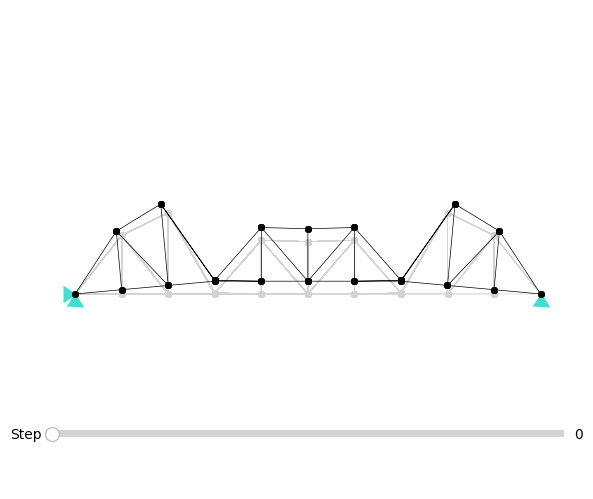

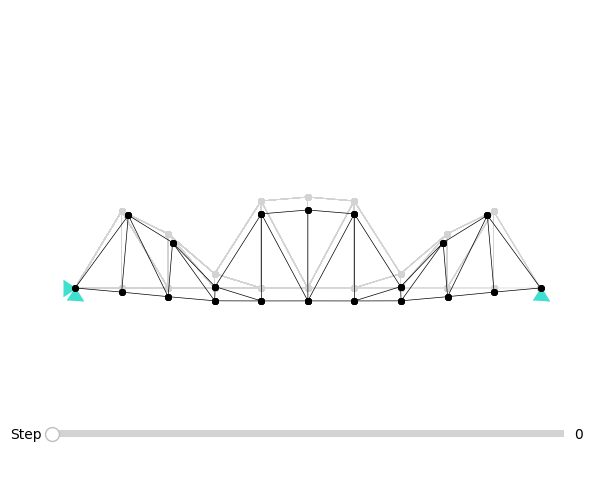

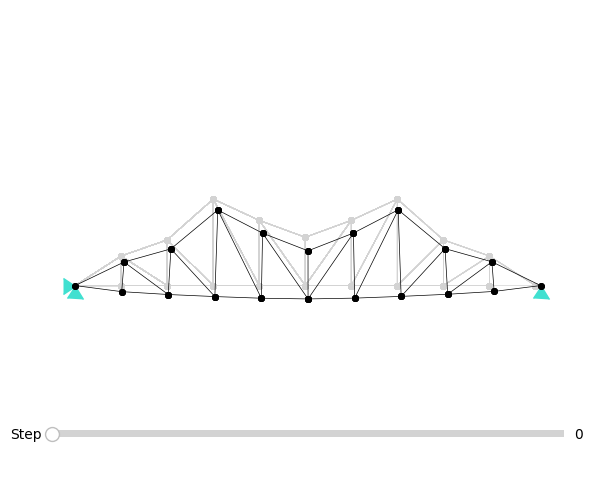

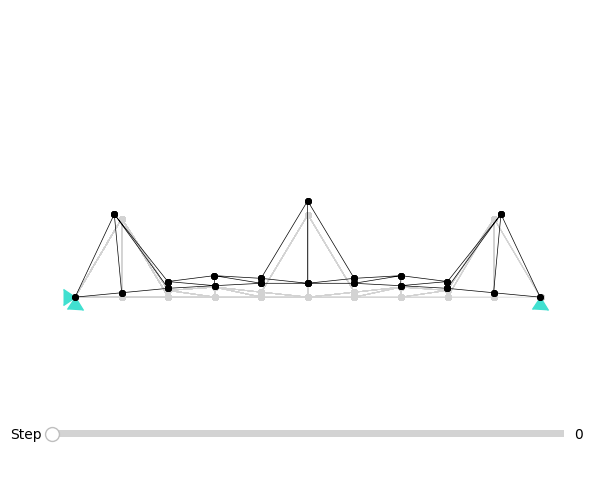

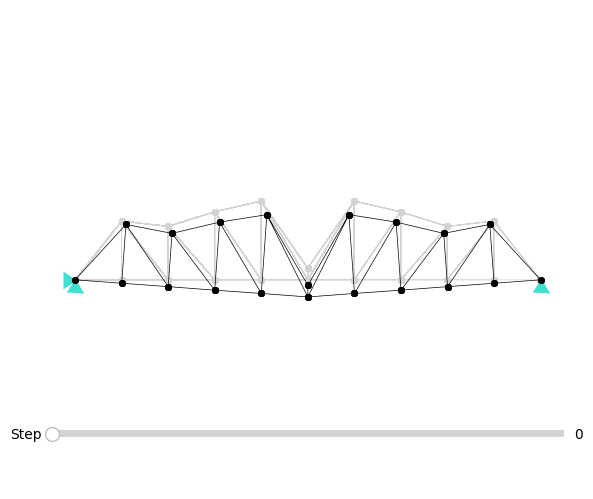

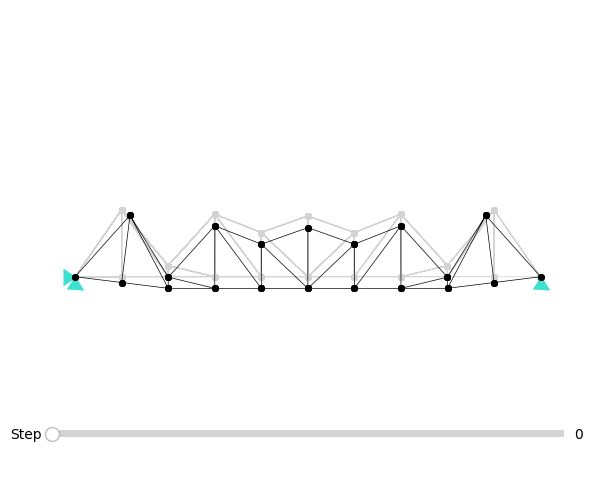

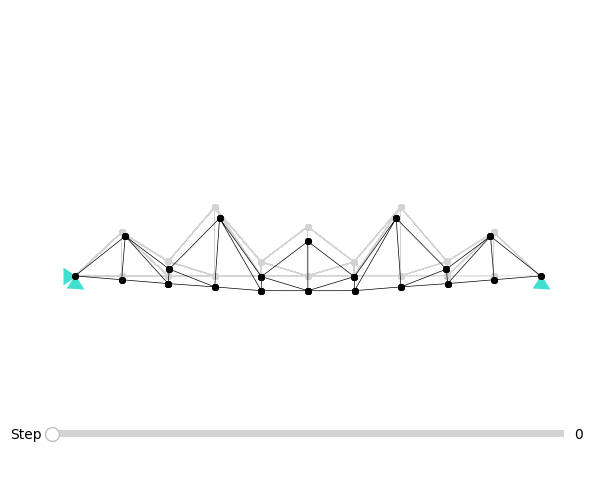

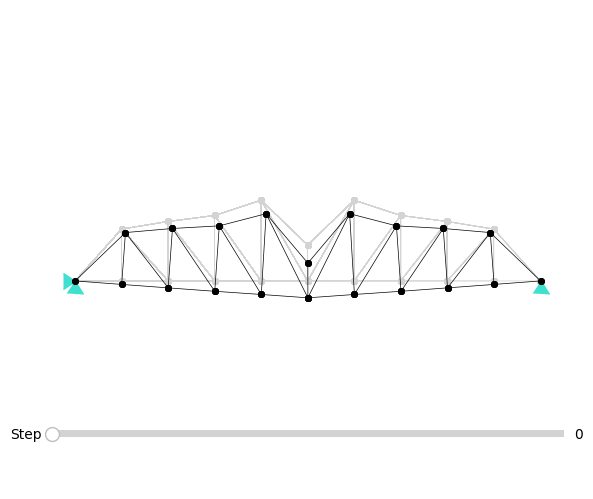

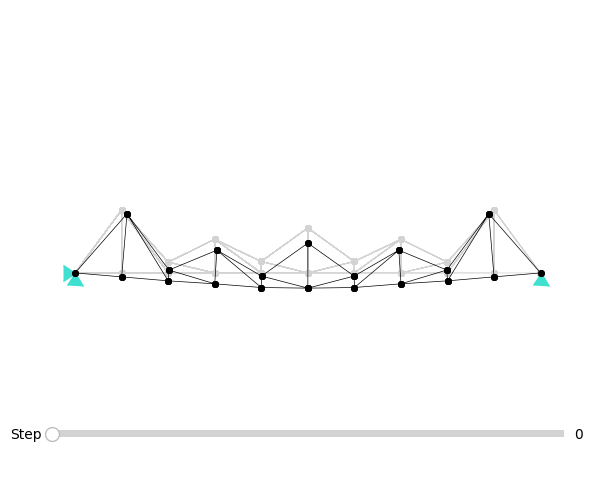

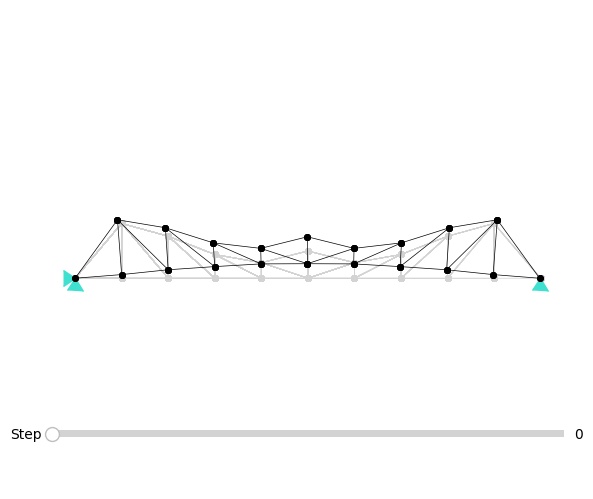

In [92]:
# -------------------------------- Definitions ------------------------------- #
read_file_path = '../truss_bridge/data'
write_file_path =  '../truss_bridge/data/@TRUSS'
x_list = []
y_list = []

TRUSS1 = TRUSS(read_file_path,write_file_path)
TRUSS1.read_geom_file()

# x_list = []
# y_list = []
# scaler_cs = MinMaxScaler(feature_range=(0,1))
    
n_samples = 10
for i in range(n_samples):
    x_values = TRUSS1.Initial_guess()
    #y_coord, cross_sections = aysplit(x)
    #x_std = TRUSS1.mmscaler('scale', cross_sections, scaler_y = scaler_cs).flatten()
    #x_values = np.concatenate((y_coord, x_std), axis=0)
    x_list.append(x_values)
    trap = io.StringIO()
    with redirect_stdout(trap):
        total_loss = TRUSS1.loss_function(x_list[-1])
        y_list.append(total_loss)

## <strong> 2 | Optimisation</strong>

Iteration: 0, the best loss = 1898.06






































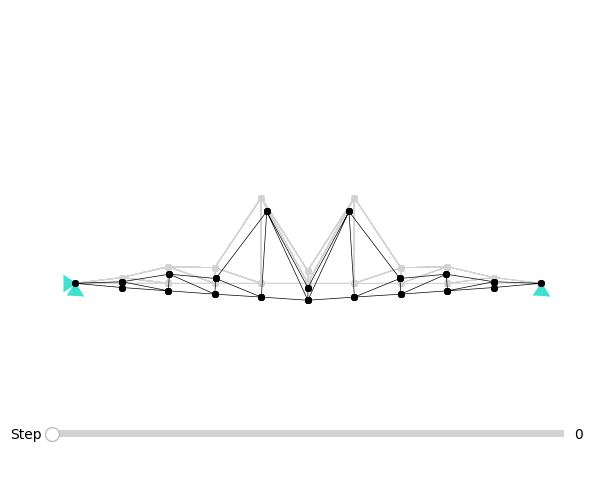

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.4359211272193813, 22.87506259092722, 28.411280859807142]
Iteration: 1, the best loss = 1898.06






































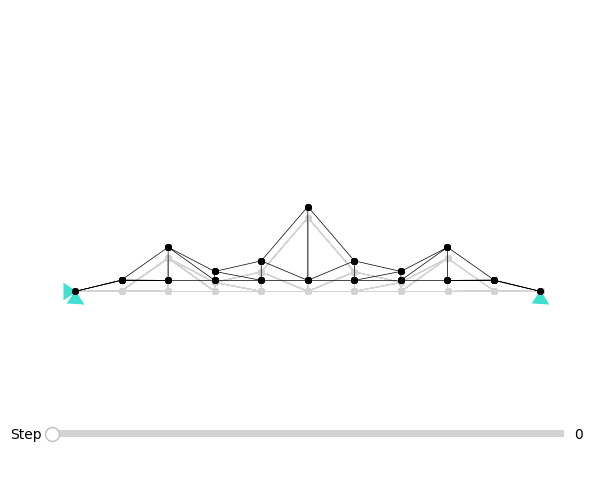

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.7461128821913597, 1.5747888910437122, 22.786249873932988]
Iteration: 2, the best loss = 1898.06






































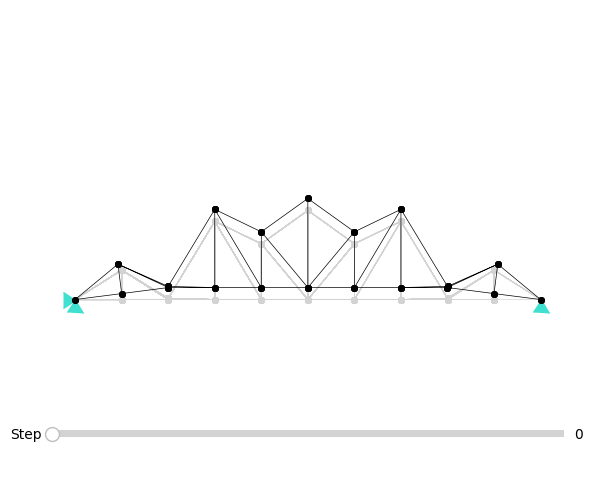

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.9472943708325362, 2.3192653824804124, 64.44141027640023]
Iteration: 3, the best loss = 1898.06






































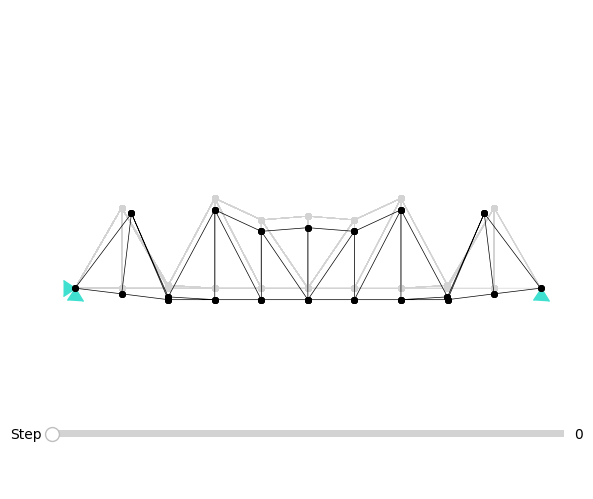

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.5042077181446639, 1.1257807024454822, 52.2431865753871]
Iteration: 4, the best loss = 1898.06






































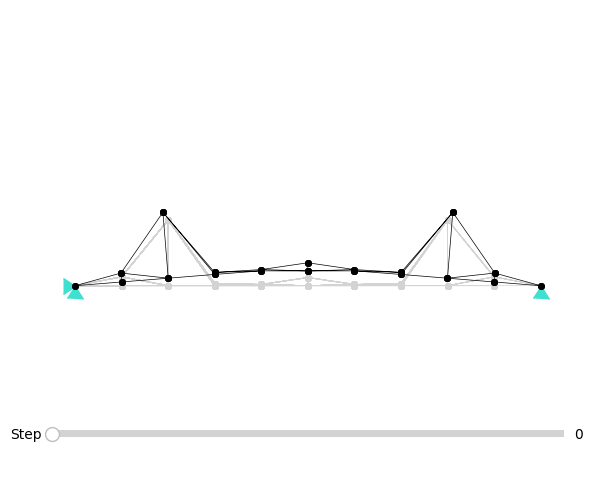

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.5092361999654744, 2.4089418211077716, 5.223170559484652]
Iteration: 5, the best loss = 1898.06






































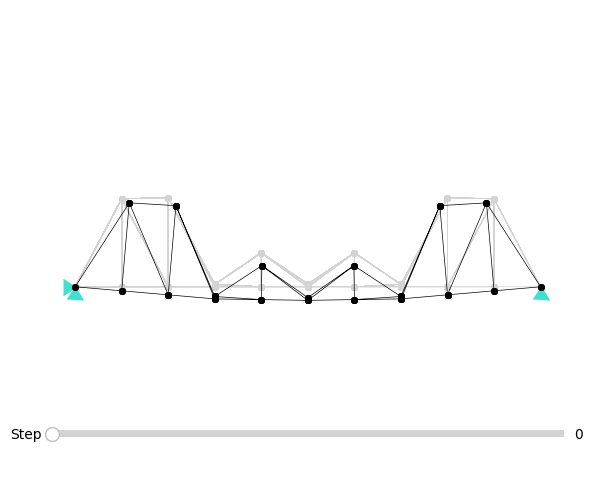

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.6524217115773343, 2.189403471495566, 9.186760141642228]
Iteration: 6, the best loss = 1898.06






































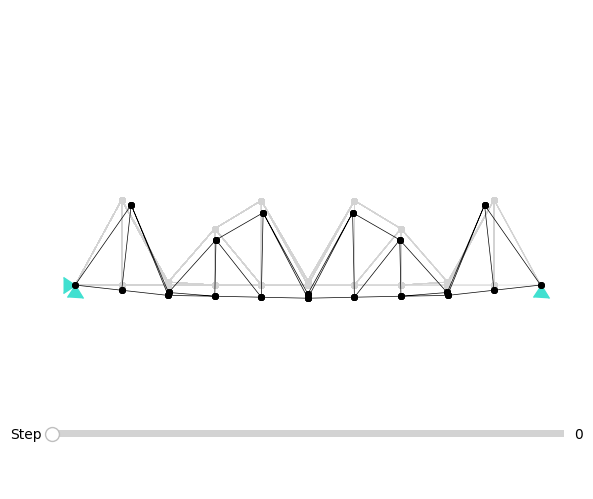

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.3471185889688768, 0.9199425978203979, 2.013920914293734]
Iteration: 7, the best loss = 1898.06






































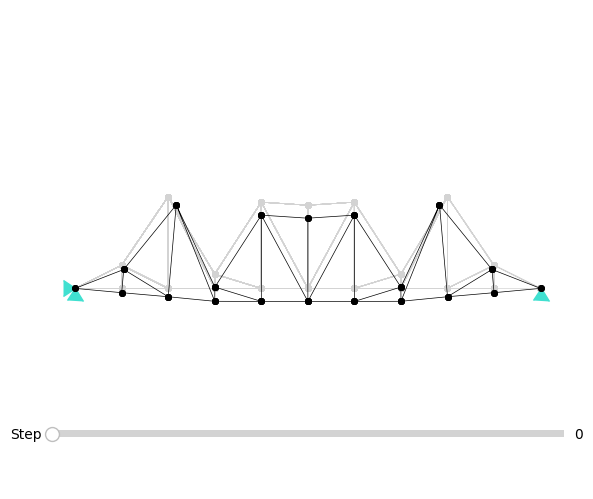

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.202216080182566, 12.858991274244152, 59.43028715287109]
Iteration: 8, the best loss = 1898.06






































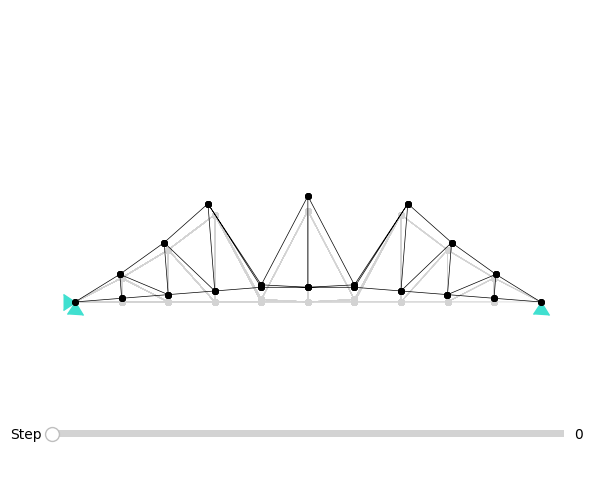

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.5677297288780202, 2.962725570099508, 67.24329810280685]
Iteration: 9, the best loss = 1898.06






































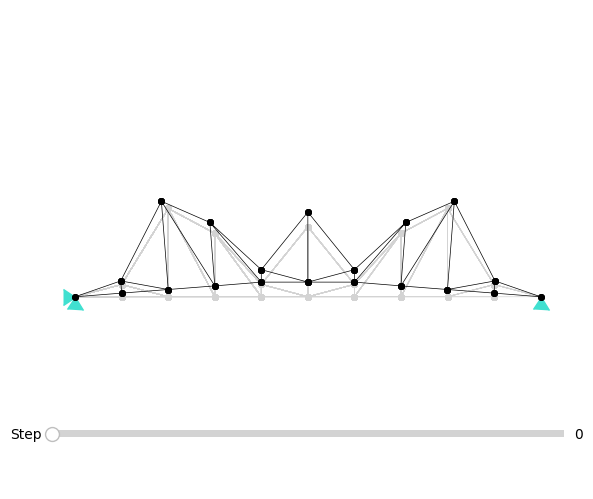

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.4690405229975119, 8.203123671048656, 44.70476366046853]
Iteration: 10, the best loss = 1898.06






































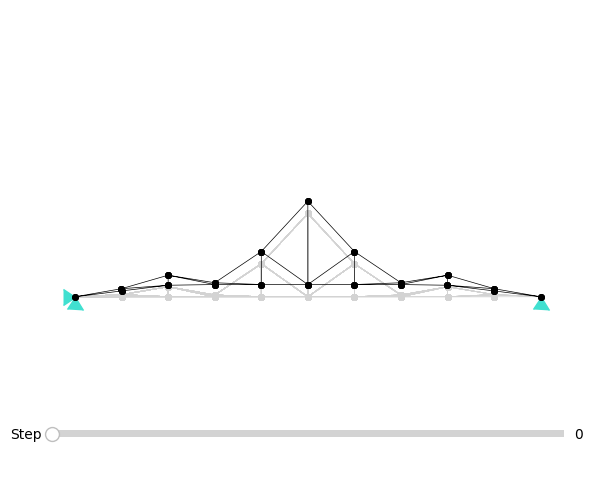

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.6120019724502873, 1.7428444869099378, 13.606721778645804]
Iteration: 11, the best loss = 1898.06






































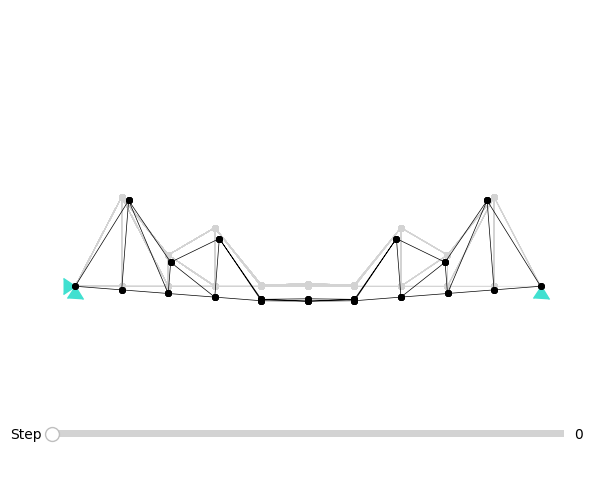

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.6199112641651389, 3.4552399187324854, 26.695799902833656]
Iteration: 12, the best loss = 1898.06






































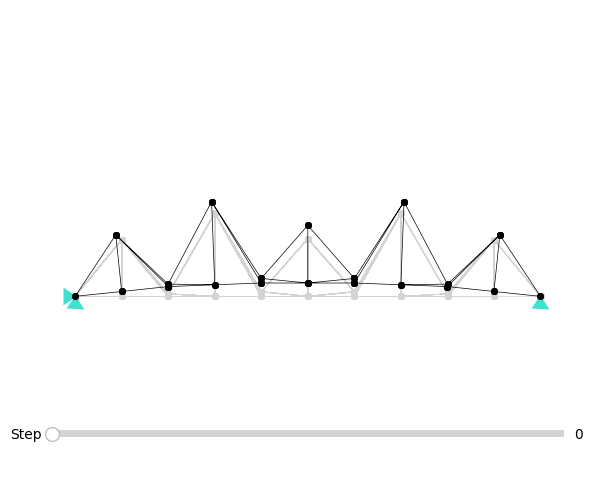

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.7685627250960089, 2.5304905723293922, 5.491176861029791]
Iteration: 13, the best loss = 1898.06






































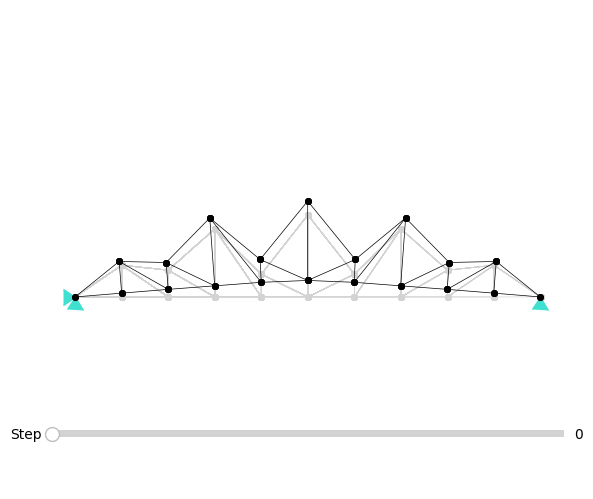

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.526358577798771, 42.390411152329456, 61.818690702607185]
Iteration: 14, the best loss = 1898.06






































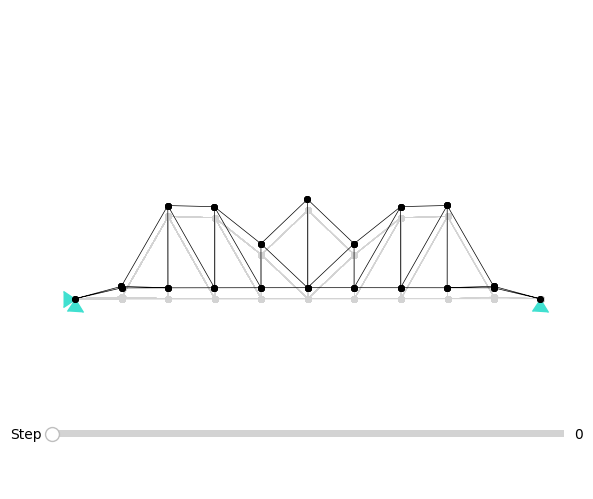

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.2164144080790573, 2.6015556899298966, 25.579326506867353]
Iteration: 15, the best loss = 1898.06






































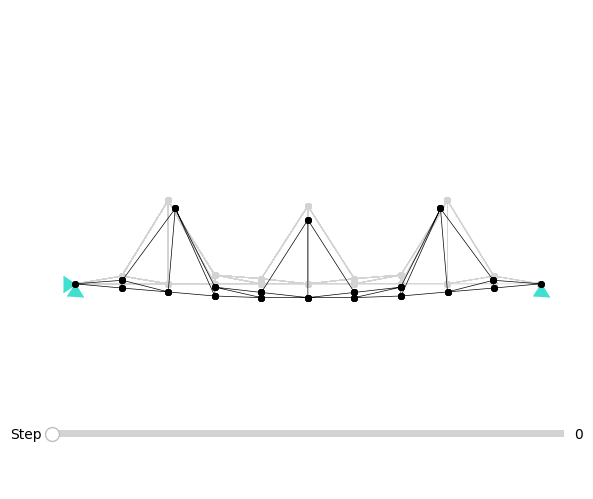

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.358142993101944, 9.205910792827709, 29.481704660488848]
Iteration: 16, the best loss = 1898.06






































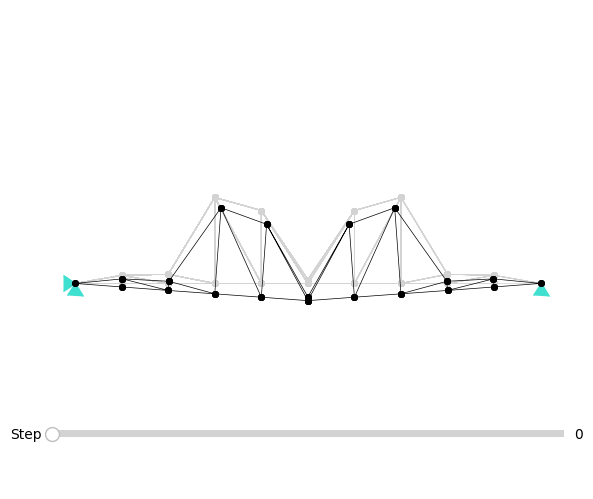

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.9444020348507993, 15.21786985428757, 18.301549527898974]
Iteration: 17, the best loss = 1898.06






































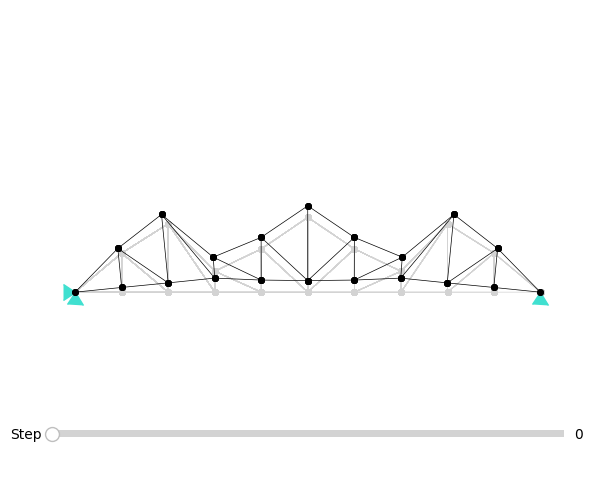

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.531476649784884, 15.164094109428676, 57.59416386655135]
Iteration: 18, the best loss = 1898.06






































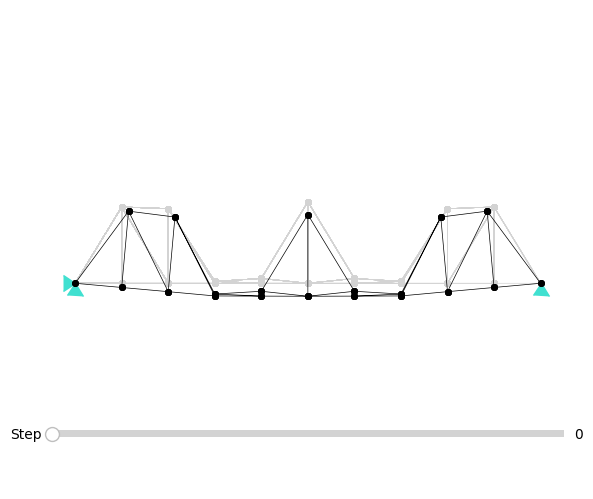

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.5398623823104705, 1.7581813035657785, 15.447805401380048]
Iteration: 19, the best loss = 1898.06






































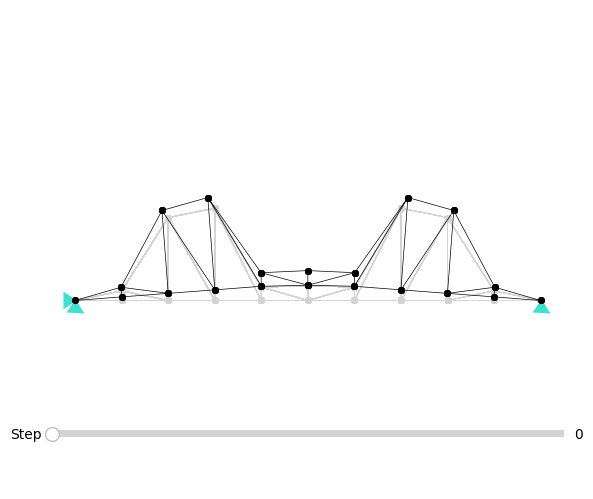

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.8474204198515303, 12.868903648062561, 47.03686952787248]
Iteration: 20, the best loss = 1898.06






































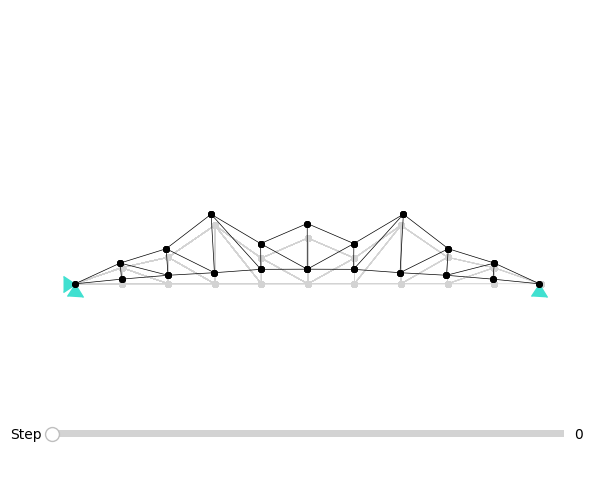

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.201048008747794, 43.333768887285515, 58.72718520987017]
Iteration: 21, the best loss = 1898.06






































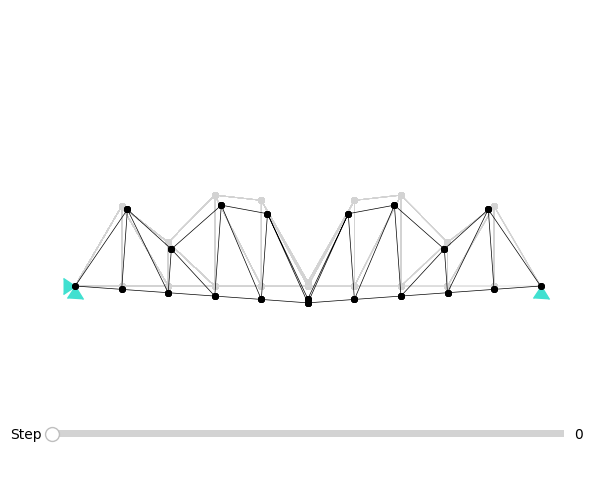

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.7292150698983014, 42.82626280870137, 55.37825849689033]
Iteration: 22, the best loss = 1898.06






































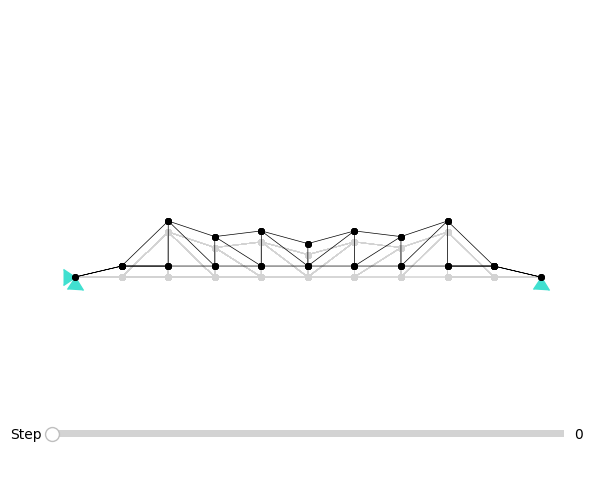

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.018110143673454433, 0.03659096377702576, 31.20115425385046]
Iteration: 23, the best loss = 1898.06






































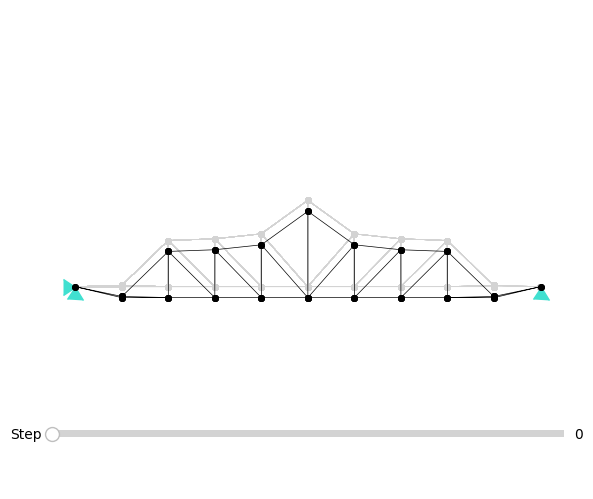

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.875392563977212, 3.9798974326287437, 52.900467388554155]
Iteration: 24, the best loss = 1898.06






































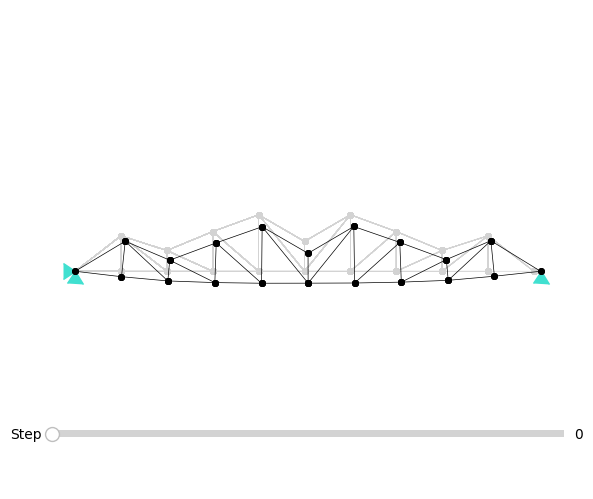

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.7358150475515135, 7.37841752196203, 14.32615123469121]
Iteration: 25, the best loss = 1647.35






































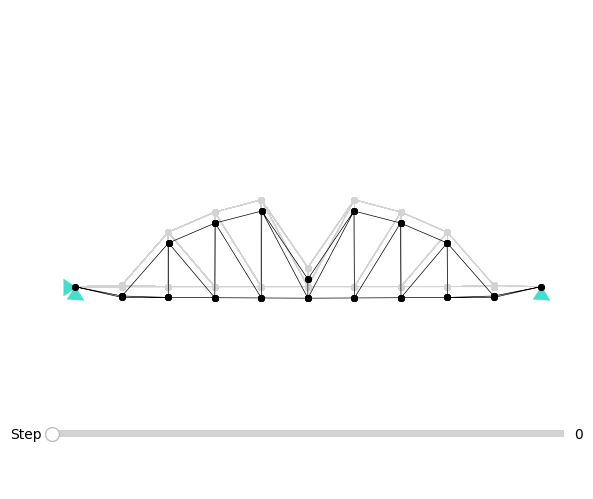

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.6735411112170648, 3.6574865281725657, 14.378996835137288]
Iteration: 26, the best loss = 1647.35






































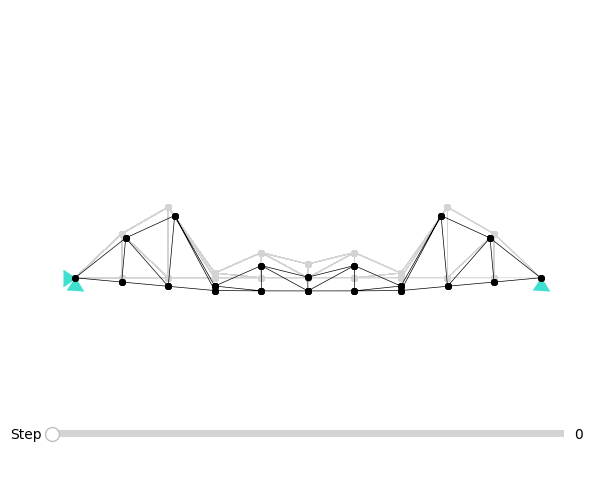

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.8405021508112402, 2.6622519170318184, 41.940677026870695]
Iteration: 27, the best loss = 1647.35






































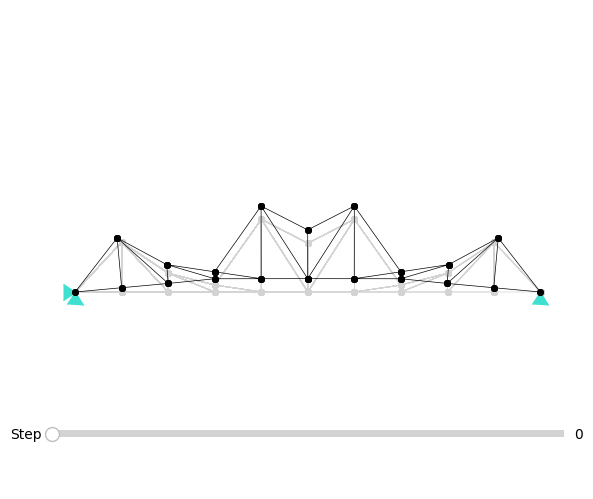

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.107891111744278, 14.088141827805236, 55.66020277304773]
Iteration: 28, the best loss = 1647.35






































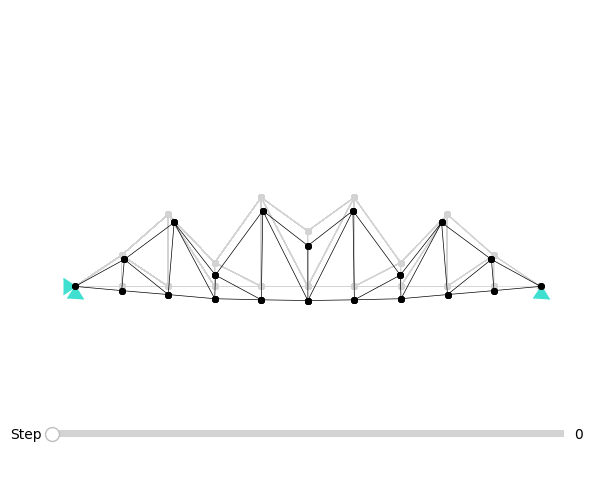

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.900936559077817, 31.17451335816377, 71.03450595251925]
Iteration: 29, the best loss = 1647.35






































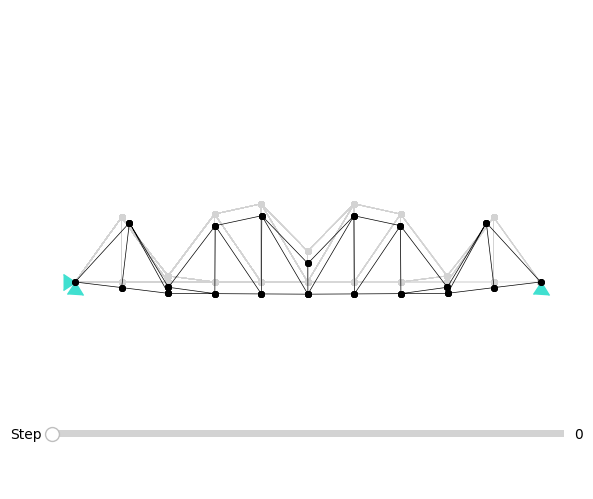

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.6219989099269174, 8.899891209131065, 32.87900157580014]
Iteration: 30, the best loss = 1647.35






































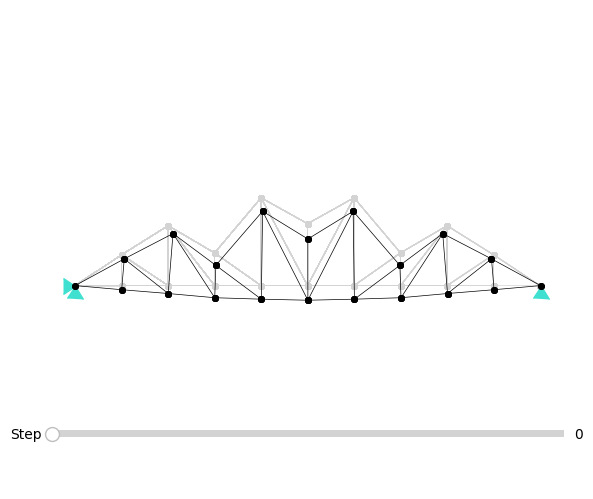

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [12.63031984798839, 46.41468302434917, 75.88230883640986]
Iteration: 31, the best loss = 1647.35






































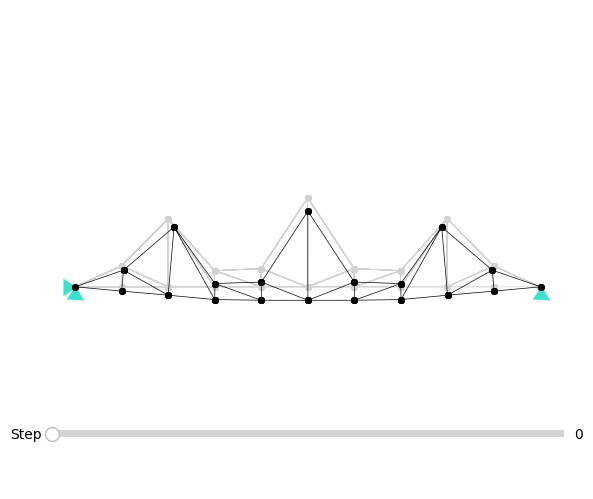

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.287639375935215, 20.45576484417527, 56.48139895633348]
Iteration: 32, the best loss = 1647.35






































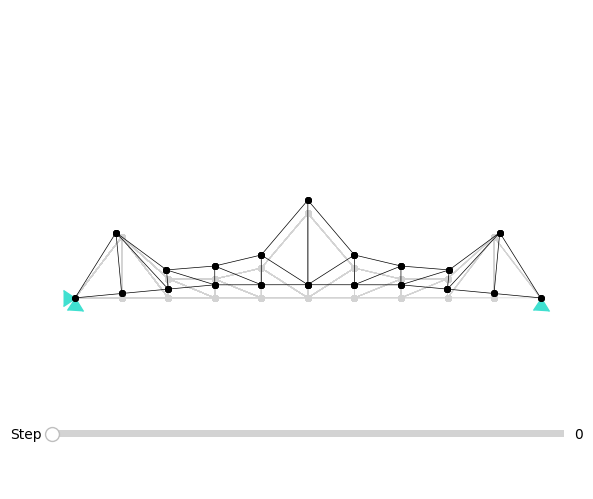

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.119606335174116, 6.985703150335433, 73.68216143326563]
Iteration: 33, the best loss = 1647.35






































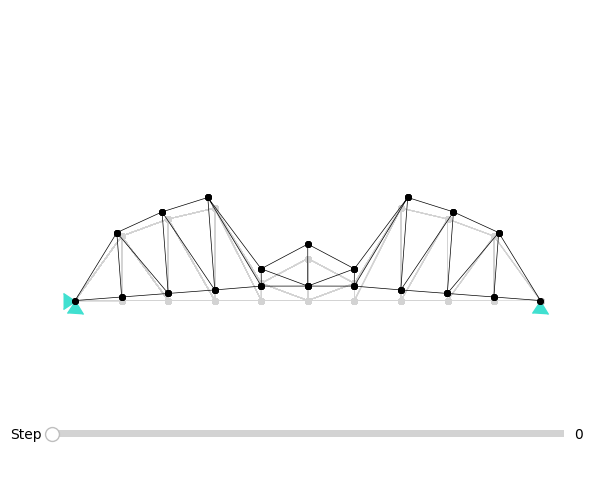

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.1770010531006525, 29.605523161637926, 60.895869557573576]
Iteration: 34, the best loss = 1647.35






































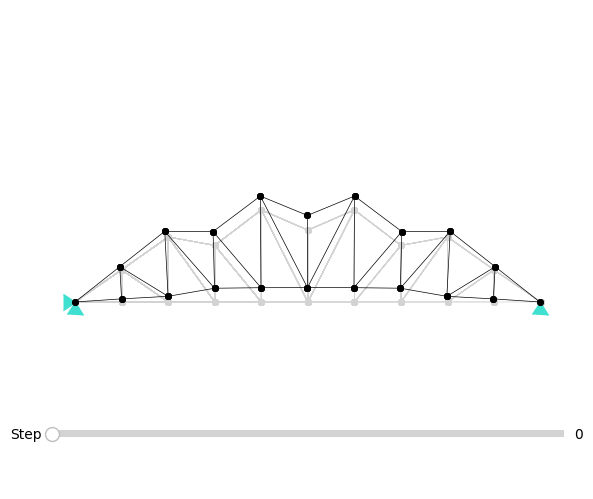

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [15.526502554698435, 55.642536864464, 64.56050840357005]
Iteration: 35, the best loss = 1647.35






































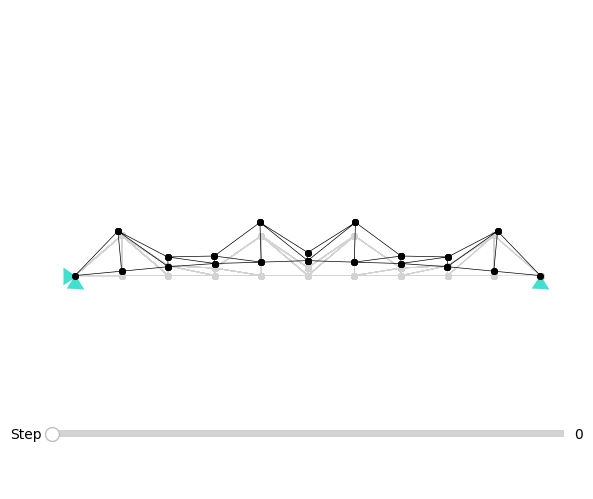

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.7237069585142857, 15.448430160419697, 31.04639451725513]
Iteration: 36, the best loss = 1647.35






































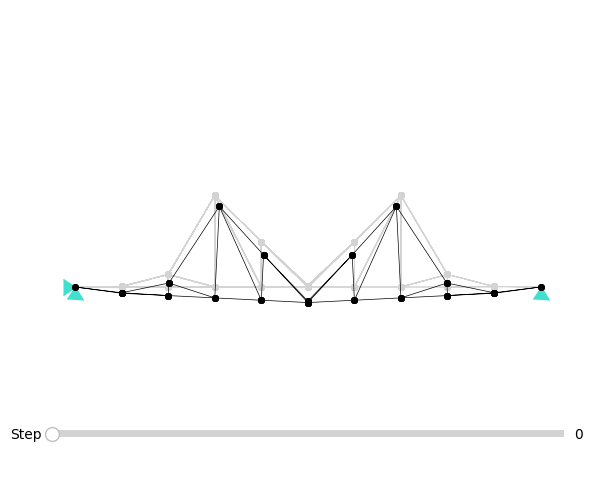

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.6607806313374079, 2.238470793247913, 3.3073650376436134]
Iteration: 37, the best loss = 1647.35






































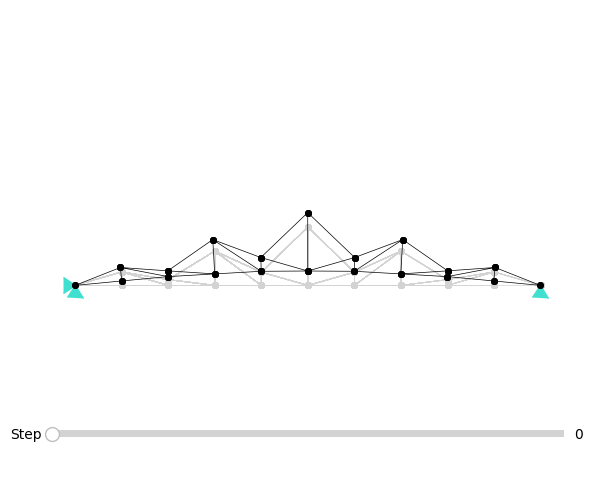

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.3738165904189703, 13.069065562171321, 29.96422238021267]
Iteration: 38, the best loss = 1647.35






































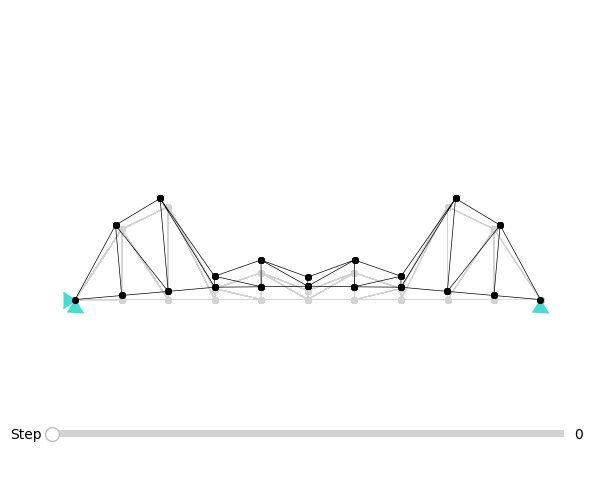

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.25660766707272, 10.794377947327222, 43.01432967751878]
Iteration: 39, the best loss = 1647.35






































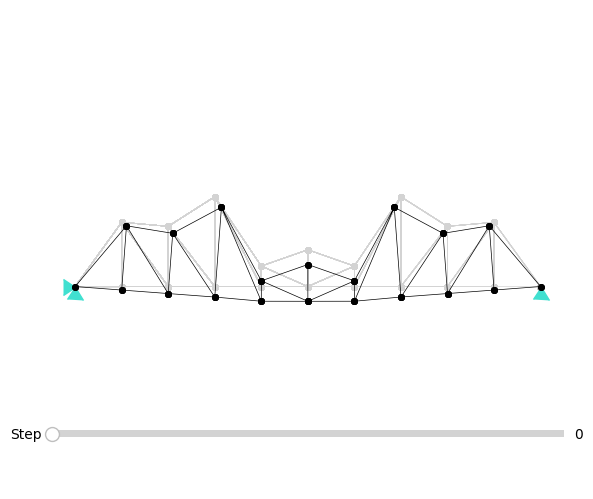

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.1888737270508924, 26.723646581482832, 65.48340591558055]
Iteration: 40, the best loss = 1647.35






































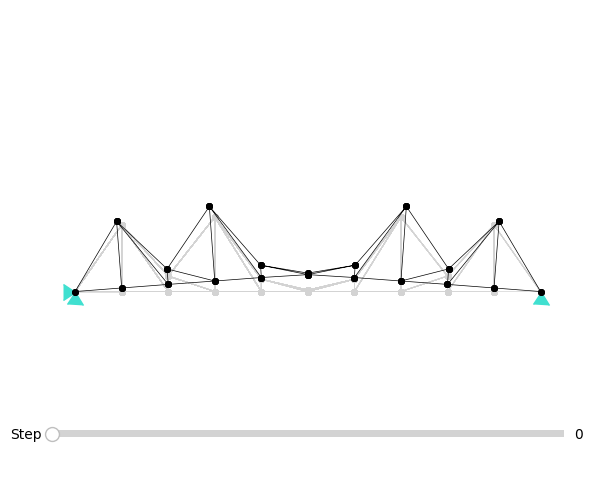

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.978880202252954, 9.445386405482918, 16.59700050082829]
Iteration: 41, the best loss = 1647.35






































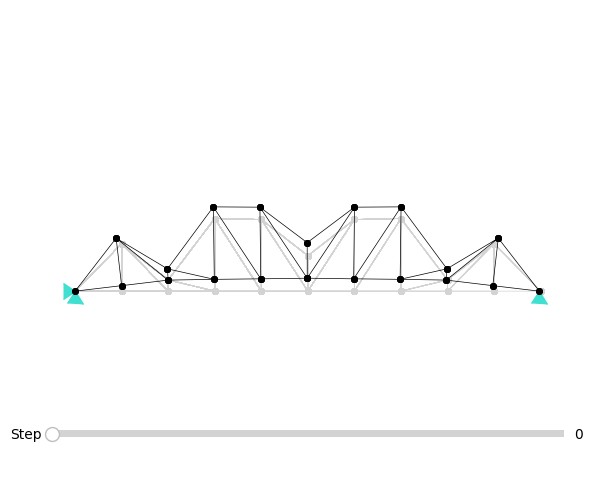

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [7.552873176701151, 19.77733939552281, 41.258796172352525]
Iteration: 42, the best loss = 1647.35






































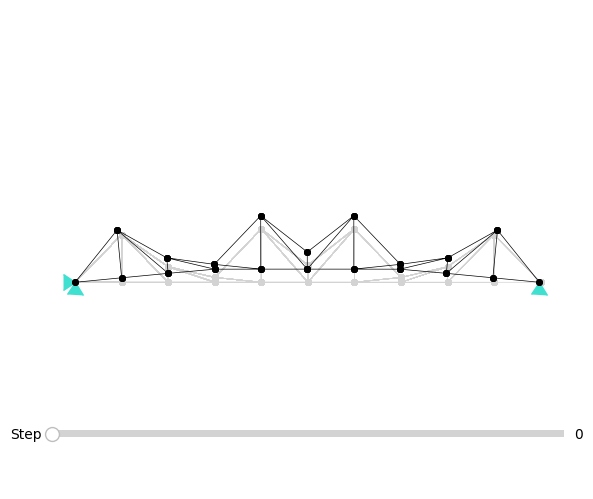

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.6745734724737801, 2.4535808022899537, 7.02650352893152]
Iteration: 43, the best loss = 1647.35






































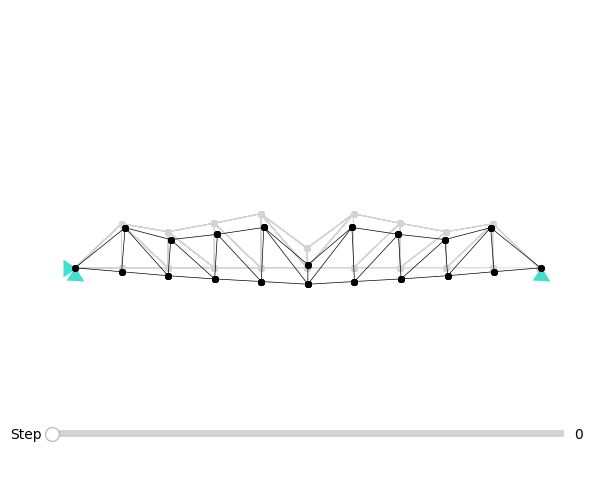

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [11.738153808710887, 48.5988907775079, 61.435628716134396]
Iteration: 44, the best loss = 1643.39






































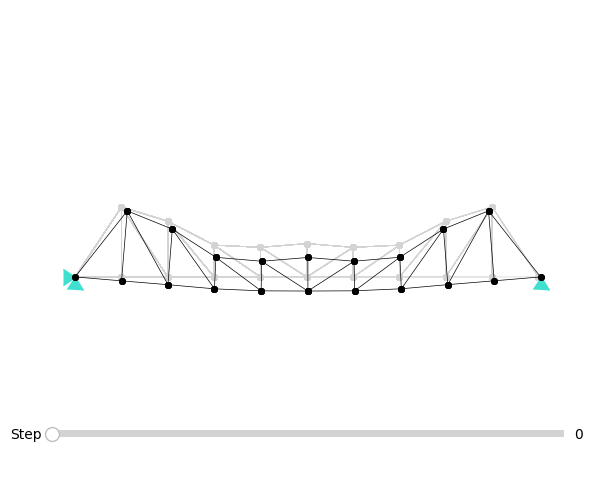

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [13.544697261372555, 46.23364283198926, 61.803704763610504]
Iteration: 45, the best loss = 1643.39






































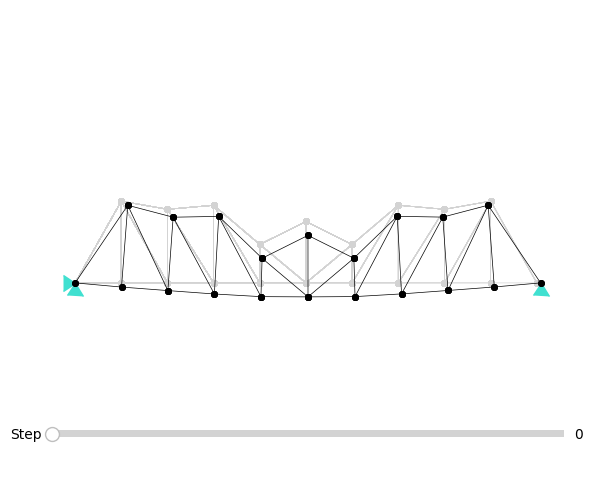

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [12.383265120198336, 32.70011616787022, 56.74460058727376]
Iteration: 46, the best loss = 1643.39






































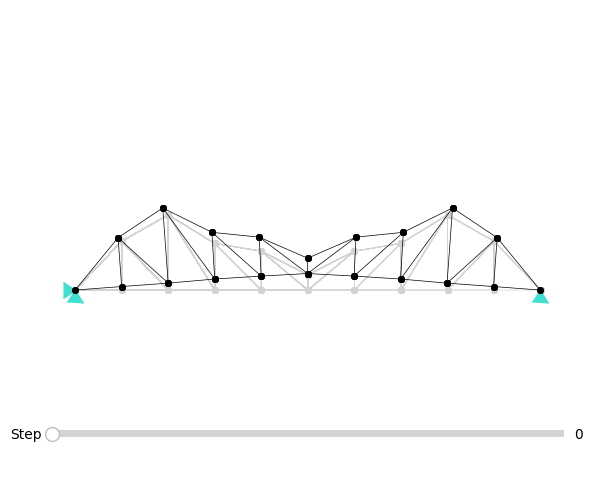

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.073500994478563, 63.33059780924422, 73.97553670159309]
Iteration: 47, the best loss = 1643.39






































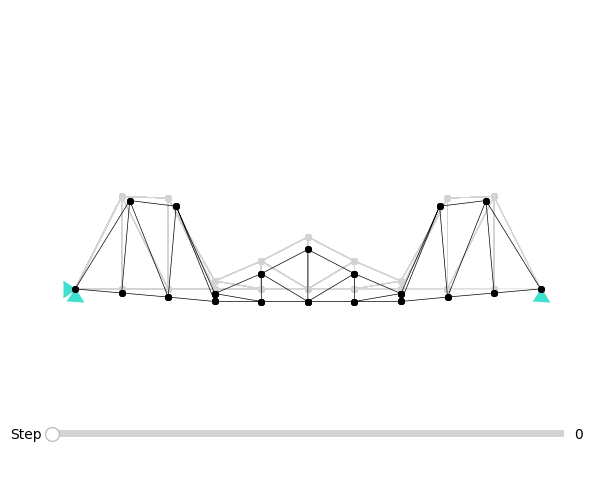

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.0225524435360844, 3.3148373666728506, 31.62169133229412]
Iteration: 48, the best loss = 1643.39






































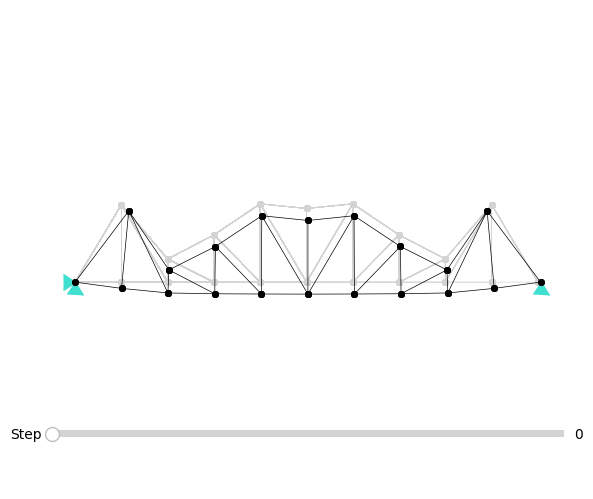

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [11.01452292845356, 27.33952491635524, 37.06483508416307]
Iteration: 49, the best loss = 1643.39






































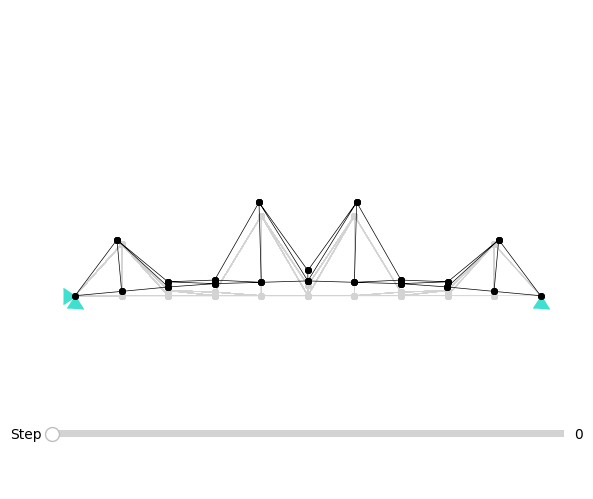

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.6205942423997601, 6.350455506636771, 13.165065708652952]
Iteration: 50, the best loss = 1643.39






































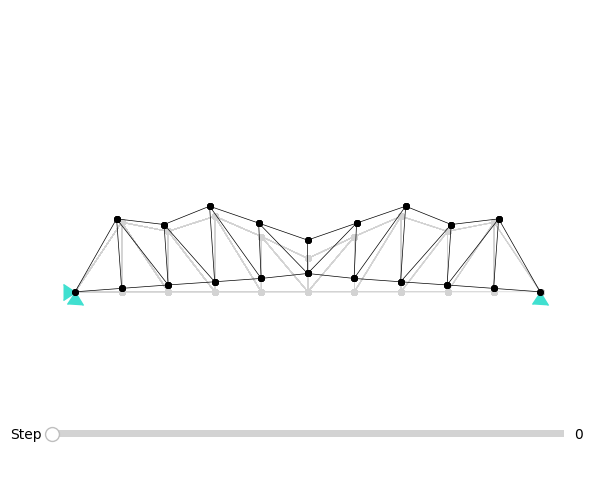

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.191488590282496, 33.3144655041299, 46.23804635530366]
Iteration: 51, the best loss = 1643.39






































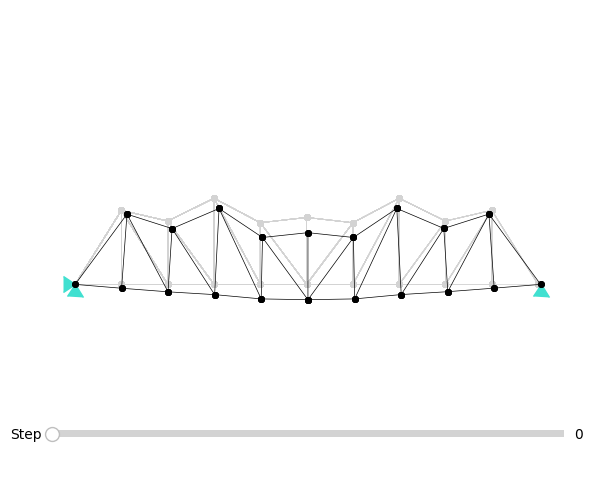

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [21.594740584294282, 54.023368160257874, 78.93538522165521]
The total loss is:1071.8543958506284
Iteration: 52, the best loss = 1071.85






































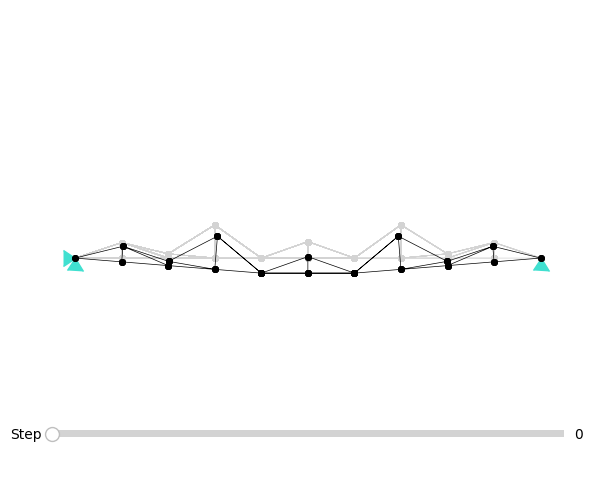

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.003681398133529132, 0.022105182923441834, 19.048771662187374]
Iteration: 53, the best loss = 1071.85






































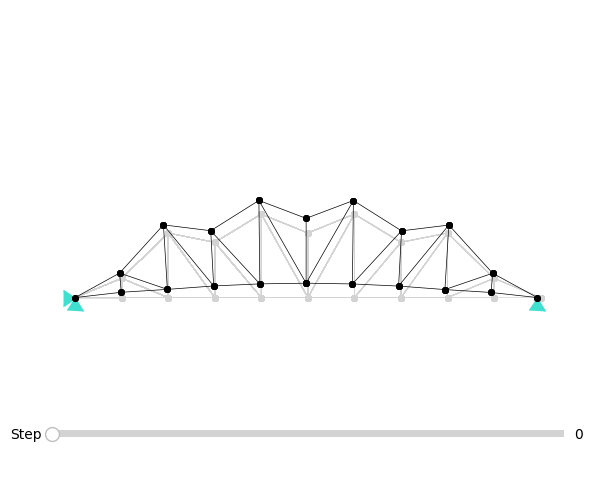

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.340729460068395, 27.57670507421414, 36.104579788503024]
Iteration: 54, the best loss = 1071.85






































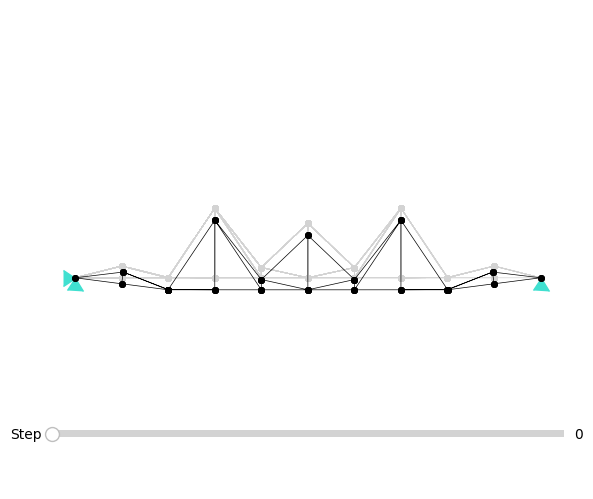

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.22804898716698901, 0.5626952273164303, 13.92518436019316]
Iteration: 55, the best loss = 1071.85






































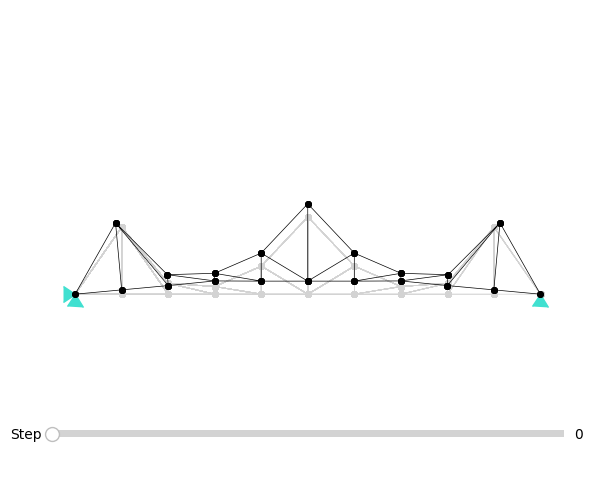

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.7097937142226267, 12.793805887745004, 33.49297812500896]
Iteration: 56, the best loss = 1071.85






































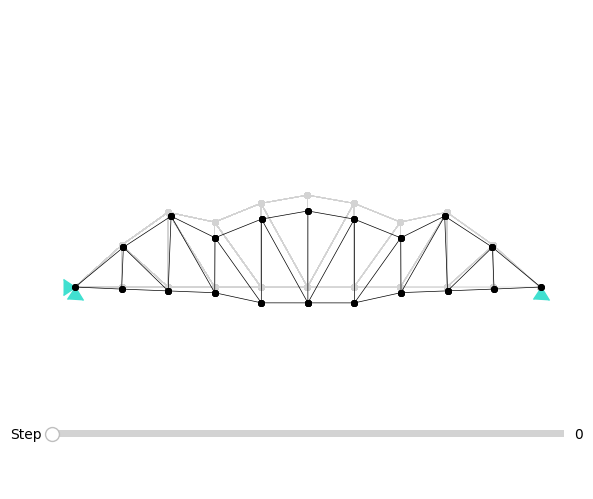

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.744068228025604, 23.45644302468128, 46.37279784466767]
Iteration: 57, the best loss = 1071.85






































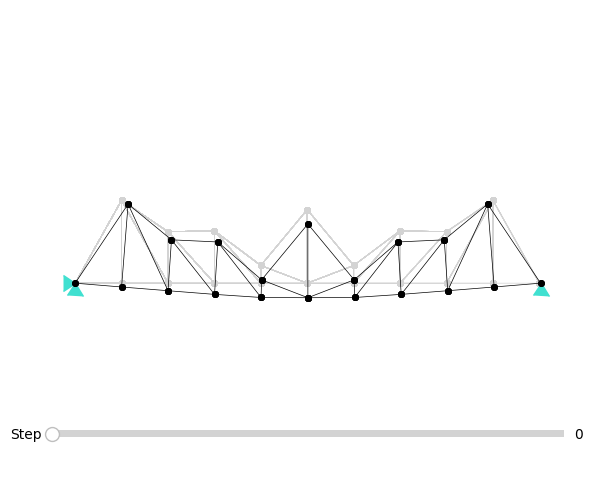

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.35191761654719, 42.19887295349735, 47.14178909351795]
Iteration: 58, the best loss = 1071.85






































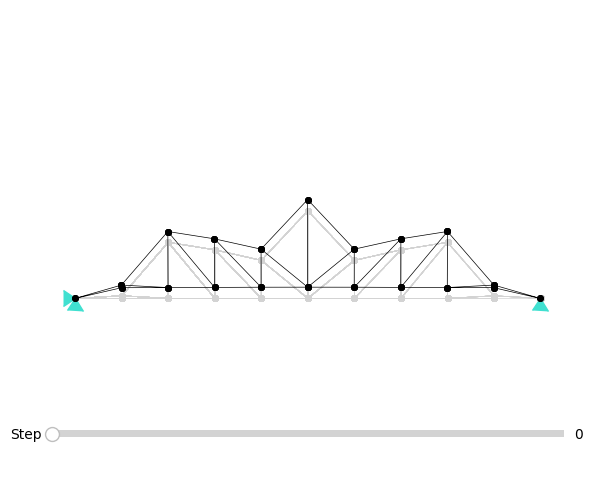

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.344808248966492, 9.049700197279288, 50.41704028715712]
Iteration: 59, the best loss = 1071.85






































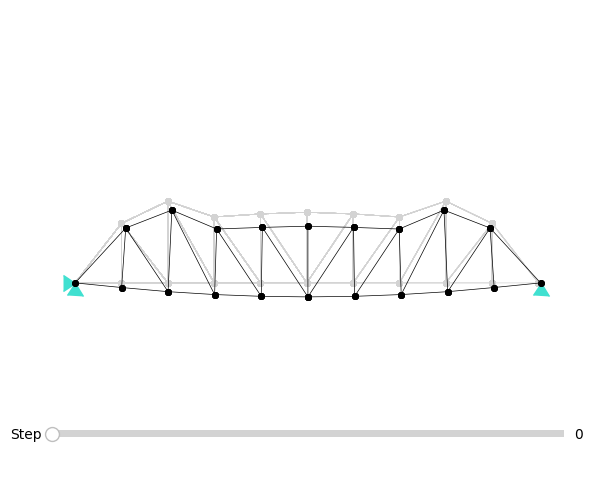

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [22.784227377810915, 70.75796774866653, 77.35377955343863]
The total loss is:1217.9666928308864
Iteration: 60, the best loss = 1071.85






































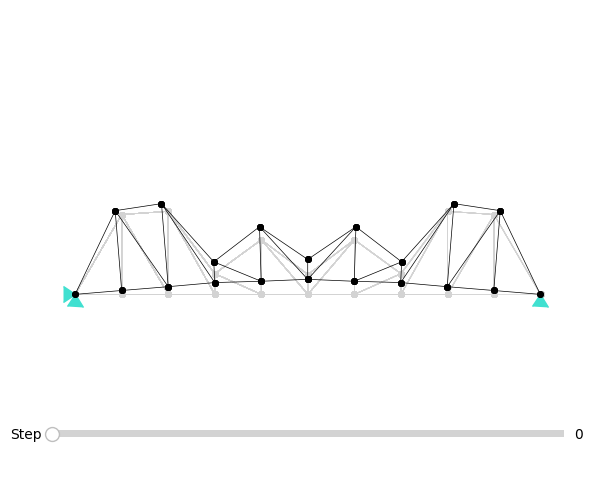

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.346322697170551, 23.618428276129865, 53.2355894981632]
Iteration: 61, the best loss = 1071.85






































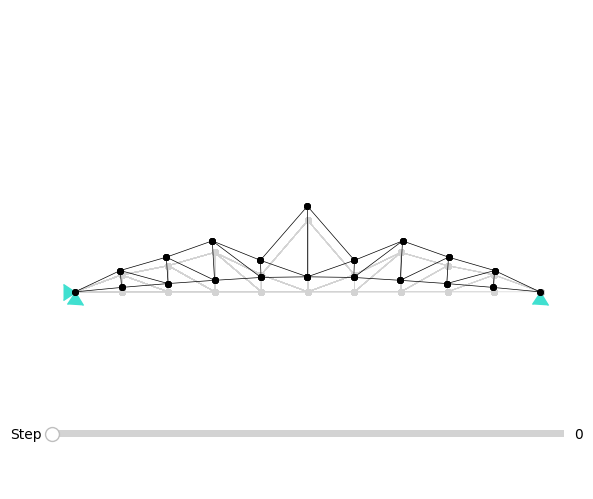

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [9.581170669867934, 42.573717243480075, 67.52878109808873]
Iteration: 62, the best loss = 1071.85






































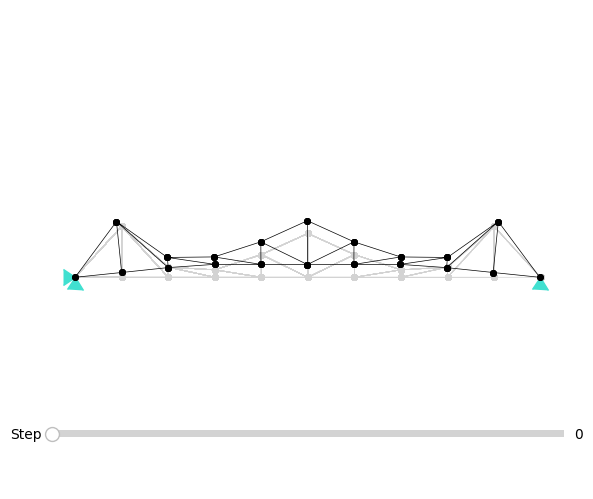

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.966379501704352, 13.308085099381906, 48.32955233930288]
Iteration: 63, the best loss = 1071.85






































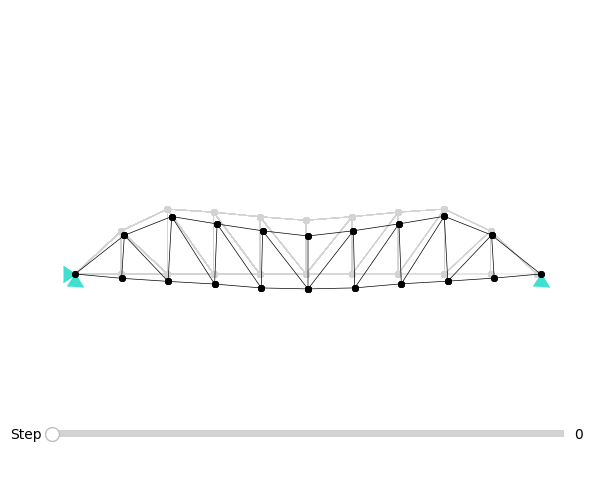

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [26.90696478681721, 65.8297484575589, 93.03311399045397]
The total loss is:1362.9374049376588
Iteration: 64, the best loss = 1071.85






































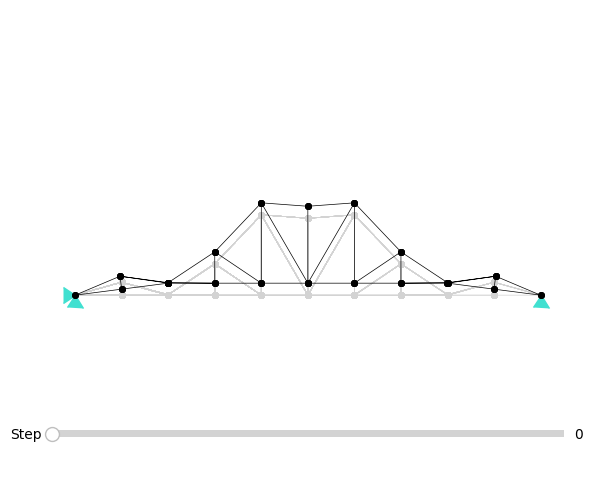

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.3934383380341108, 1.0035677427576657, 53.97256782182964]
Iteration: 65, the best loss = 1071.85






































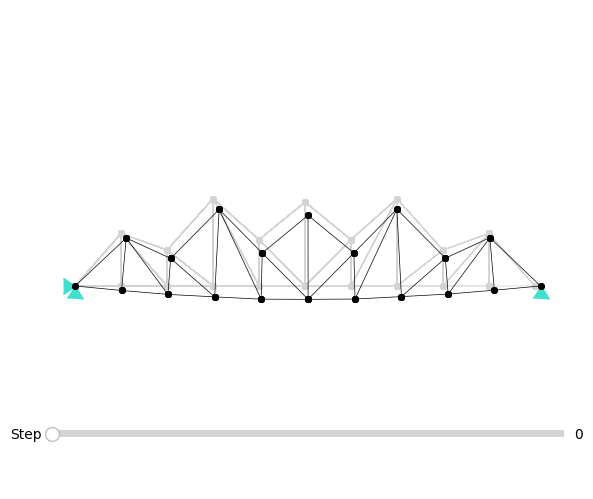

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.519976805210897, 26.600148950437326, 45.08478459882727]
Iteration: 66, the best loss = 1071.85






































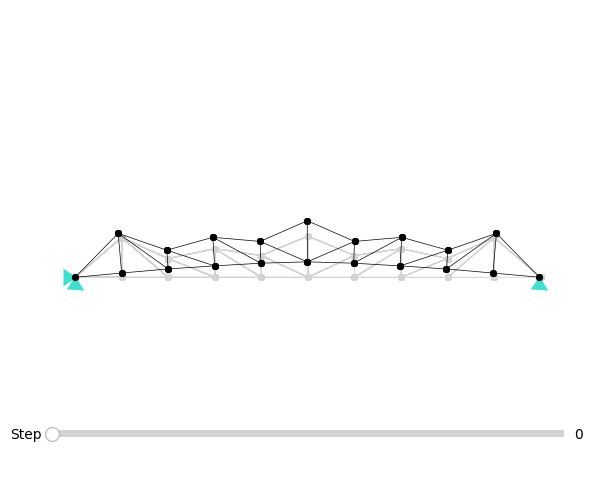

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [9.590433430599623, 39.981746264539765, 60.45689825382816]
Iteration: 67, the best loss = 1071.85






































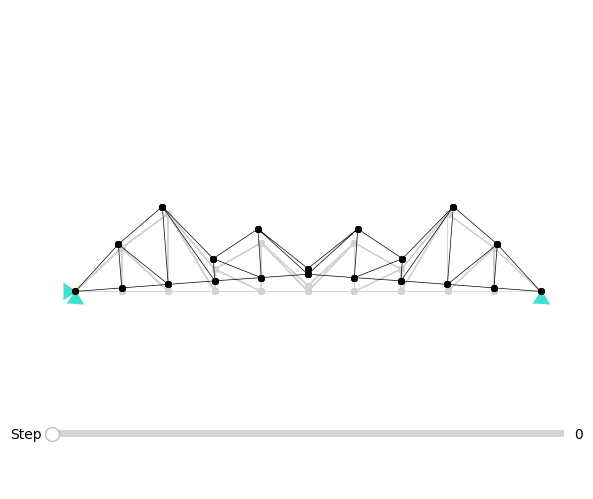

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.766824869148704, 29.81476164008651, 46.858728047572676]
Iteration: 68, the best loss = 1071.85






































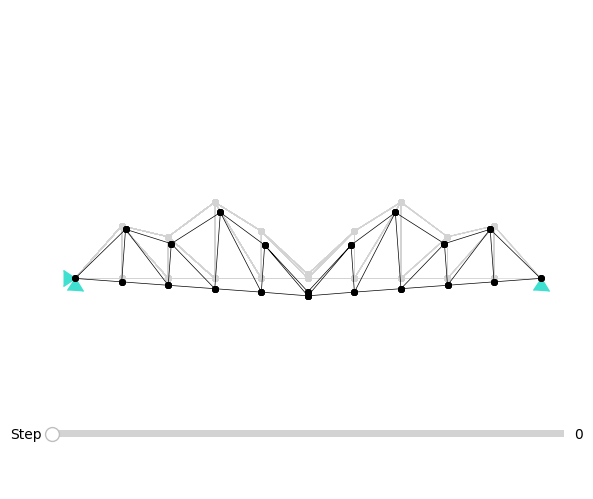

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.6779217280519927, 51.64063070522254, 69.85764925199726]
Iteration: 69, the best loss = 1071.85






































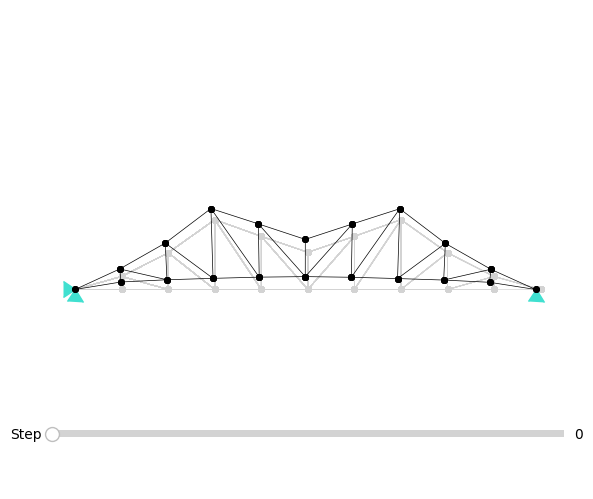

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.099490363630467, 27.849041939466126, 47.30537652737472]
Iteration: 70, the best loss = 1071.85






































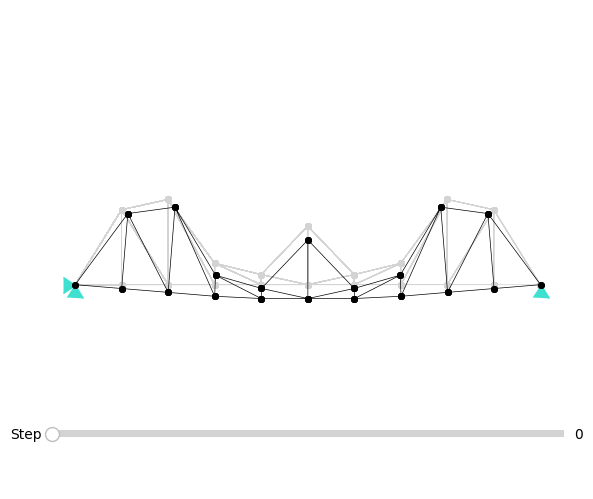

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.339105798578908, 22.221037929215292, 65.63826866856537]
Iteration: 71, the best loss = 1071.85






































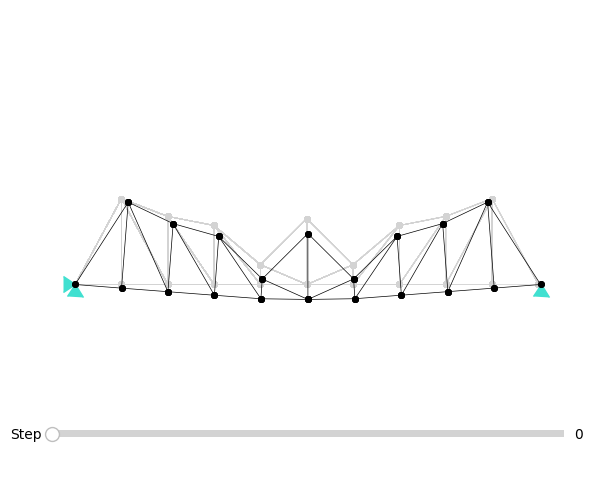

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.7172088488776196, 12.225977505527531, 21.166776214037824]
Iteration: 72, the best loss = 1071.85






































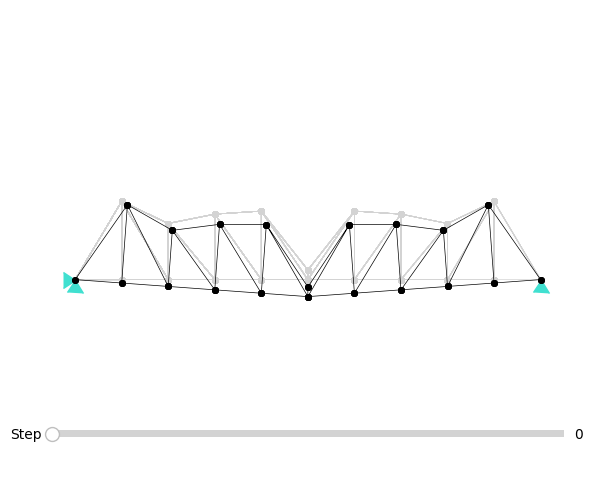

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.8285805583706576, 29.029539547543777, 32.51963989825166]
Iteration: 73, the best loss = 1071.85






































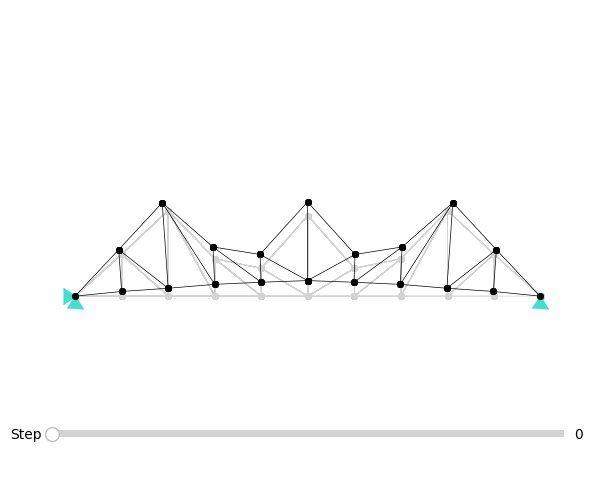

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.749600568048044, 28.67856499112088, 41.19258671745935]
Iteration: 74, the best loss = 1071.85






































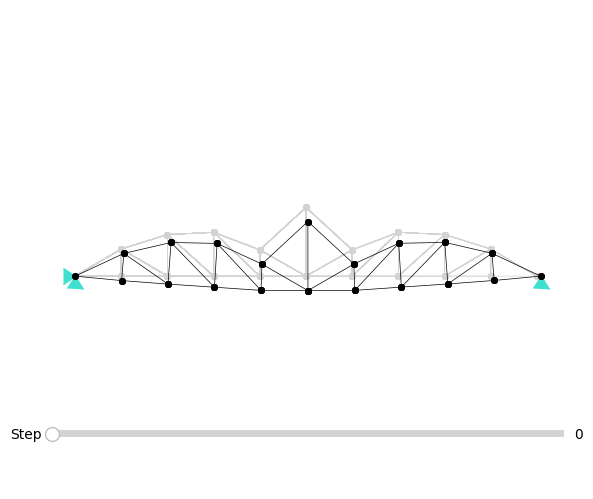

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [9.410167586661842, 33.77822533472624, 48.295507451280336]
Iteration: 75, the best loss = 1071.85






































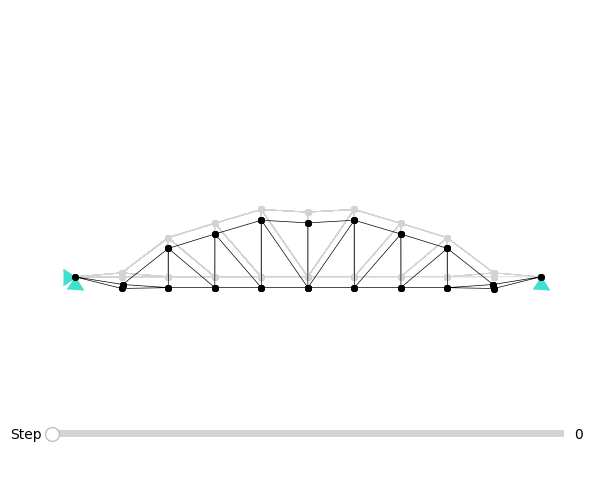

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.949618848051869, 10.213166806484978, 70.42105451844898]
Iteration: 76, the best loss = 1071.85






































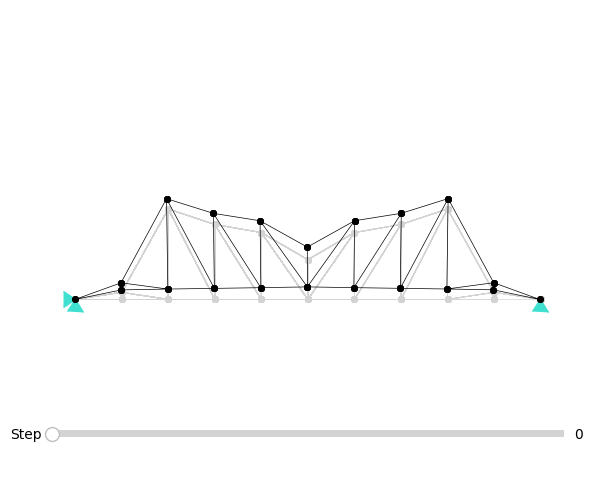

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.756565959728363, 19.704009794950302, 49.842514320940445]
Iteration: 77, the best loss = 1071.85






































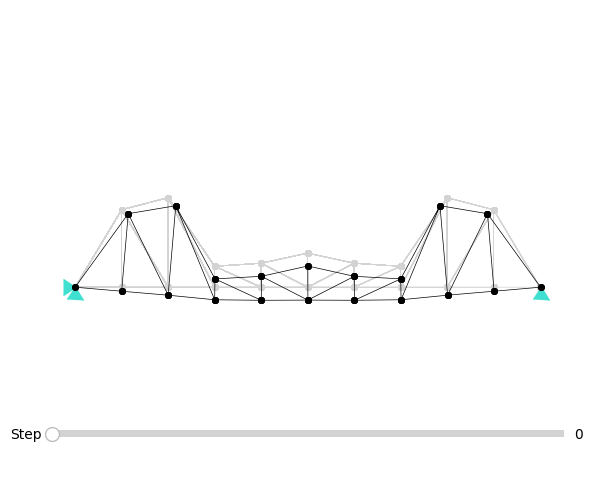

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.523707677380686, 19.89516019605729, 50.219148470747854]
Iteration: 78, the best loss = 1071.85






































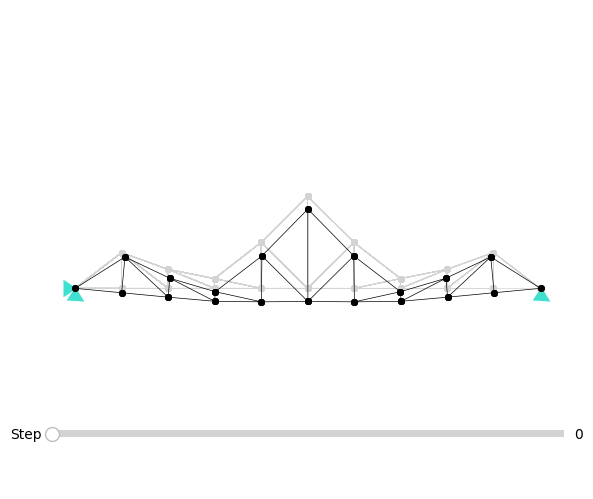

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [7.3698025622748355, 22.76073145643222, 70.40042331755282]
Iteration: 79, the best loss = 1071.85






































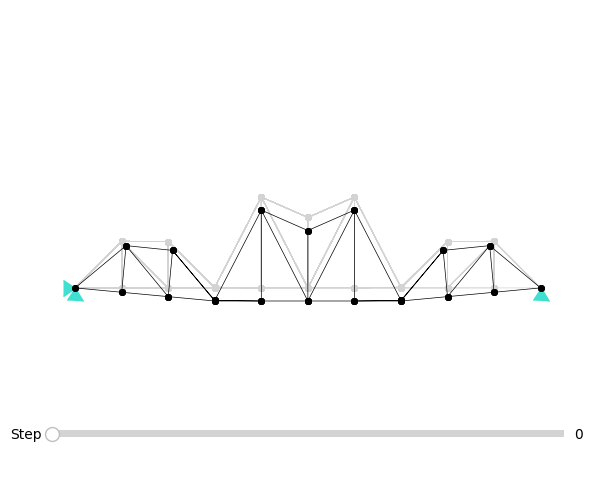

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.03825488743484639, 0.11197622064815448, 24.863284792598115]
Iteration: 80, the best loss = 1071.85






































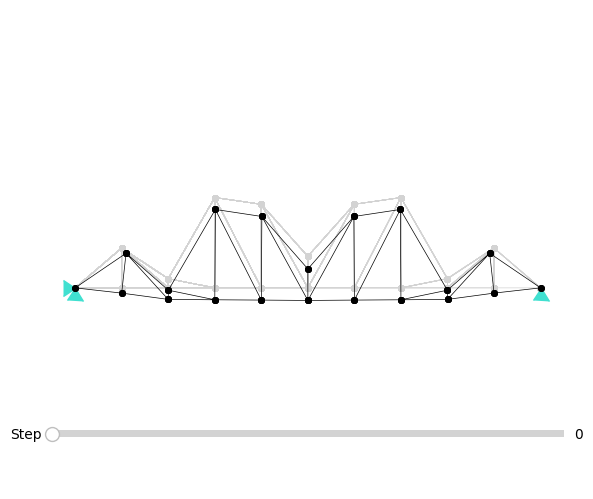

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.6988406463634282, 9.849582126118861, 36.95629168498868]
Iteration: 81, the best loss = 1071.85






































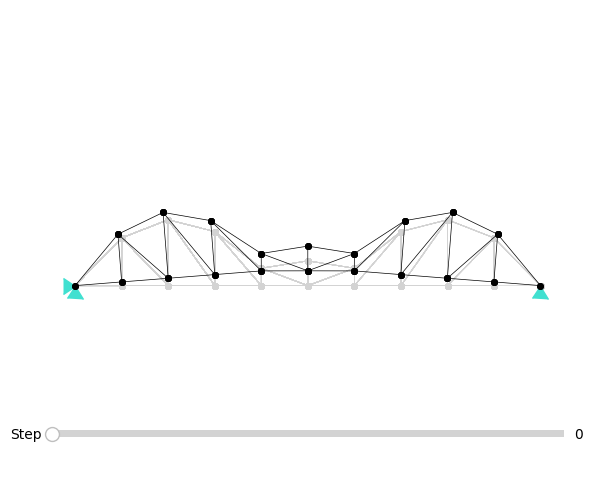

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.829261849952373, 28.03789096804428, 71.37056717385497]
Iteration: 82, the best loss = 1071.85






































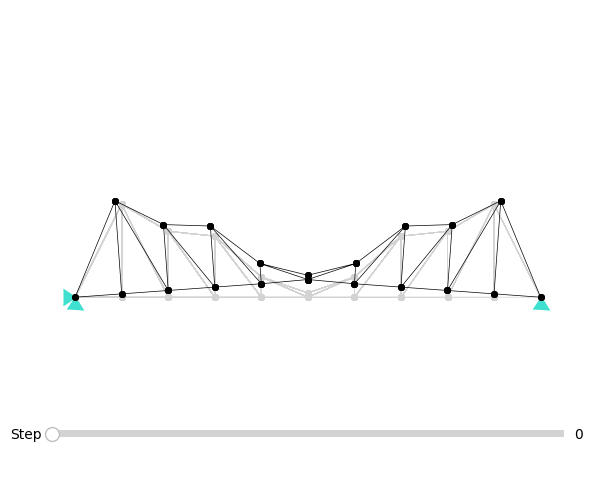

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.8796251259992488, 17.451962260390058, 44.21562667269517]
Iteration: 83, the best loss = 1071.85






































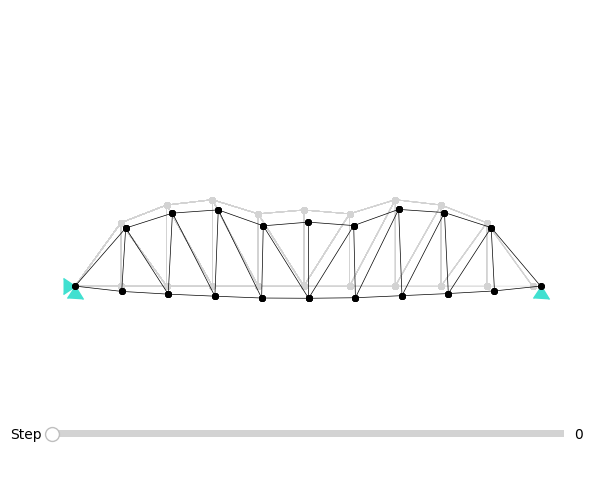

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [20.966592101915108, 40.77390719420465, 63.482574810297365]
The total loss is:1074.436400897443
Iteration: 84, the best loss = 1071.85






































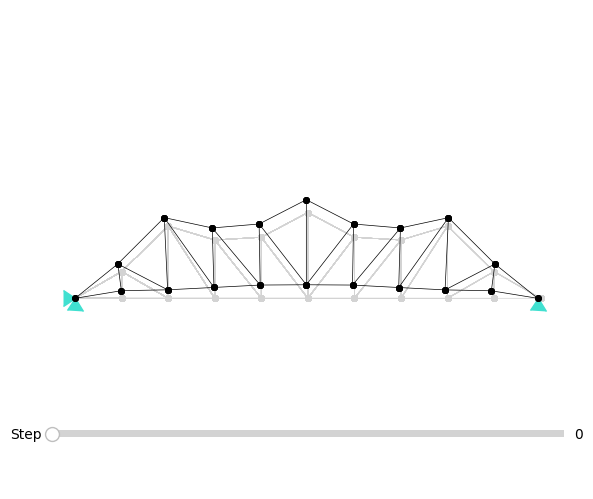

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [21.393929356688606, 58.28825174126272, 70.13445791979704]
The total loss is:1887.7479575234229
Iteration: 85, the best loss = 1071.85






































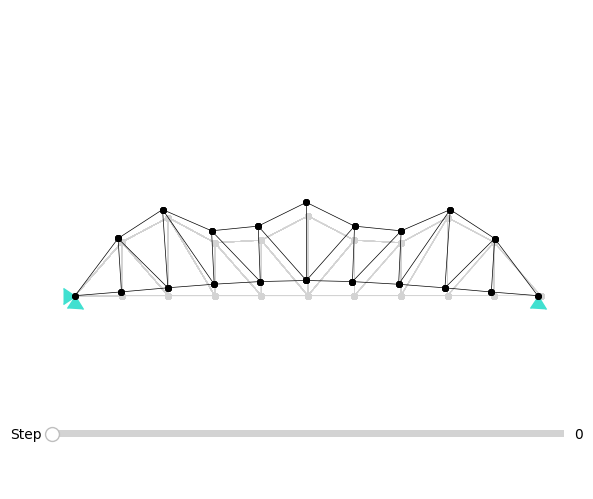

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [20.96648182732802, 58.166169406398616, 84.05083853042711]
The total loss is:1270.771354526857
Iteration: 86, the best loss = 1071.85






































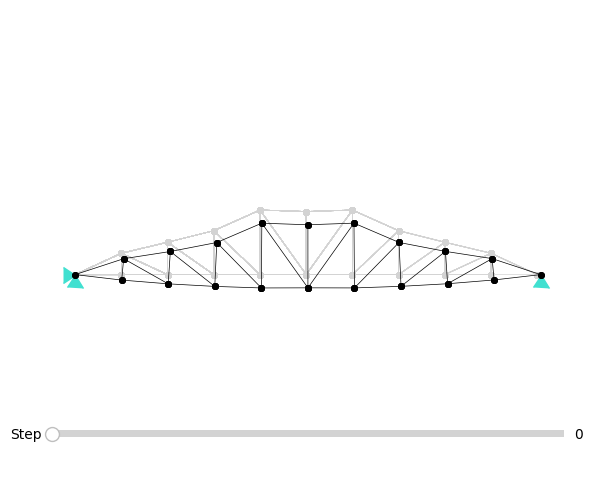

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [16.58227730747814, 51.975445489352964, 65.79127005244585]
Iteration: 87, the best loss = 1071.85






































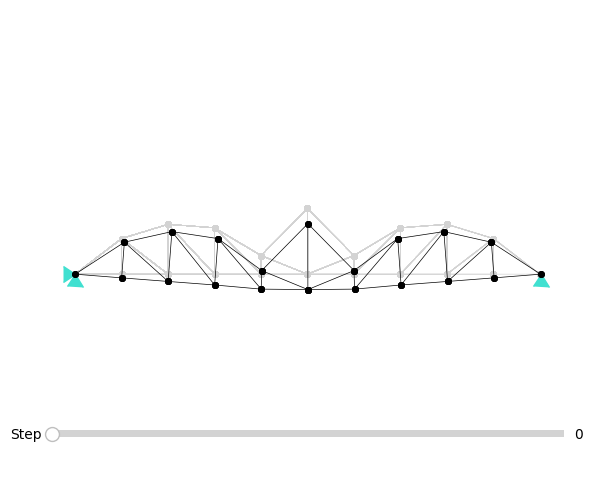

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [9.89638242752076, 59.98554556135307, 68.40867959669616]
Iteration: 88, the best loss = 1071.85






































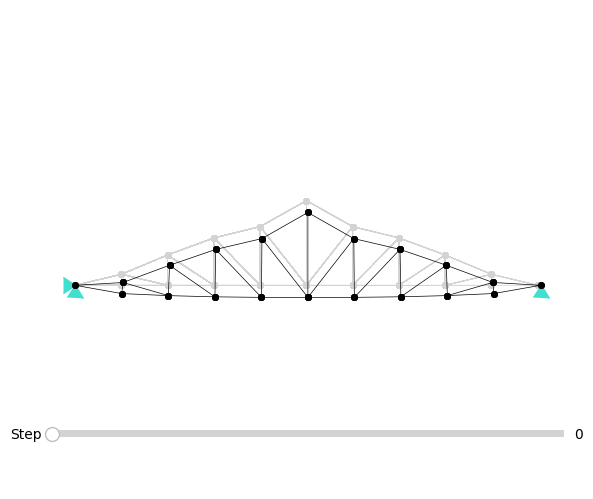

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [15.179959827055237, 38.62692016166348, 76.16191648717255]
Iteration: 89, the best loss = 1071.85






































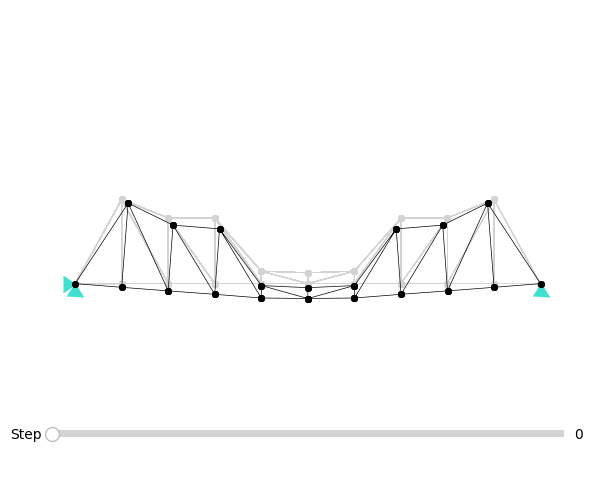

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.695699828387085, 27.018217178253607, 52.160784691317666]
Iteration: 90, the best loss = 1071.85






































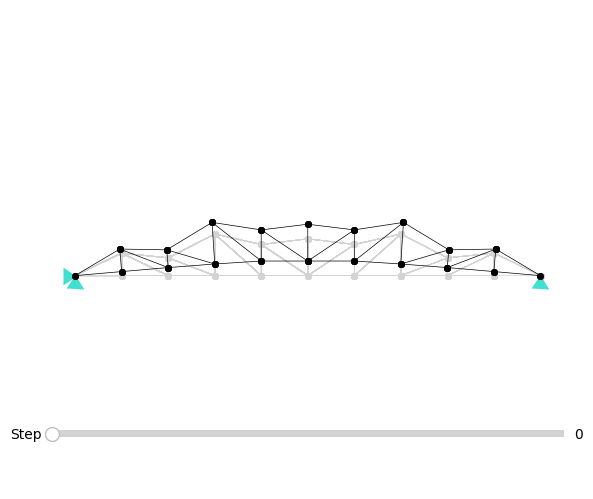

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.807253221178108, 26.630214209704246, 65.92106997645979]
Iteration: 91, the best loss = 1071.85






































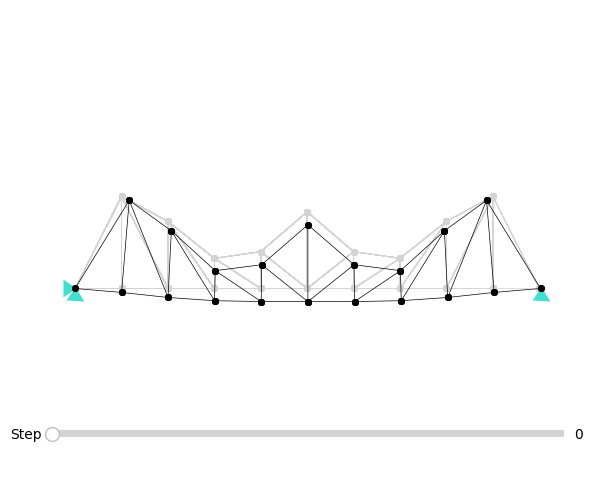

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.91419273306401, 36.97435499628939, 48.49162222032543]
Iteration: 92, the best loss = 1071.85






































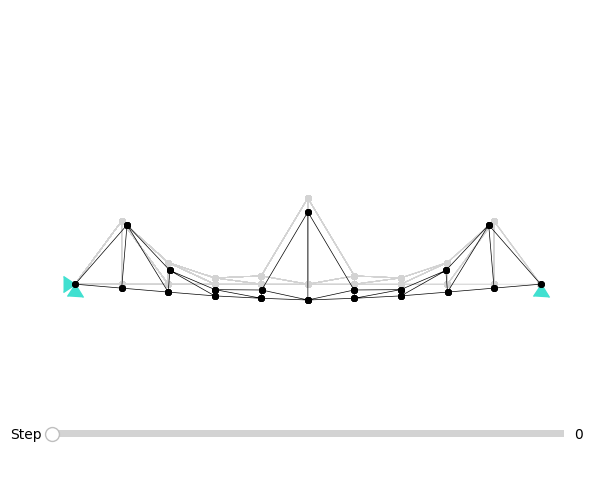

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.753097015495006, 13.245830275245508, 27.196145738603324]
Iteration: 93, the best loss = 1071.85






































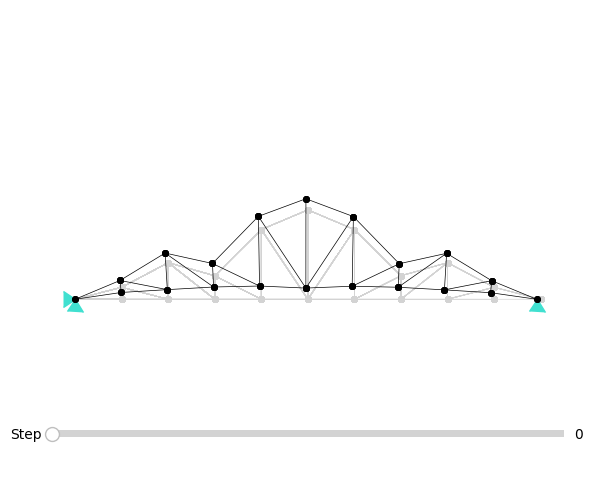

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.941807489188793, 18.884260211335516, 43.60677215133449]
Iteration: 94, the best loss = 1071.85






































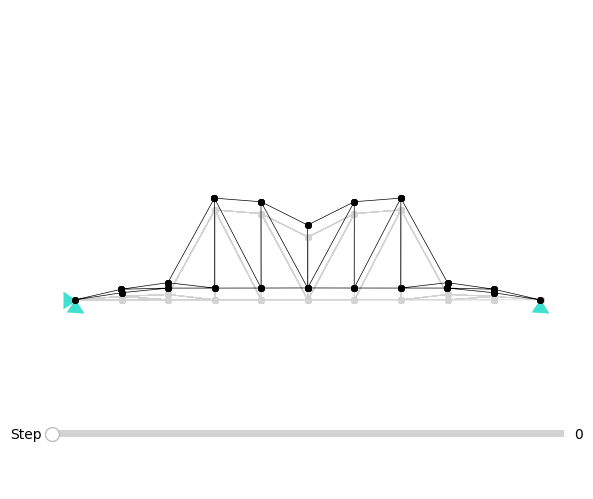

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.234699837622328, 10.200867830553978, 54.409004391676795]
Iteration: 95, the best loss = 1071.85






































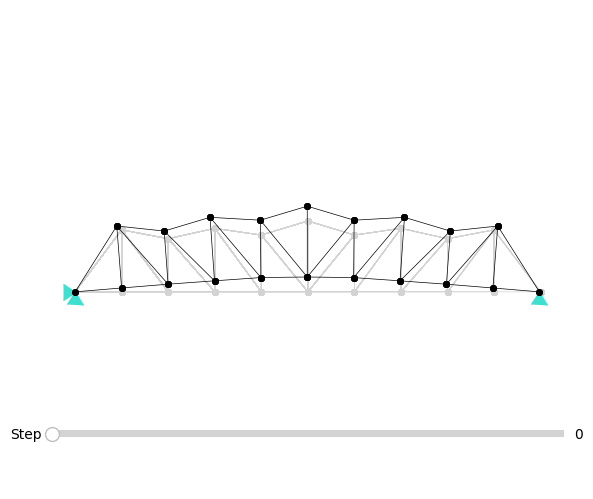

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [13.984767762240722, 46.22175124153602, 57.77301281042332]
Iteration: 96, the best loss = 1071.85






































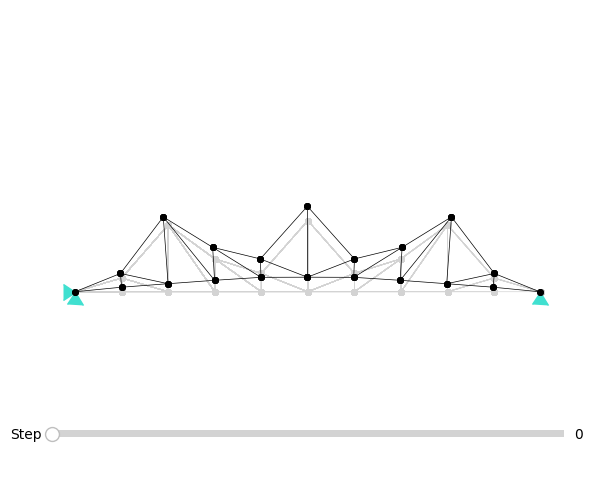

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [9.70344612311914, 39.28505451457003, 65.61771591502118]
Iteration: 97, the best loss = 1071.85






































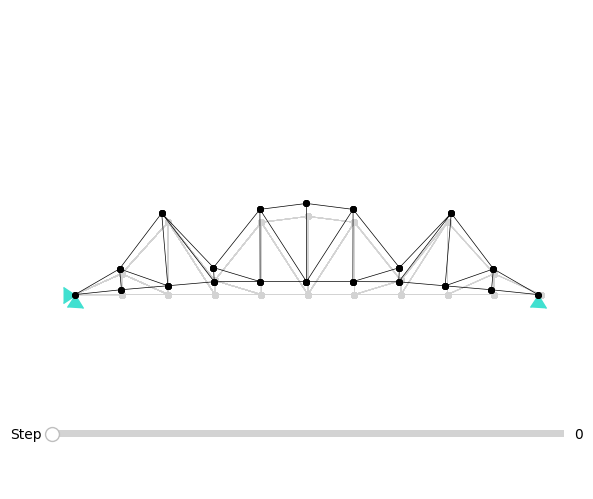

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.265530204321454, 10.208132041440058, 16.03973431858325]
Iteration: 98, the best loss = 1071.85






































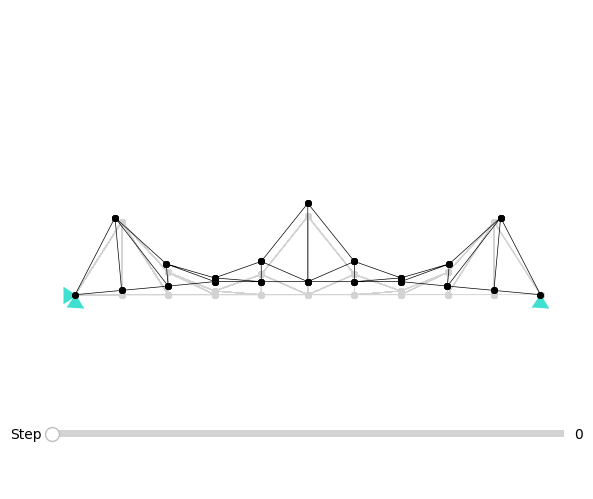

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.4590617514136346, 8.388069155143707, 67.87454498053066]
Iteration: 99, the best loss = 1071.85






































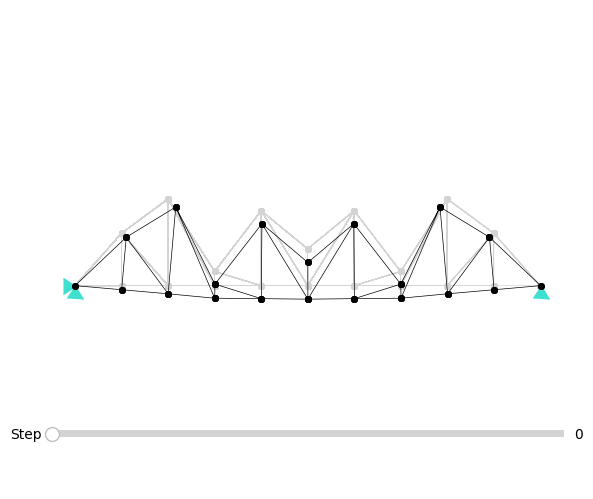

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.7915663557134014, 11.956958174593064, 31.160134764179606]
Iteration: 100, the best loss = 1071.85






































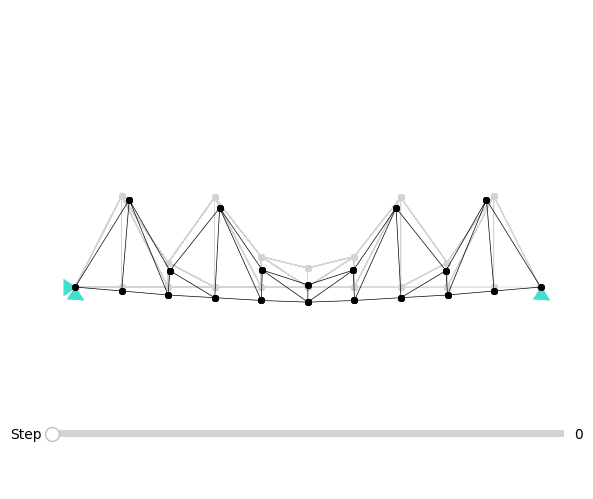

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.067106156613899, 23.950654735881567, 38.67133689525724]
Iteration: 101, the best loss = 1071.85






































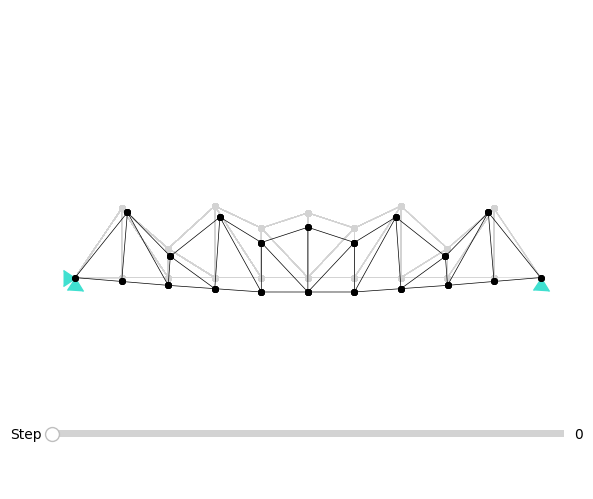

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.3179284982046378, 15.191583270436313, 37.36722566119974]
Iteration: 102, the best loss = 1071.85






































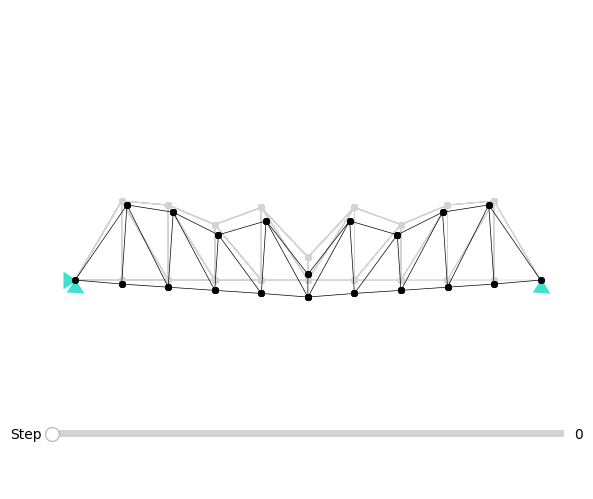

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.493602004633649, 25.175720847991133, 31.098528916743277]
Iteration: 103, the best loss = 1071.85






































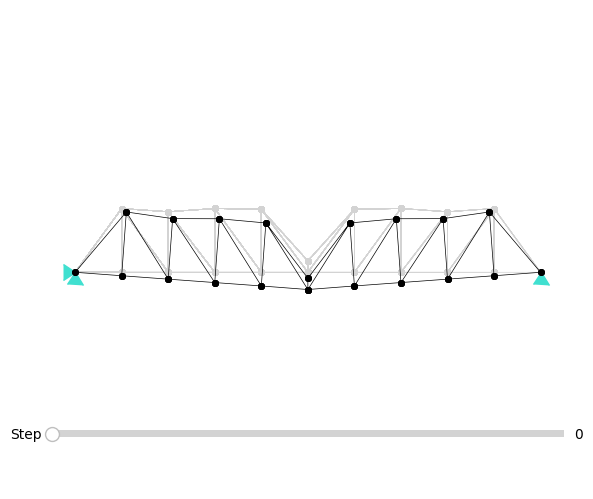

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.709241620020038, 63.46129396422393, 85.8274766041872]
Iteration: 104, the best loss = 1071.85






































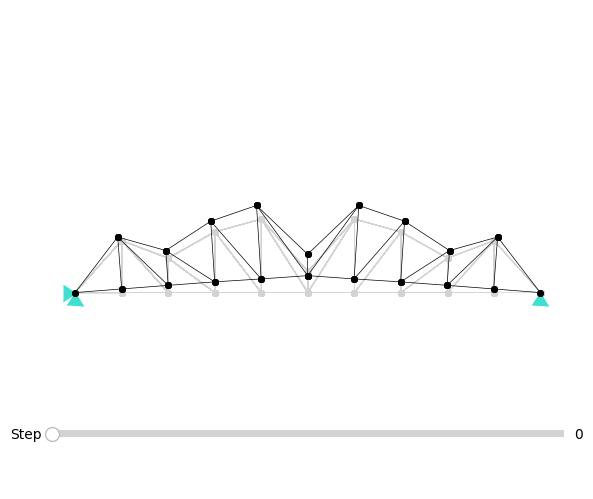

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [7.899724308424041, 51.2265461540634, 56.386093189020215]
Iteration: 105, the best loss = 1071.85






































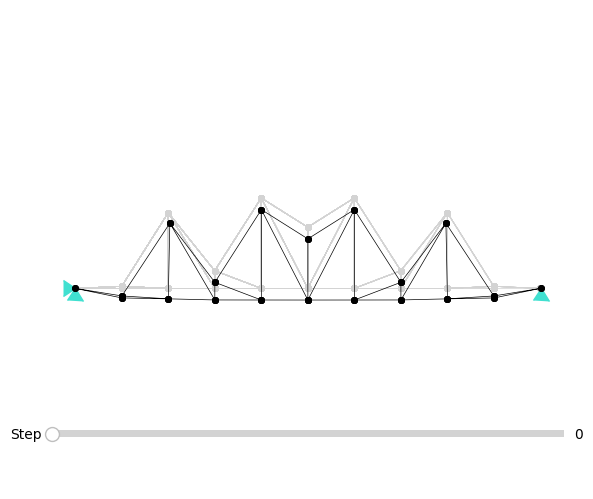

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.6958196886000967, 6.317142656265698, 20.342319147652823]
Iteration: 106, the best loss = 1071.85






































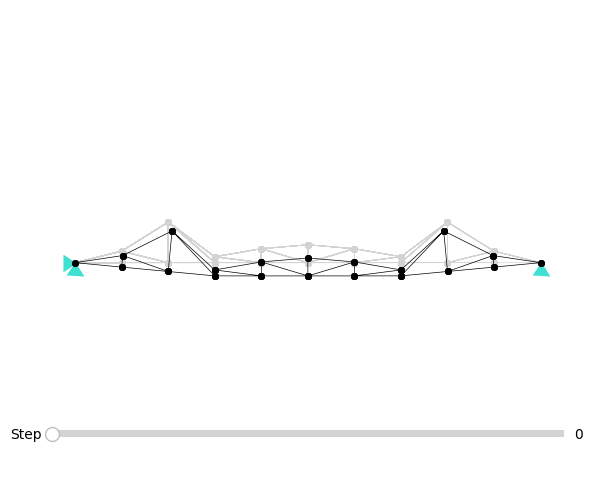

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.9708625322187266, 3.3789449537293583, 33.47527217280448]
Iteration: 107, the best loss = 1071.85






































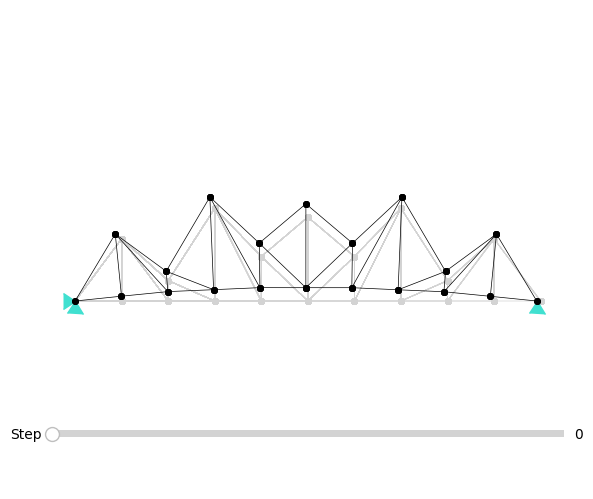

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.293446215985419, 15.699366153803515, 19.067621362991133]
Iteration: 108, the best loss = 1071.85






































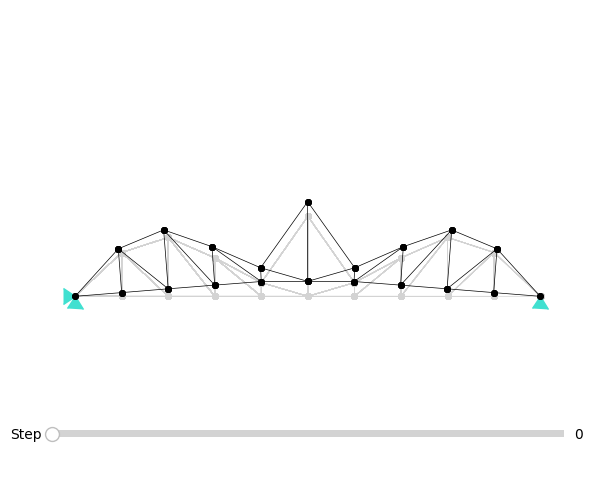

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [7.3141056796458965, 37.73187850990275, 73.98071982697185]
Iteration: 109, the best loss = 1071.85






































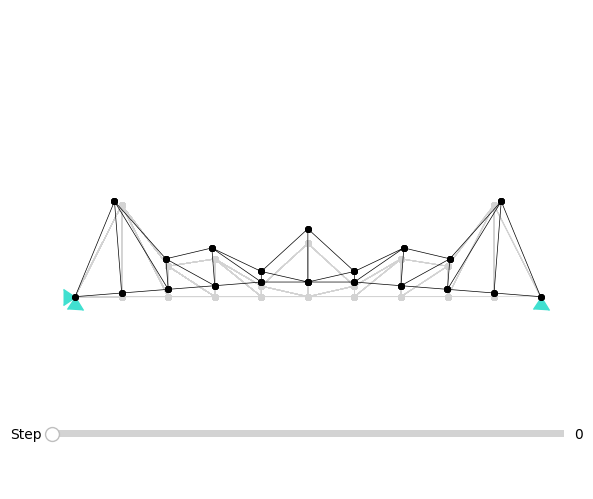

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.643783230217021, 9.898046116816886, 53.6748333280852]
Iteration: 110, the best loss = 1071.85






































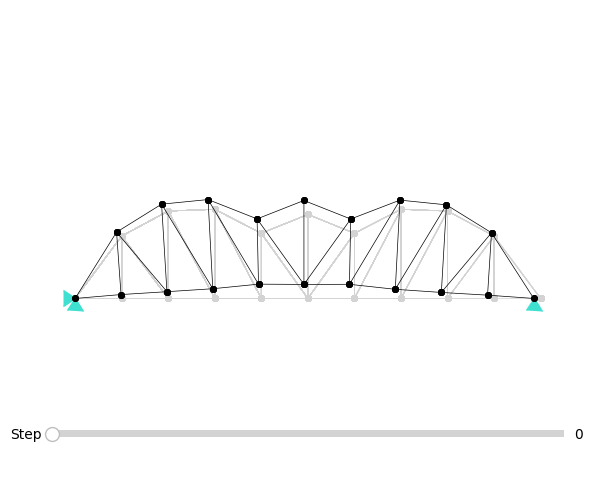

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [14.245715333038698, 26.043602342271086, 56.46182713199702]
Iteration: 111, the best loss = 1071.85






































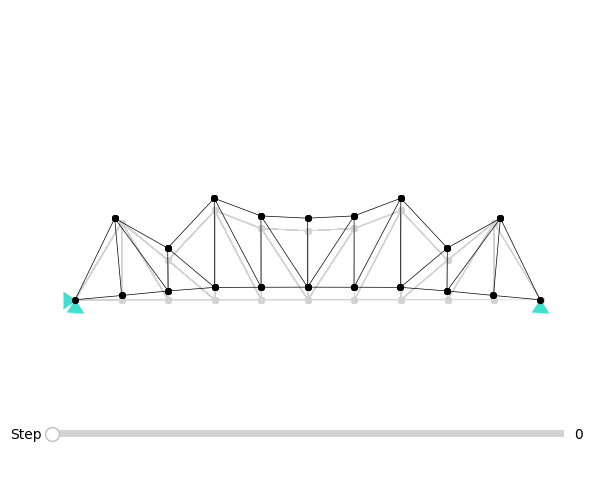

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.48766406343433, 20.774338449709873, 42.32382635628411]
Iteration: 112, the best loss = 1071.85






































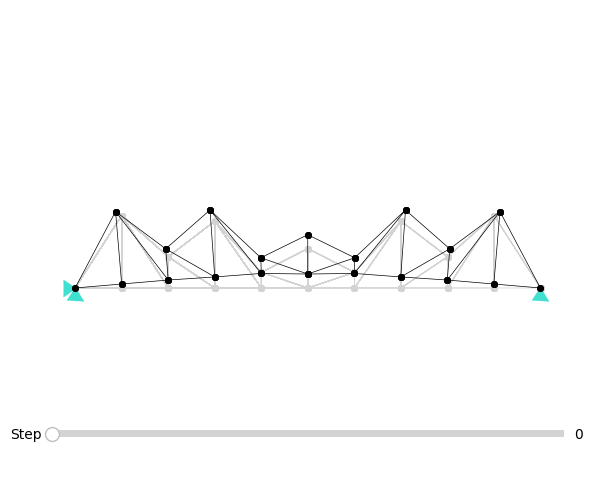

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.422109920368242, 21.590236784908367, 45.31320081710007]
Iteration: 113, the best loss = 1071.85






































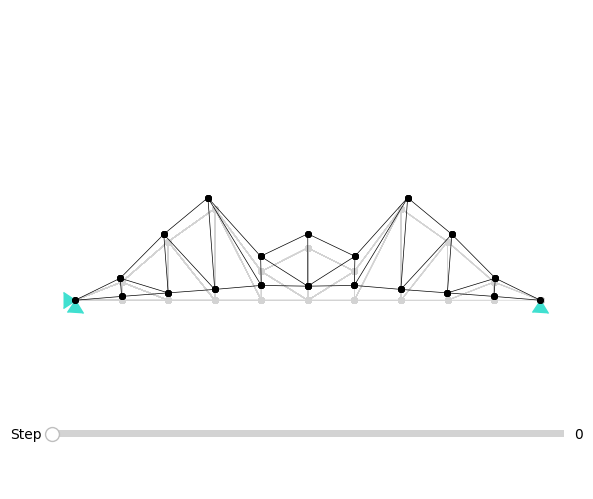

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.364214246822675, 26.156687674765962, 68.63951476508048]
Iteration: 114, the best loss = 1071.85






































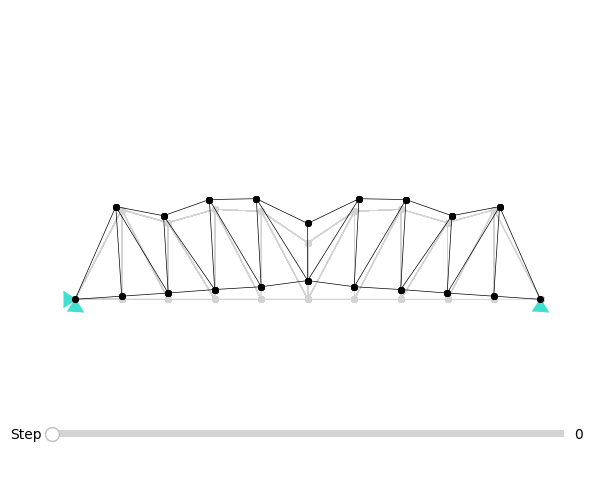

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [11.11109243290823, 39.57631445673507, 58.38777061444386]
Iteration: 115, the best loss = 1071.85






































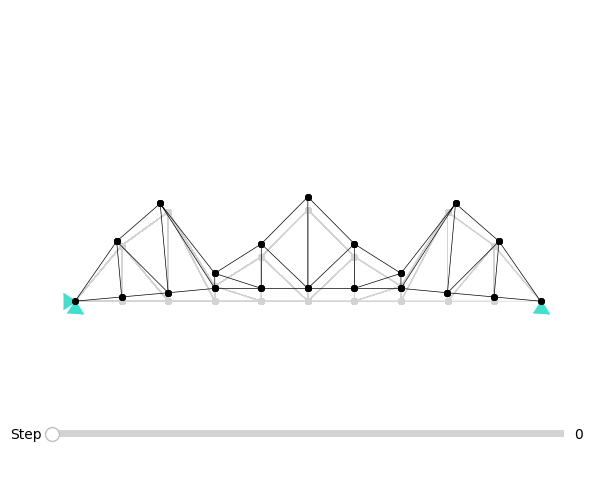

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.334029088776152, 7.632851901848175, 68.19777167492578]
Iteration: 116, the best loss = 1071.85






































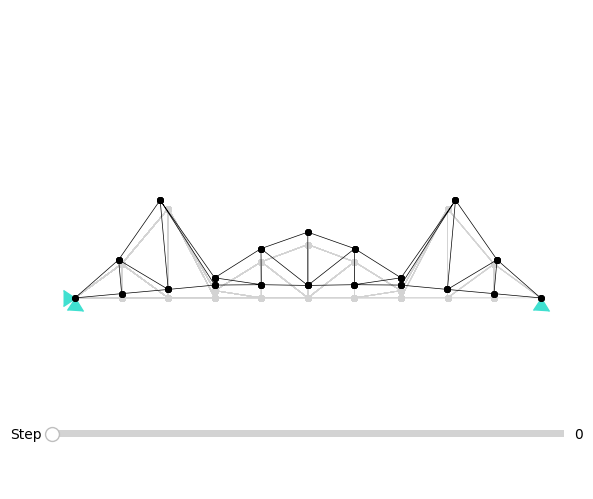

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.528766434124121, 7.096053119778059, 40.12463991450268]
Iteration: 117, the best loss = 1071.85






































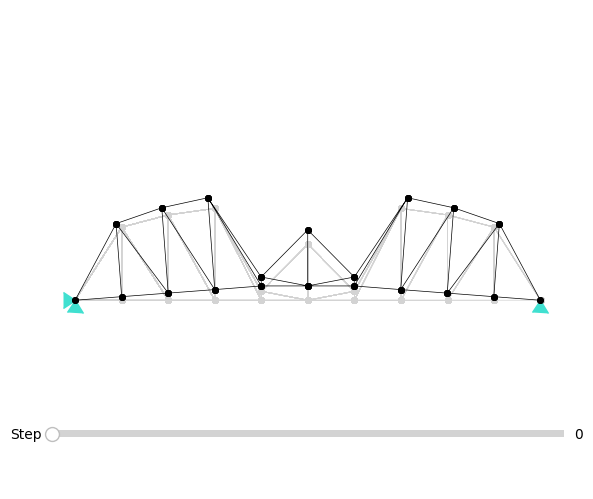

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.5810665418168885, 14.151975517729975, 36.616284615375264]
Iteration: 118, the best loss = 1071.85






































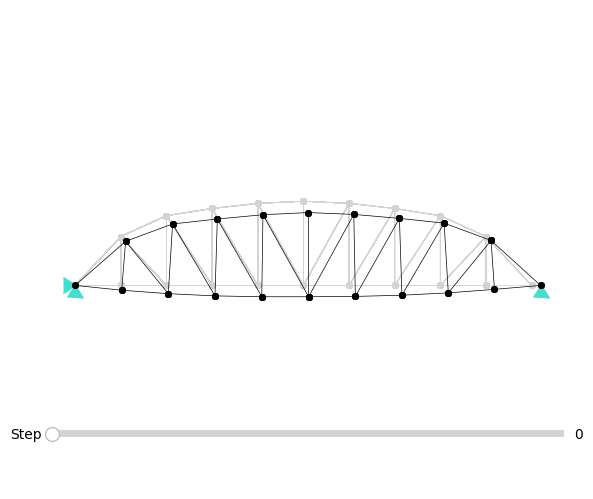

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [16.535392912159413, 35.3767166857005, 61.43892675630489]
Iteration: 119, the best loss = 1071.85






































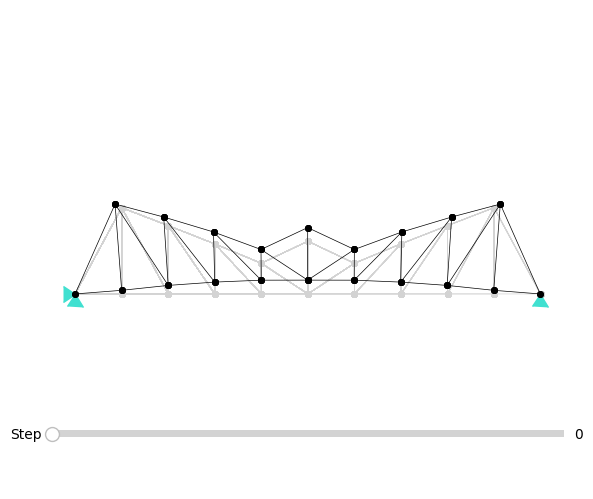

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [9.503540768901154, 35.33229824749374, 69.69644089217556]
Iteration: 120, the best loss = 1071.85






































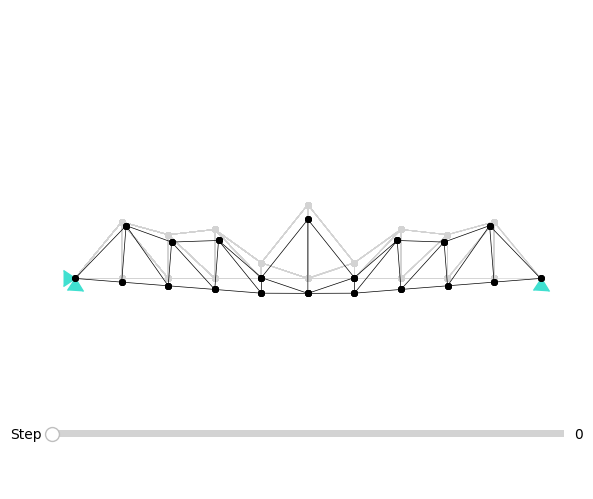

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.7782989624836905, 21.46603318811128, 77.86319281942967]
Iteration: 121, the best loss = 1071.85






































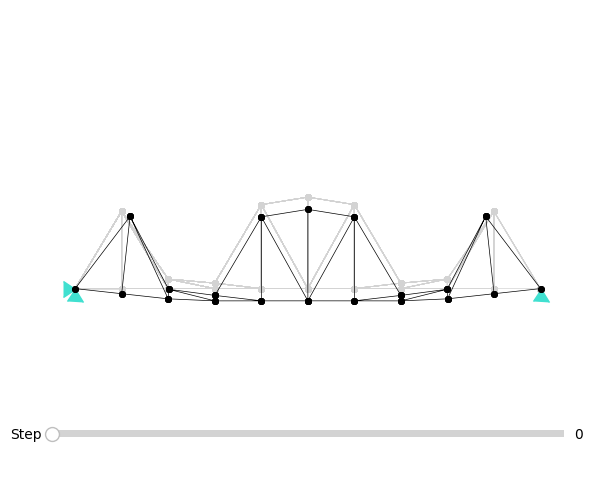

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.7491178545462884, 7.476099038264705, 34.355032298068785]
Iteration: 122, the best loss = 1071.85






































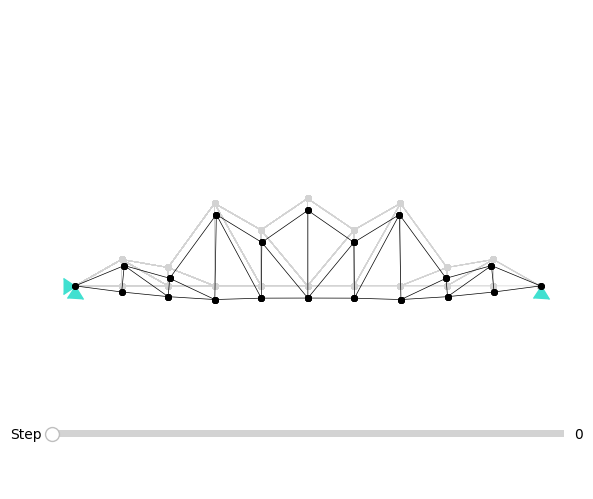

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [11.793138257067502, 27.628681853412193, 74.86019684877401]
Iteration: 123, the best loss = 1071.85






































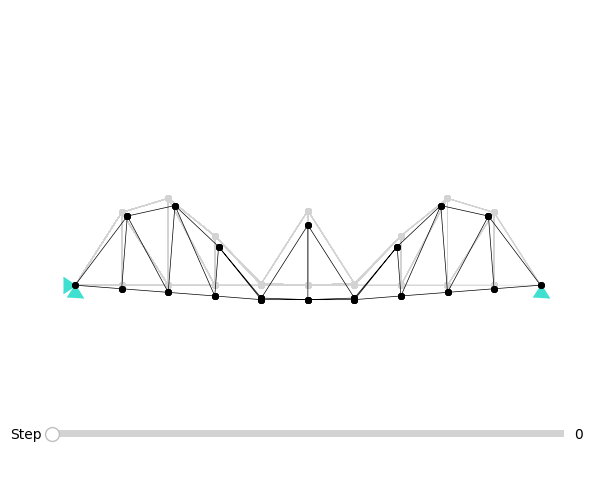

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.3106875278248199, 1.817789110053207, 74.15759569418313]
Iteration: 124, the best loss = 1071.85






































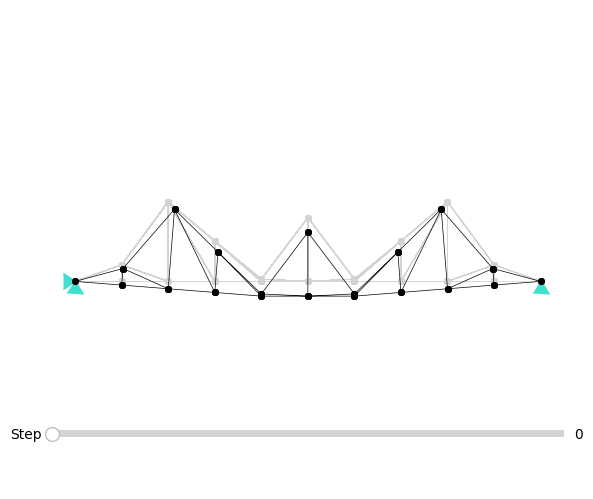

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.8198371561817117, 4.741967499424732, 57.088603963775846]
Iteration: 125, the best loss = 1071.85






































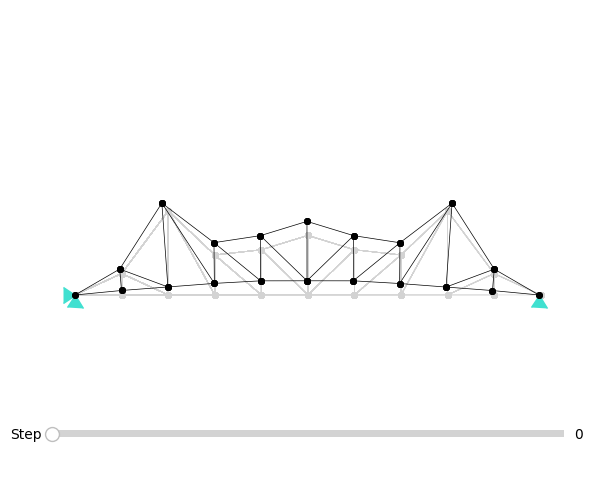

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.320944230284484, 26.874350141112874, 34.47239994661343]
Iteration: 126, the best loss = 1071.85






































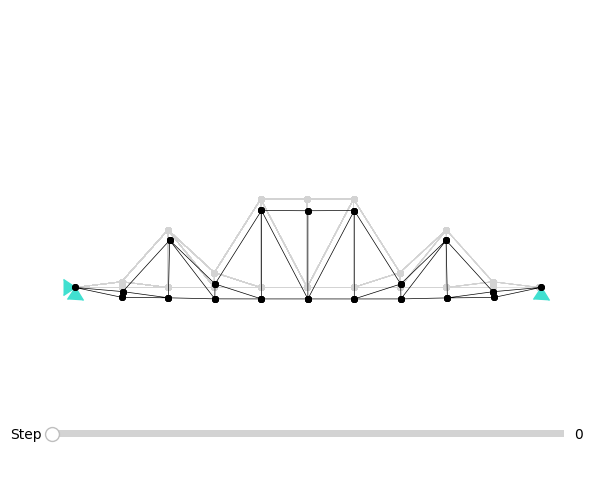

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.406424420744034, 6.065239945789831, 20.096681230259318]
Iteration: 127, the best loss = 1071.85






































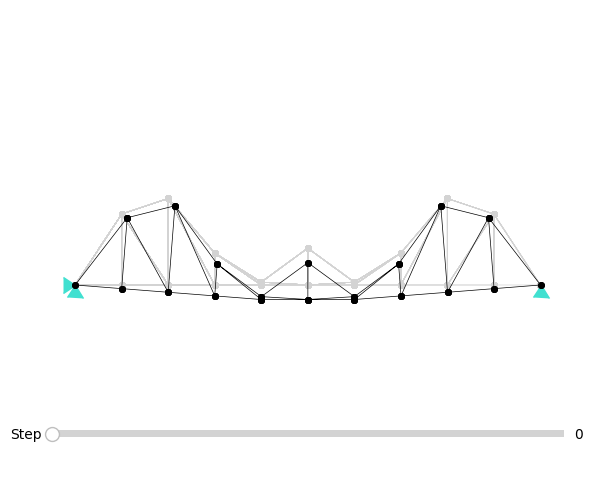

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.3365188504077126, 7.839924429330243, 34.71379022344809]
Iteration: 128, the best loss = 1071.85






































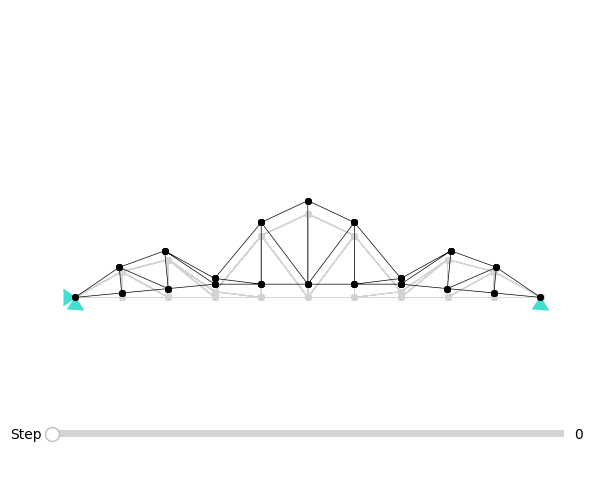

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.5853361471174567, 8.148168462719442, 58.325799488077166]
Iteration: 129, the best loss = 1071.85






































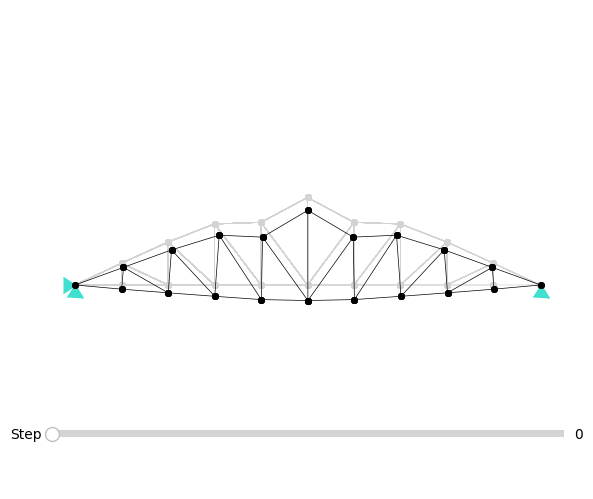

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [12.82865476749966, 52.884934290874014, 72.4275294507972]
Iteration: 130, the best loss = 1071.85






































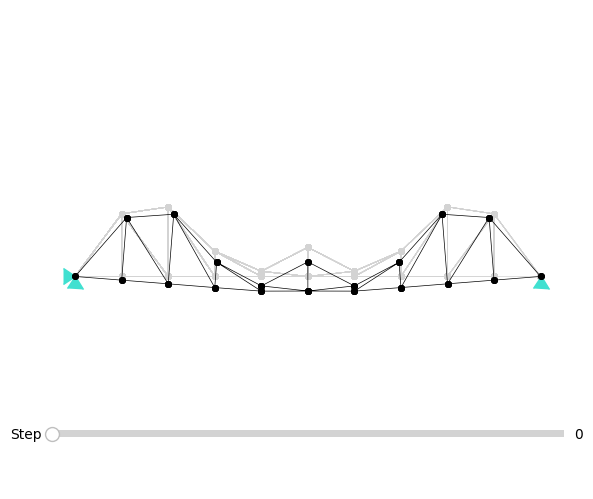

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.0866802663197357, 5.449512757579871, 26.029008992351912]
Iteration: 131, the best loss = 1071.85






































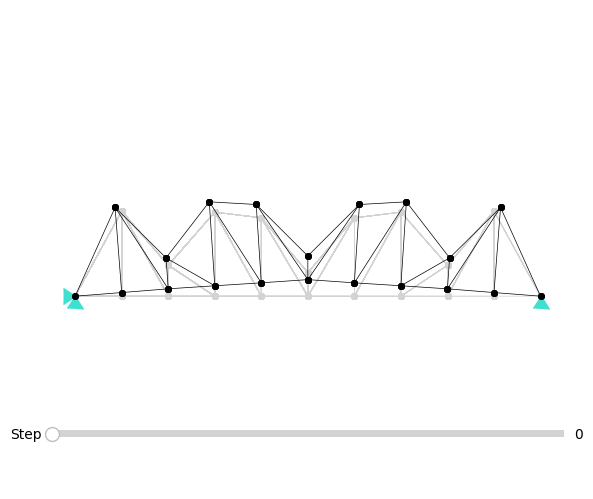

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.604290595904991, 29.468357914179396, 39.374739204221086]
Iteration: 132, the best loss = 1071.85






































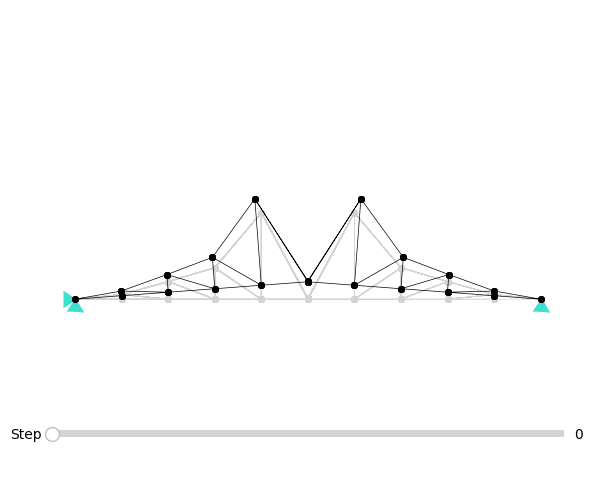

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.2293328971047561, 23.004061990240675, 26.458325854251125]
Iteration: 133, the best loss = 1071.85






































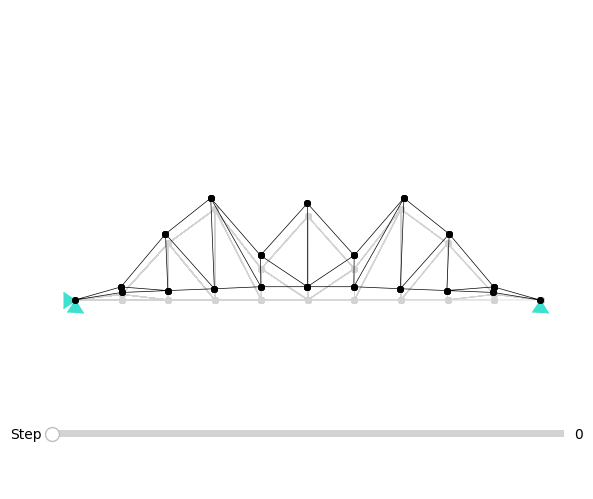

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [7.033321433358472, 20.16055900434533, 34.77118067835595]
Iteration: 134, the best loss = 1071.85






































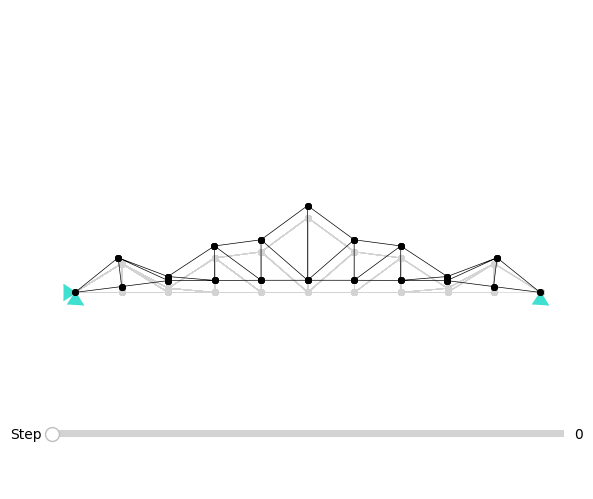

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.044920660699171, 10.776608395325026, 54.15766870653234]
Iteration: 135, the best loss = 1071.85






































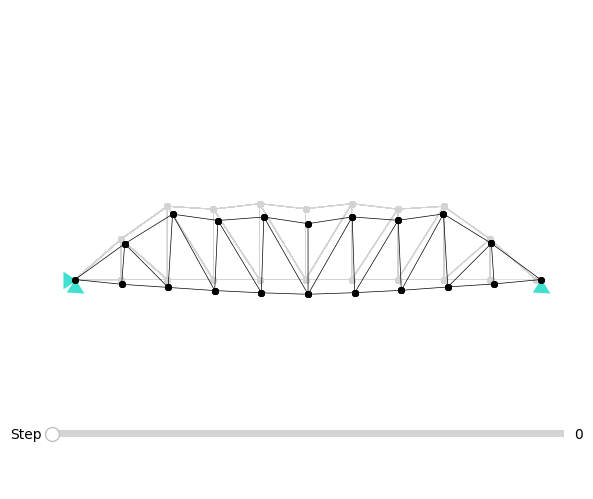

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [29.391684204271336, 67.4463370879766, 97.71900962079145]
The total loss is:1695.2562113764757
Iteration: 136, the best loss = 1071.85






































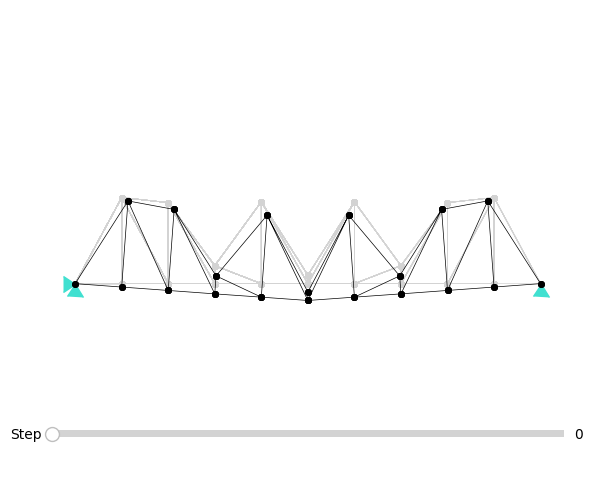

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.3146671612233585, 22.51045328124814, 34.6417028729838]
Iteration: 137, the best loss = 1071.85






































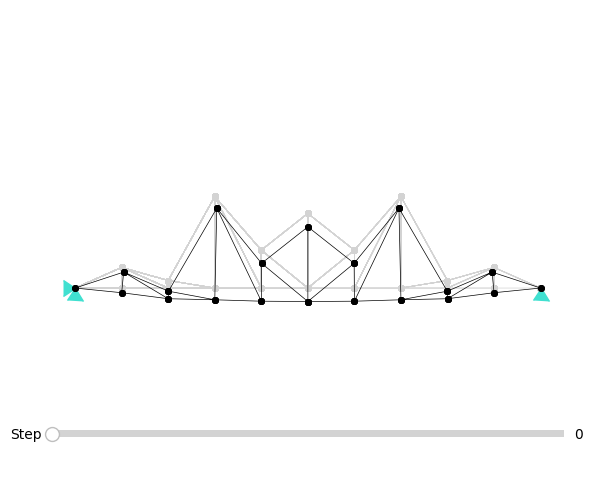

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.671308122796968, 10.58775122146462, 25.599071878789584]
Iteration: 138, the best loss = 1071.85






































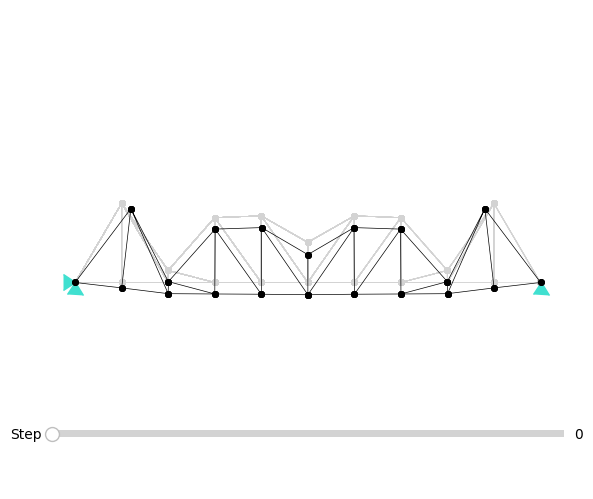

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.886271479099927, 12.290681981798128, 49.545316812356276]
Iteration: 139, the best loss = 1071.85






































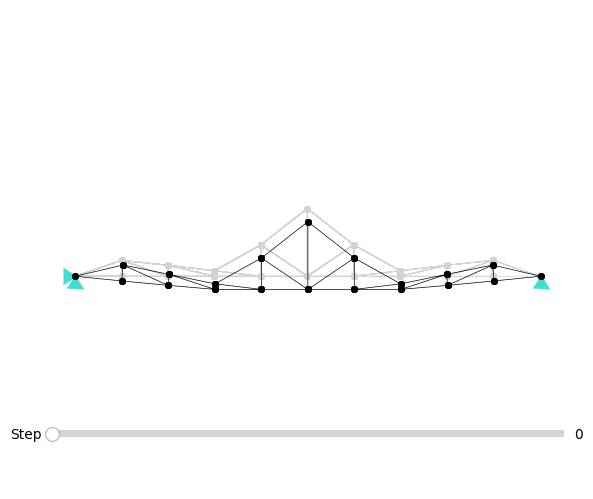

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.271677785021147, 13.169844924963034, 45.06779885917265]
Iteration: 140, the best loss = 1071.85






































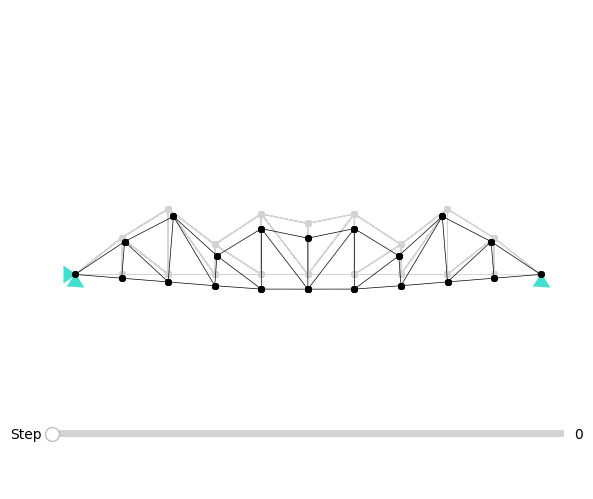

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.535984292405551, 26.255310882270916, 66.34767221592342]
Iteration: 141, the best loss = 1071.85






































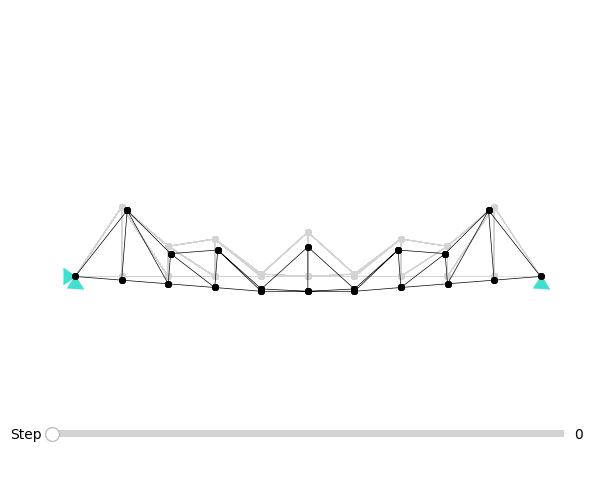

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.0725234487705149, 6.200895127517777, 42.84546559196804]
Iteration: 142, the best loss = 1071.85






































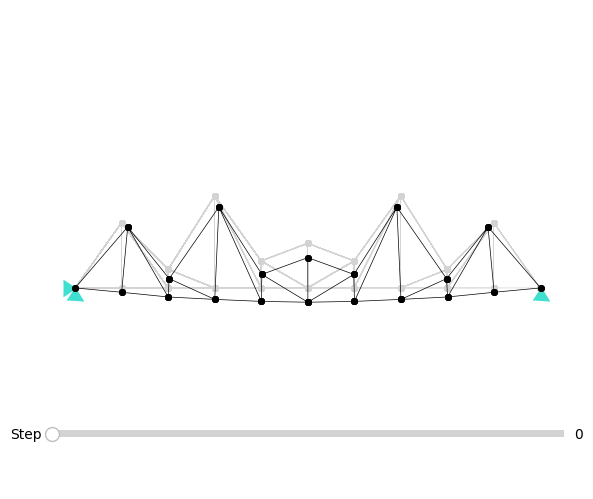

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.06685761393967, 20.61982261794305, 38.63952861232655]
Iteration: 143, the best loss = 1071.85






































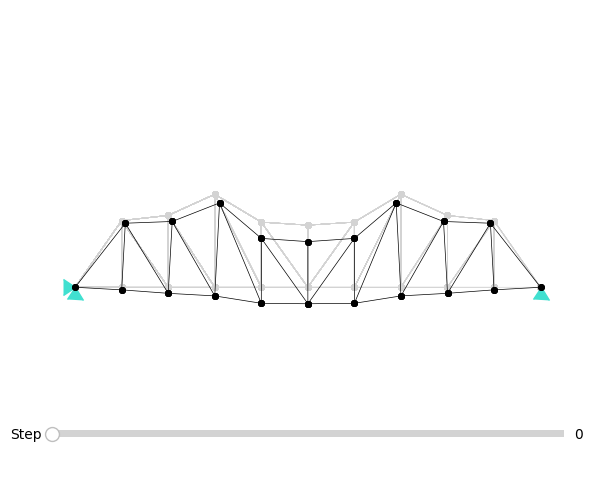

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [7.9215800431325665, 37.66434199508699, 50.51904230273226]
Iteration: 144, the best loss = 1071.85






































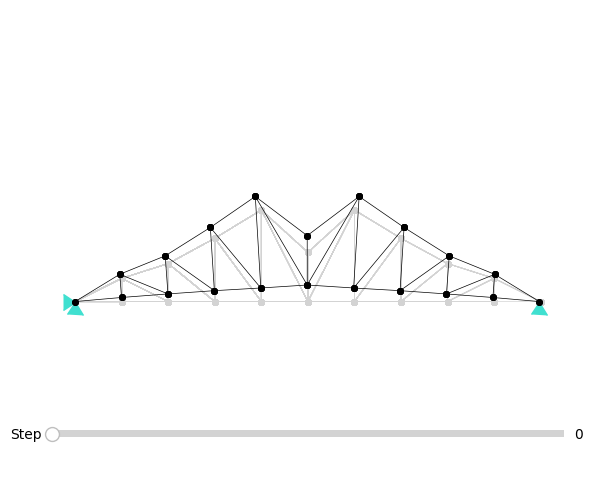

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.856103363708641, 47.62338088064496, 64.1581818925842]
Iteration: 145, the best loss = 1071.85






































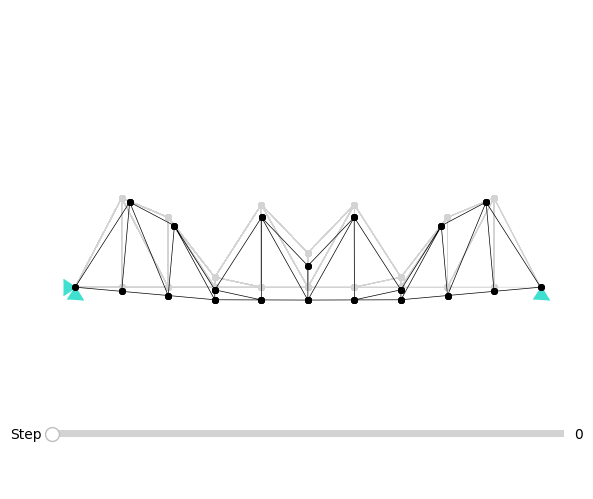

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.4247789196415193, 7.803183311522413, 51.52107729902848]
Iteration: 146, the best loss = 1071.85






































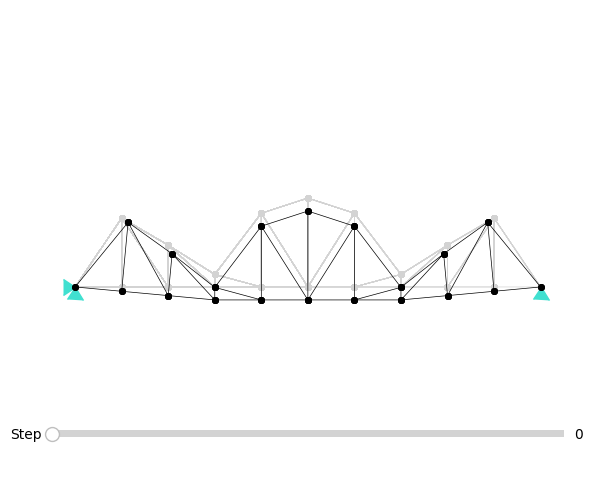

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.667536243135562, 5.056299621773265, 69.13371715223654]
Iteration: 147, the best loss = 1071.85






































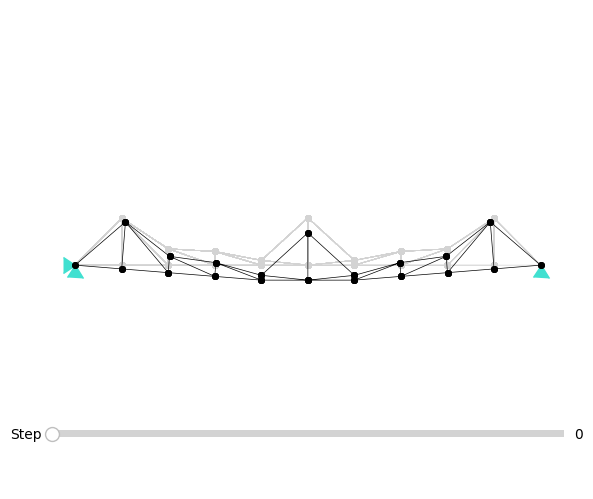

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.6408618451327459, 3.668671318120982, 52.19039423760135]
Iteration: 148, the best loss = 1071.85






































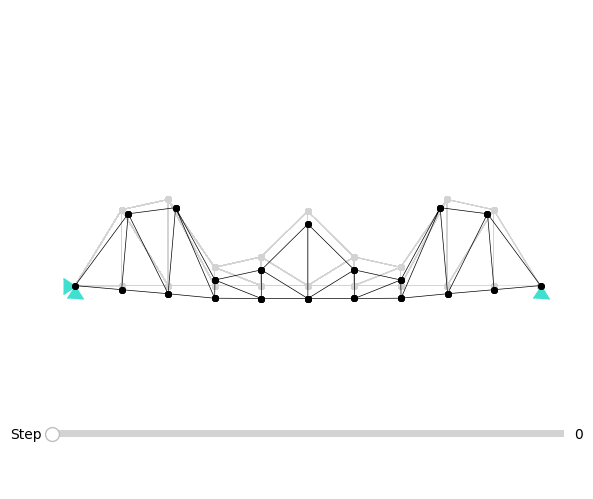

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.658997794884086, 22.262509975573867, 52.68961926387353]
Iteration: 149, the best loss = 1071.85






































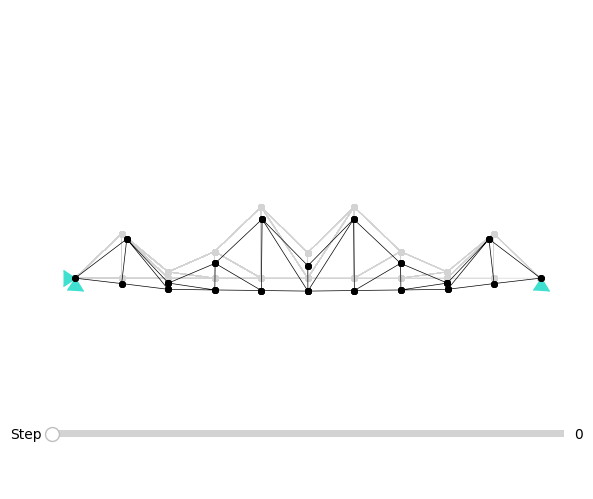

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.434149629009698, 11.651094788734294, 36.406622956369496]
Iteration: 150, the best loss = 1071.85






































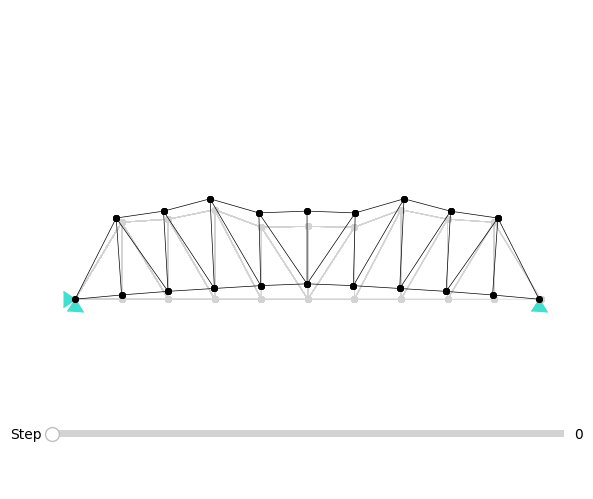

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [23.372619905703004, 67.59317460996003, 80.86824858970493]
The total loss is:1899.858636458594
Iteration: 151, the best loss = 1071.85






































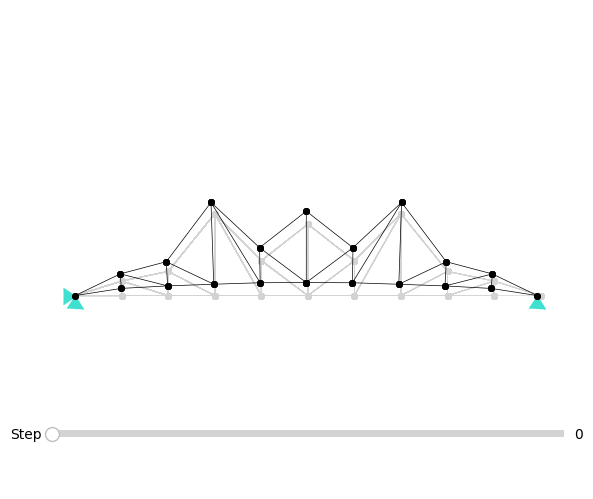

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [7.3524543298274025, 20.157971652286413, 34.67814979299768]
Iteration: 152, the best loss = 1071.85






































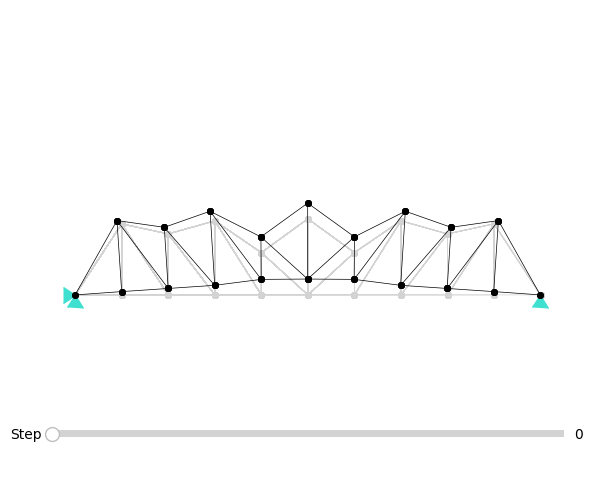

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.16535584837064, 62.03584073109398, 80.12207942651379]
Iteration: 153, the best loss = 1071.85






































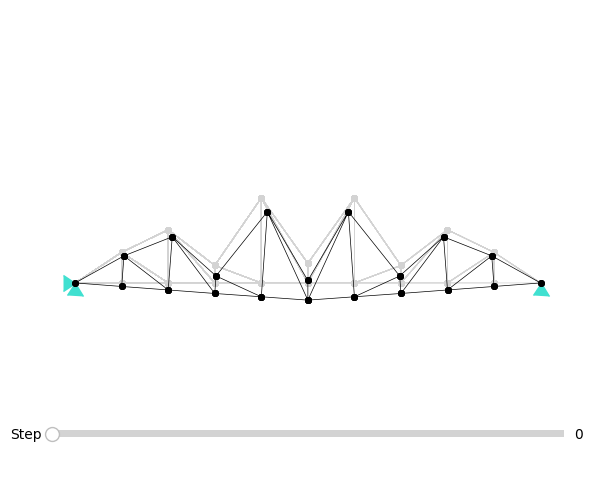

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.219190968572765, 30.94462545581927, 42.116972207924185]
Iteration: 154, the best loss = 1071.85






































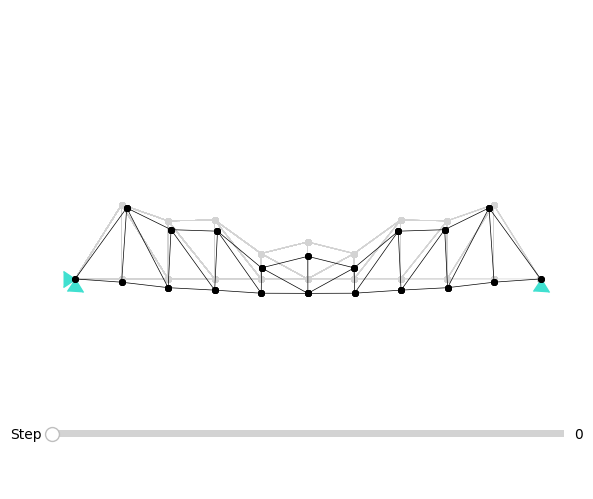

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.293407333520706, 40.99940830963831, 68.4973447147669]
Iteration: 155, the best loss = 1071.85






































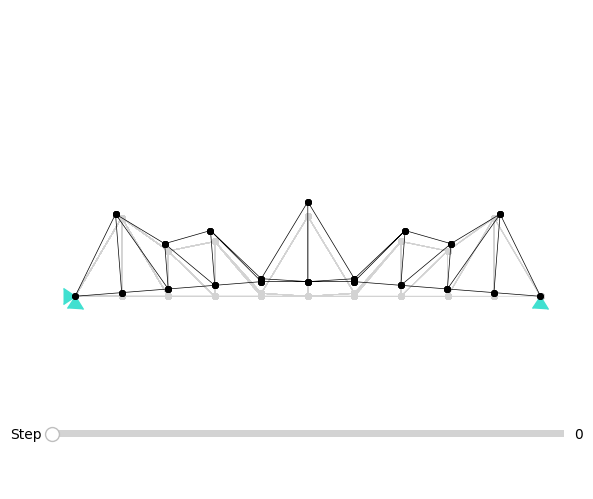

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.040439585431833, 5.750677706258272, 38.4029490637497]
Iteration: 156, the best loss = 1071.85






































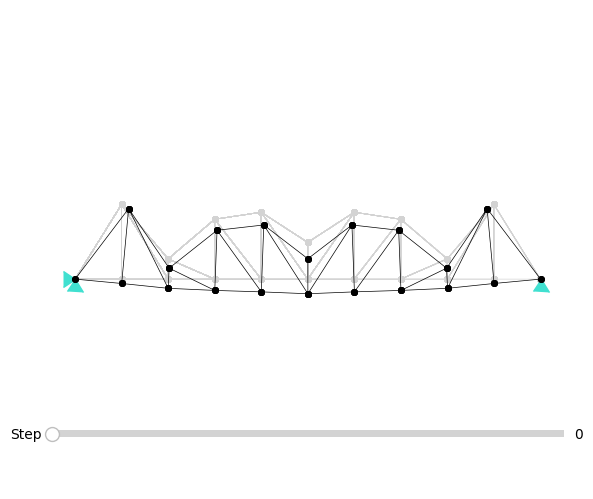

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.871894927303157, 22.825220127802417, 40.24271557709704]
Iteration: 157, the best loss = 1071.85






































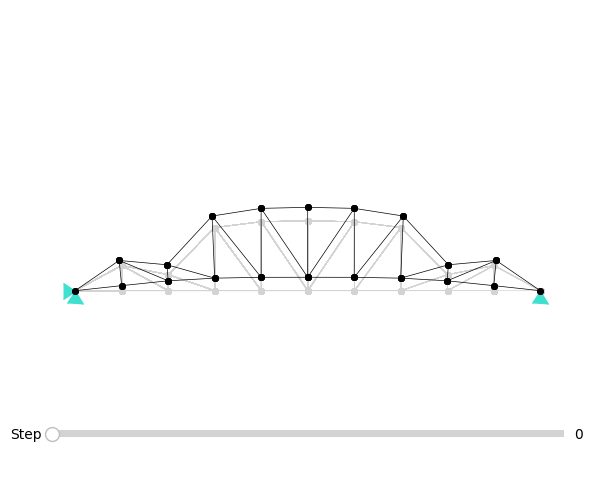

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.066040320865358, 25.512615643372197, 54.542430697711424]
Iteration: 158, the best loss = 1071.85






































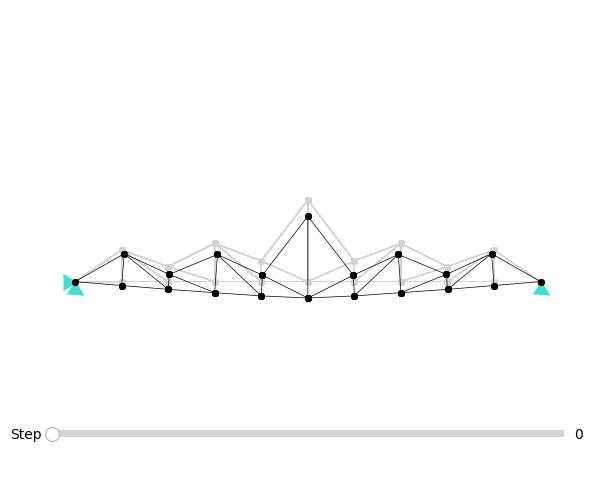

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.909738797154383, 29.973049403147282, 53.02464109833484]
Iteration: 159, the best loss = 1071.85






































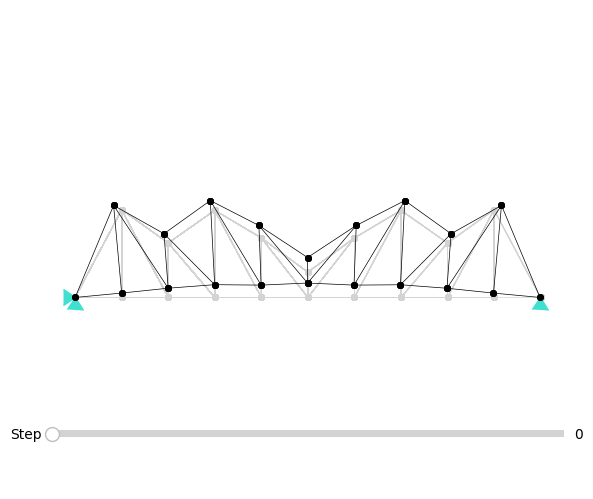

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [11.51979535119041, 25.877586971556557, 33.982533273471375]
Iteration: 160, the best loss = 1071.85






































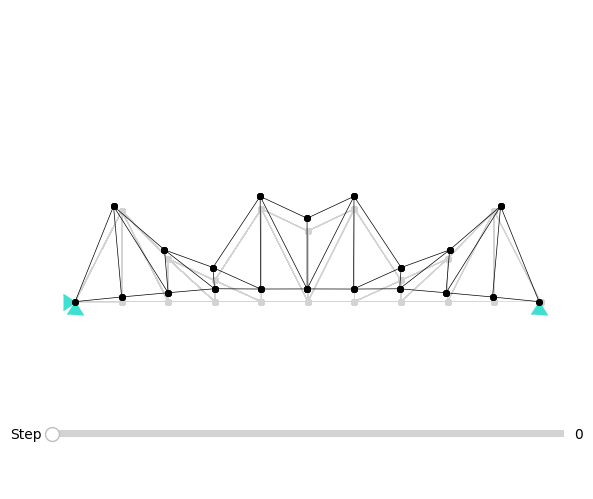

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.944366355657147, 16.433300637642034, 24.887825420627607]
Iteration: 161, the best loss = 1071.85






































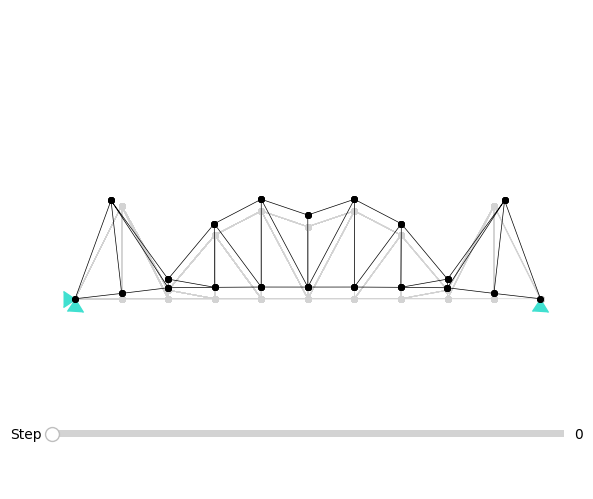

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.3447263827257587, 7.566948445510556, 39.02875644789517]
Iteration: 162, the best loss = 1071.85






































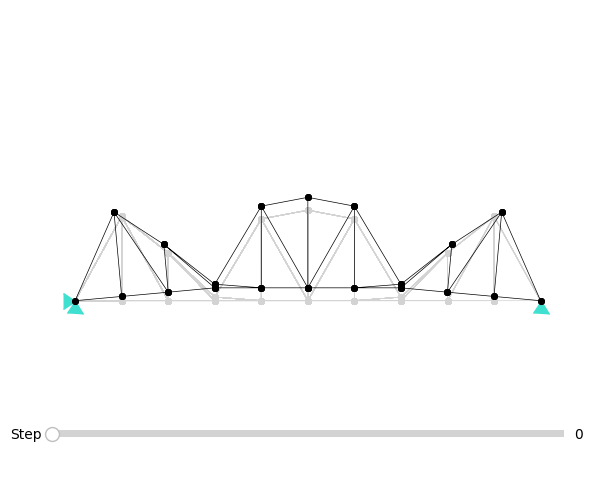

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.4158688276089895, 4.726632425103011, 71.72970121449413]
Iteration: 163, the best loss = 1071.85






































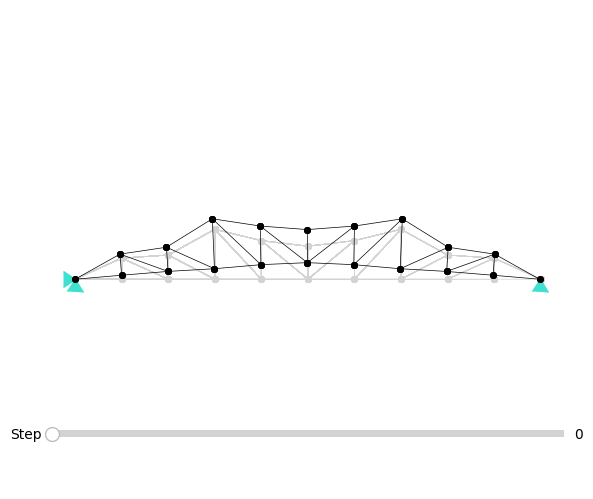

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [14.517872424403885, 44.171657525156235, 69.03462510325056]
Iteration: 164, the best loss = 1071.85






































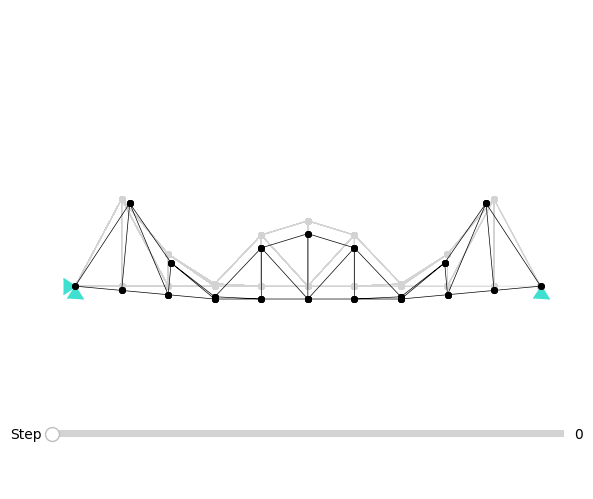

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.6498406784266557, 5.525468997738696, 56.98204911694346]
Iteration: 165, the best loss = 1071.85






































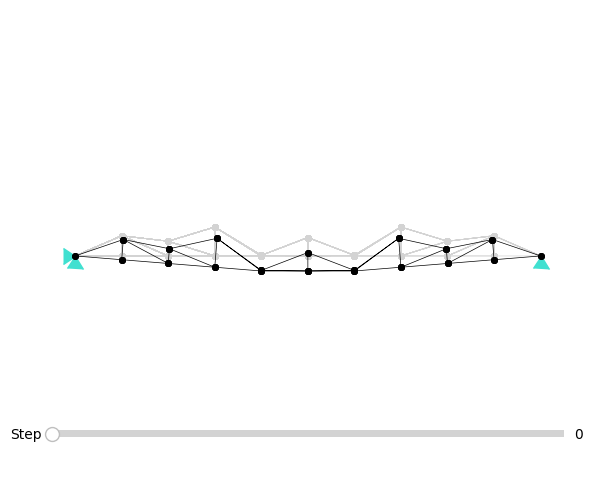

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.4295818943578054, 2.5780515770055876, 48.27307892334182]
Iteration: 166, the best loss = 1071.85






































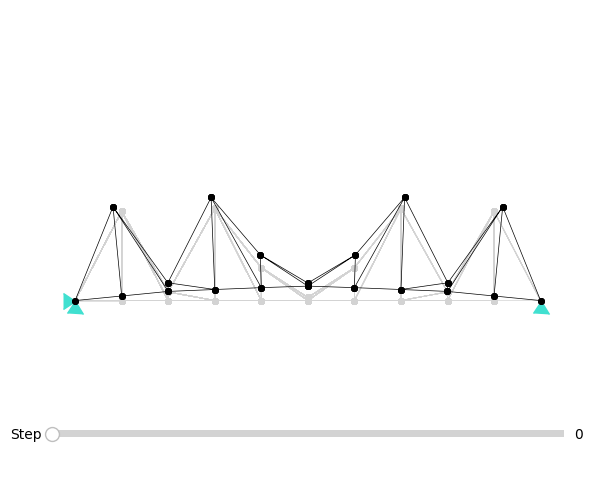

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.5603100556379081, 5.526533168822358, 10.032075902874046]
Iteration: 167, the best loss = 1071.85






































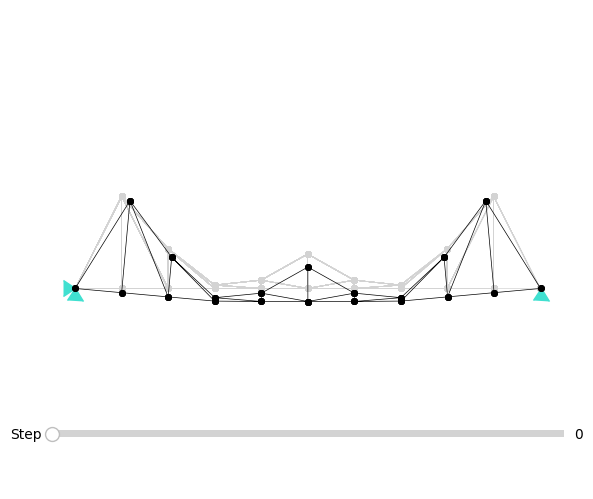

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.8948455897714964, 6.22732114947931, 31.55957830842462]
Iteration: 168, the best loss = 1071.85






































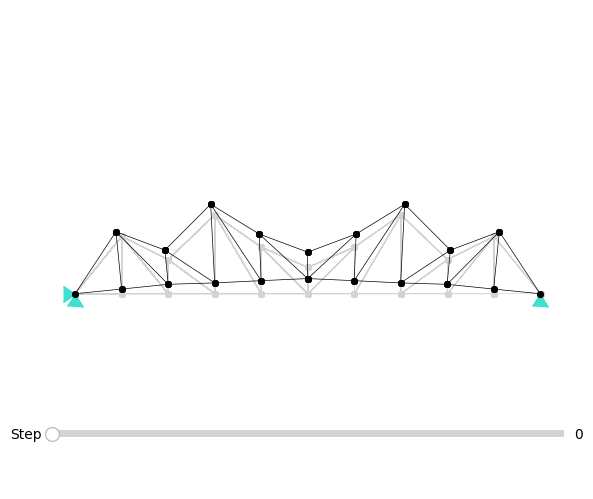

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.94268552092796, 27.260392430271256, 38.553472289566415]
Iteration: 169, the best loss = 1071.85






































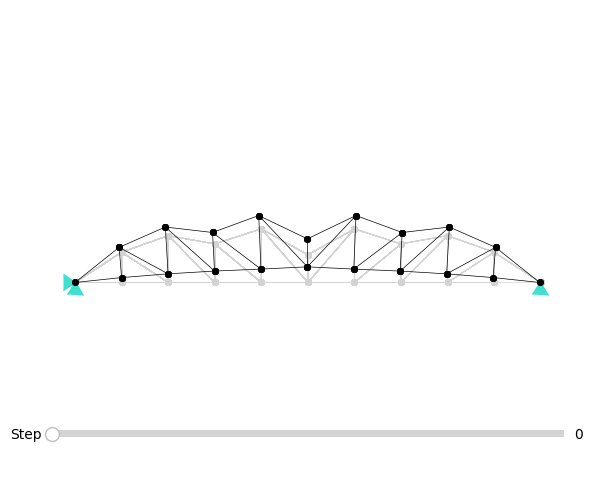

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [13.750969382878706, 48.30612374782549, 70.63491265753811]
Iteration: 170, the best loss = 1071.85






































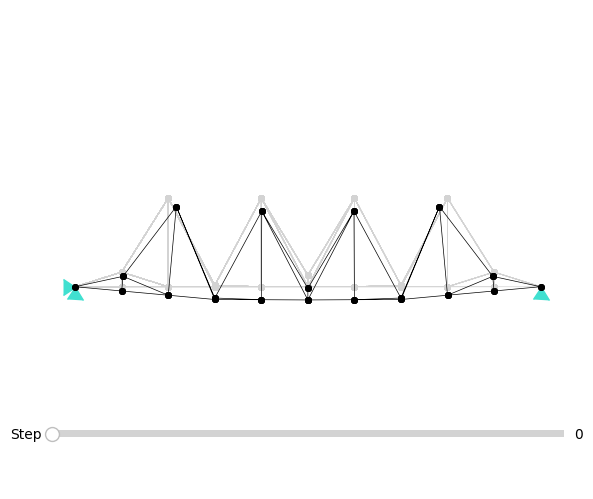

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.4222387877571609, 1.331388253223239, 7.094809394163165]
Iteration: 171, the best loss = 1071.85






































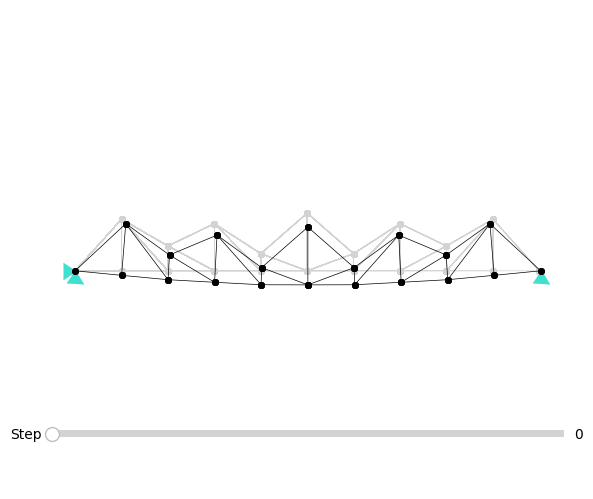

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [8.186580082402383, 31.53736335183989, 51.64786579124374]
Iteration: 172, the best loss = 1071.85






































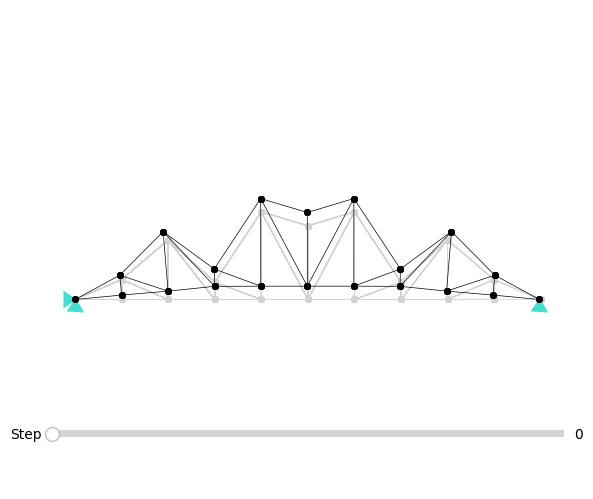

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.15535362772937, 17.47029603513249, 32.79987873732616]
Iteration: 173, the best loss = 1071.85






































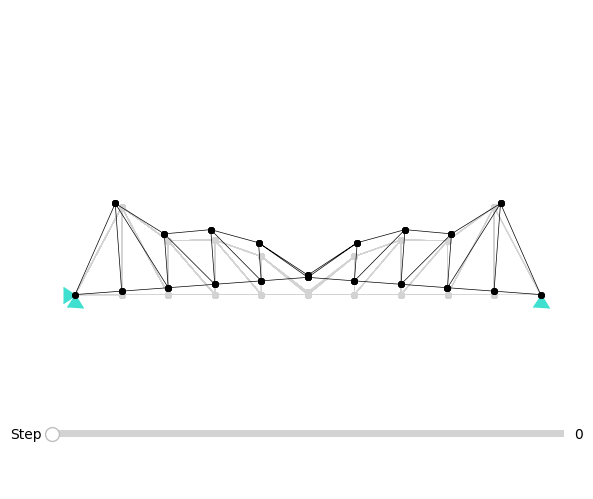

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.049192390333026, 60.28574548843198, 73.13614677469863]
Iteration: 174, the best loss = 1071.85






































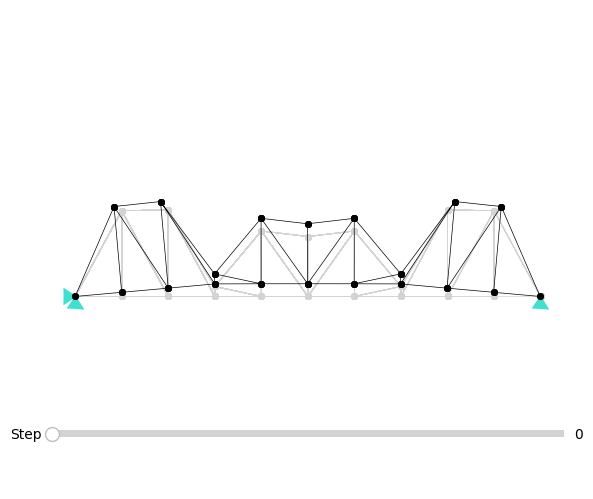

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.680796944893381, 8.814256881484075, 26.83071793048206]
Iteration: 175, the best loss = 1071.85






































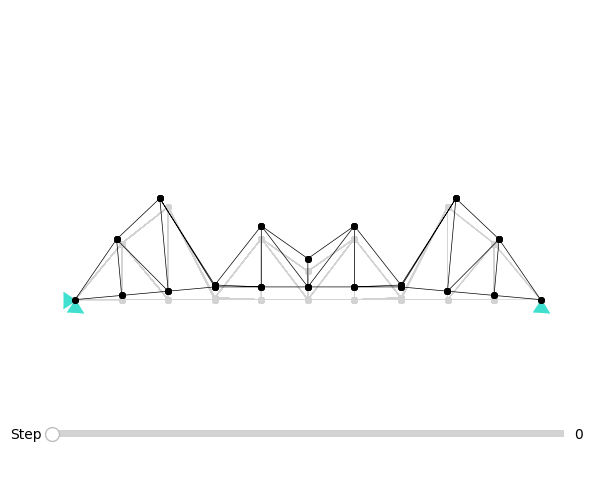

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.5676681700446558, 1.7980141468811923, 57.71117353885504]
Iteration: 176, the best loss = 1071.85






































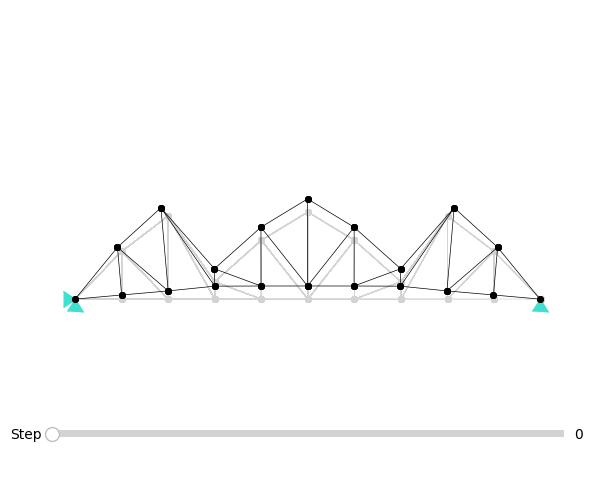

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.751827839277955, 16.41995055680811, 33.65636186160245]
Iteration: 177, the best loss = 1071.85






































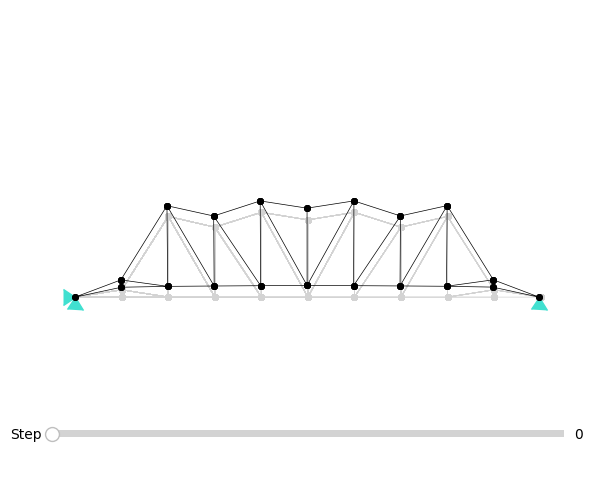

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [9.228869243784471, 21.10725755091134, 57.154865894370715]
Iteration: 178, the best loss = 1071.85






































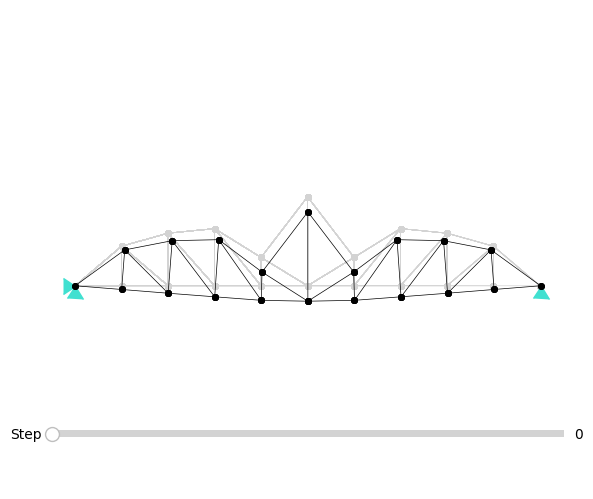

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [11.32688376139056, 66.07744277026767, 74.30352166489492]
Iteration: 179, the best loss = 1071.85






































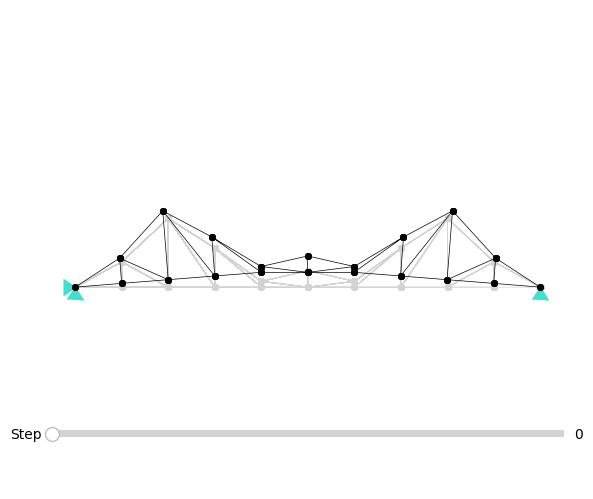

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.620297950220822, 19.36670344398039, 50.34841196813964]
Iteration: 180, the best loss = 1071.85






































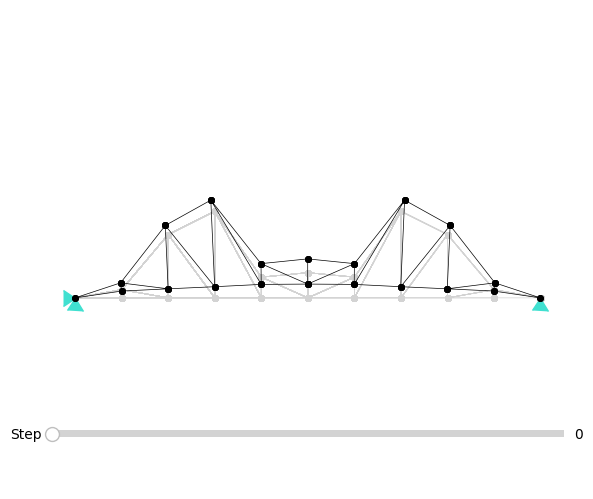

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.782754739313334, 18.222031076315226, 30.725940073648566]
Iteration: 181, the best loss = 1071.85






































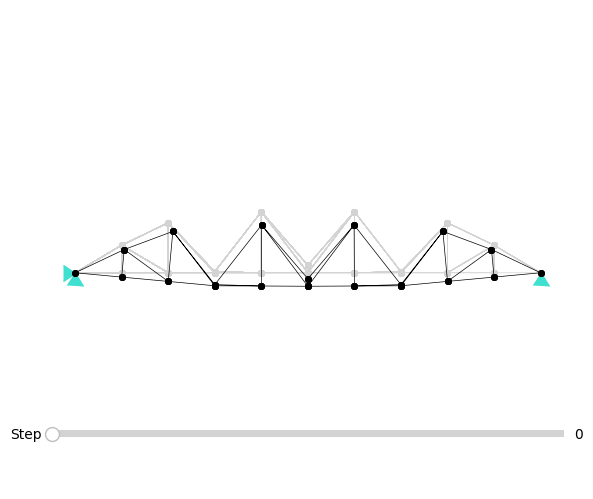

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.5285325838627029, 1.7804458904728064, 10.943564049253661]
Iteration: 182, the best loss = 1071.85






































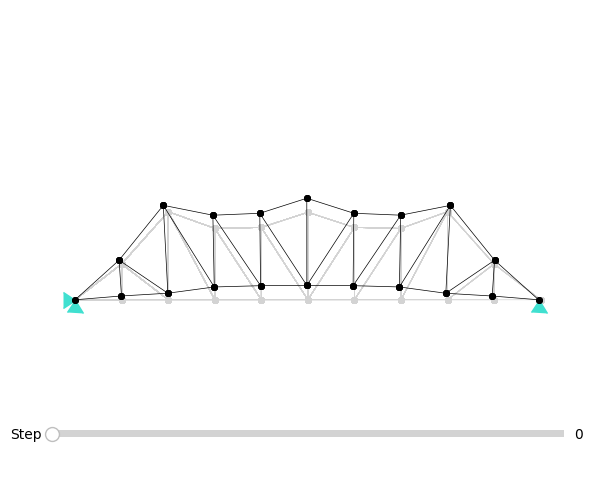

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [21.444308896458477, 65.84193838057315, 80.59438983256618]
The total loss is:2006.6943313390123
Iteration: 183, the best loss = 1071.85






































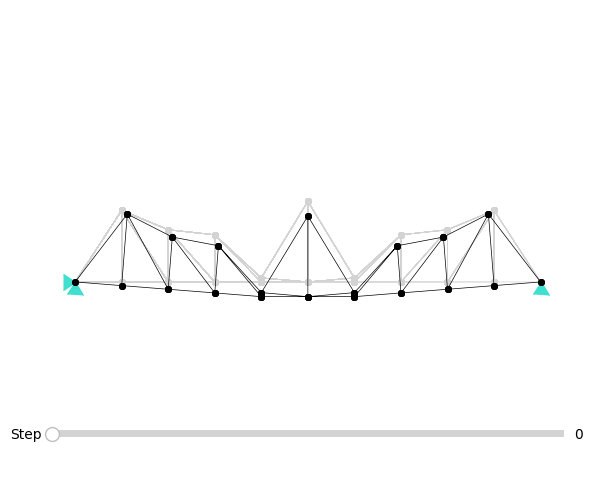

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.4642185648125776, 8.259478995190424, 73.39771342654095]
Iteration: 184, the best loss = 1071.85






































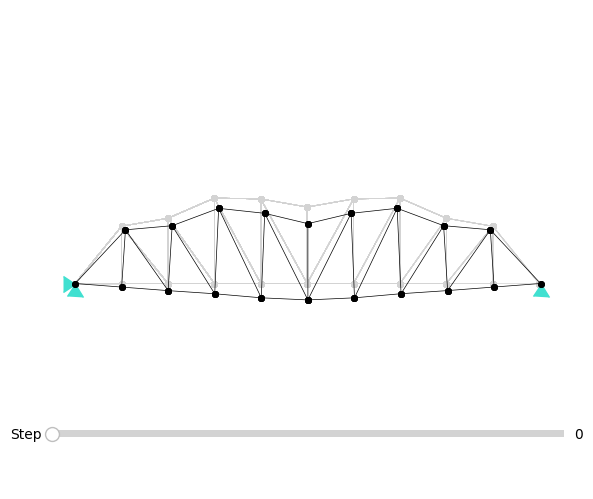

The constraints of the natural frequencies are met NATURAL FREQUENCIES: [21.6532370615976, 65.87378032483187, 82.34728623969502]
The total loss is:1705.3996708476889
Iteration: 185, the best loss = 1071.85






































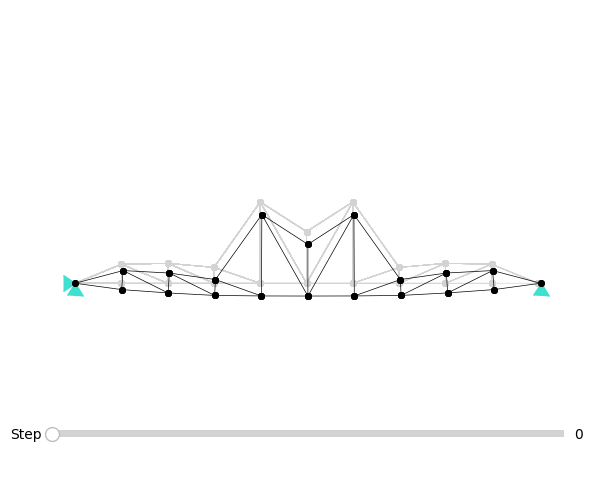

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [6.4629668333125645, 19.978199106430132, 37.31236724006277]
Iteration: 186, the best loss = 1071.85






































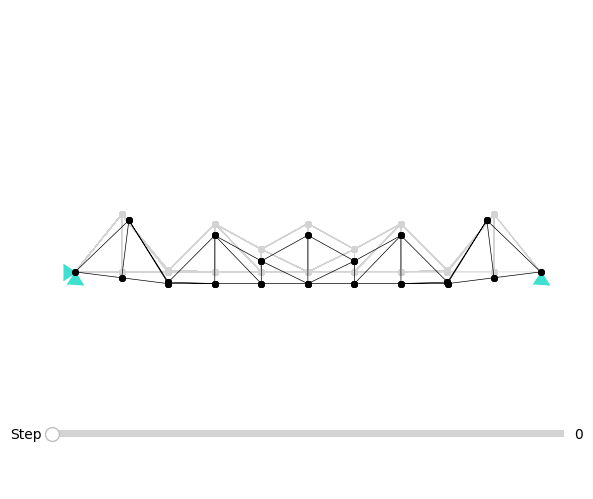

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.8931116982623024, 2.151358099348191, 35.6655605422969]
Iteration: 187, the best loss = 1071.85






































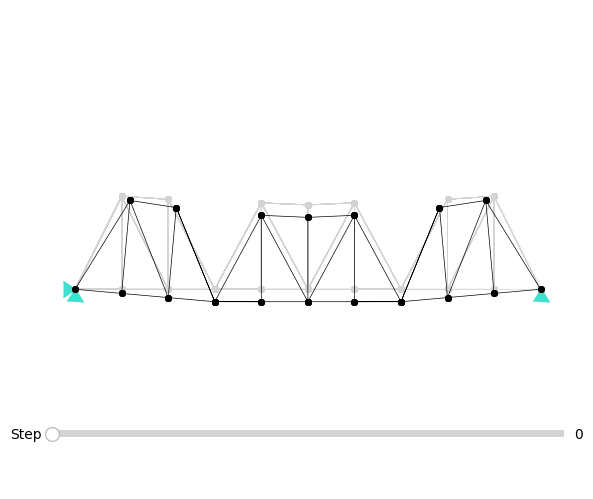

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.053255903651590664, 0.16096847955989987, 59.302302877209485]
Iteration: 188, the best loss = 1071.85






































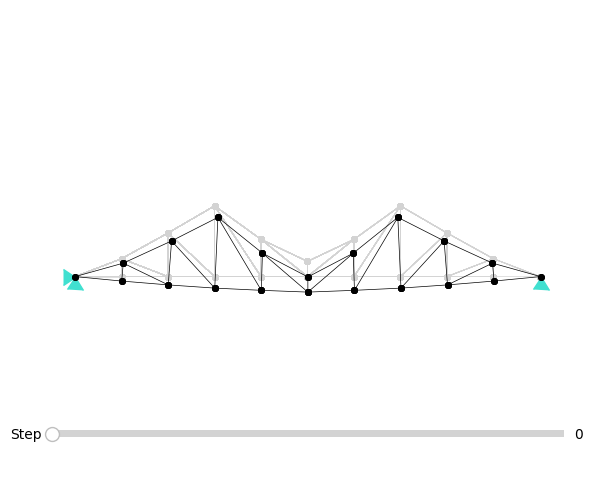

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [9.304125735513495, 40.38260579250465, 57.34022670547925]
Iteration: 189, the best loss = 1071.85






































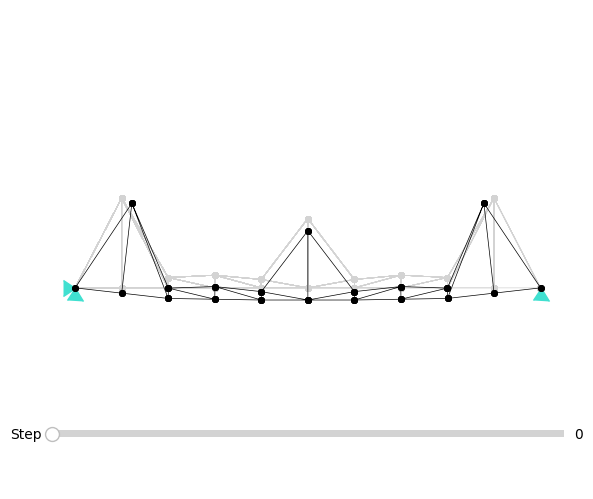

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.1557582755391165, 5.098006196533827, 17.195840323647055]
Iteration: 190, the best loss = 1071.85






































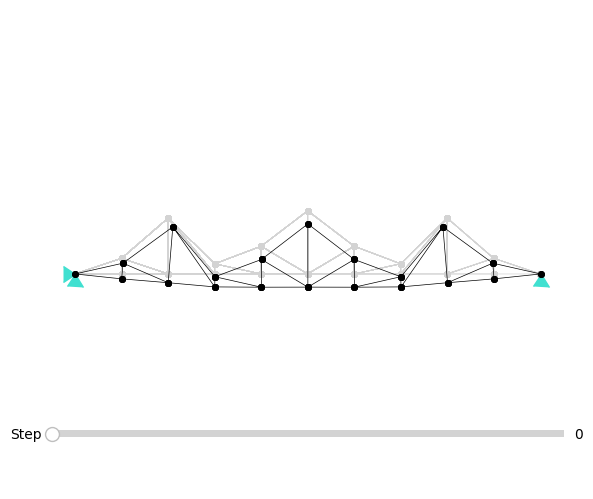

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.559064911380558, 17.10721934515718, 55.63168079898332]
Iteration: 191, the best loss = 1071.85






































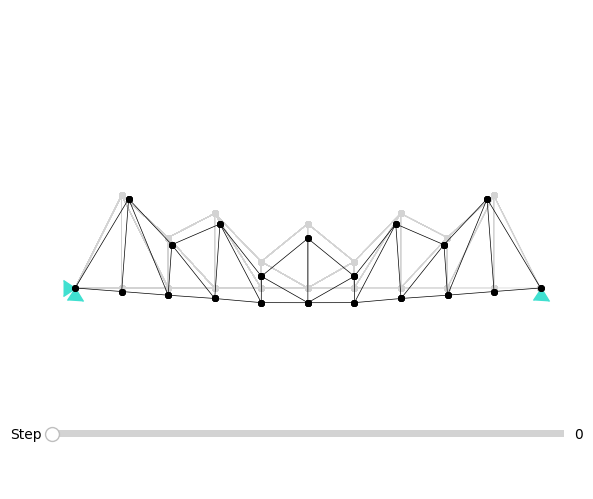

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [5.853163447385768, 33.44506458191433, 45.68899171765604]
Iteration: 192, the best loss = 1071.85






































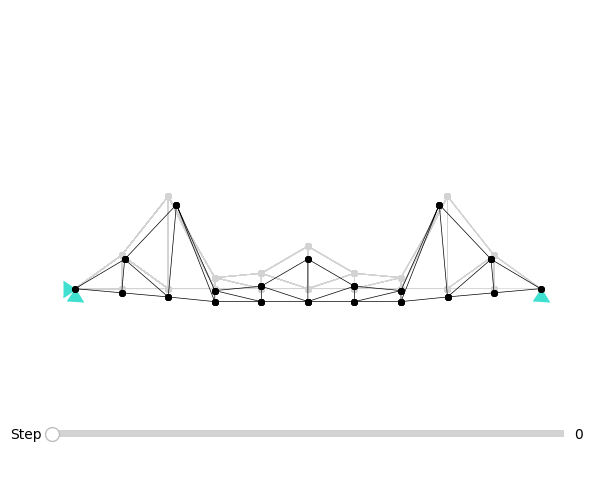

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [0.9539002191450568, 3.169352724431165, 19.340716907723653]
Iteration: 193, the best loss = 1071.85






































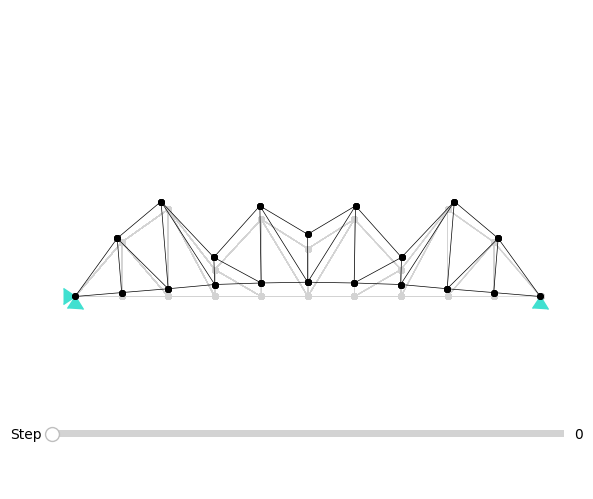

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [7.972595732159089, 32.08079600423499, 60.38110960496983]
Iteration: 194, the best loss = 1071.85






































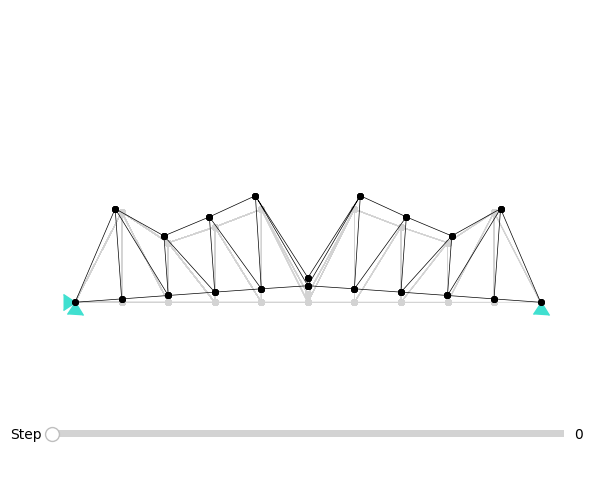

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [1.844517970633259, 22.718602693725078, 30.327712017903487]
Iteration: 195, the best loss = 1071.85






































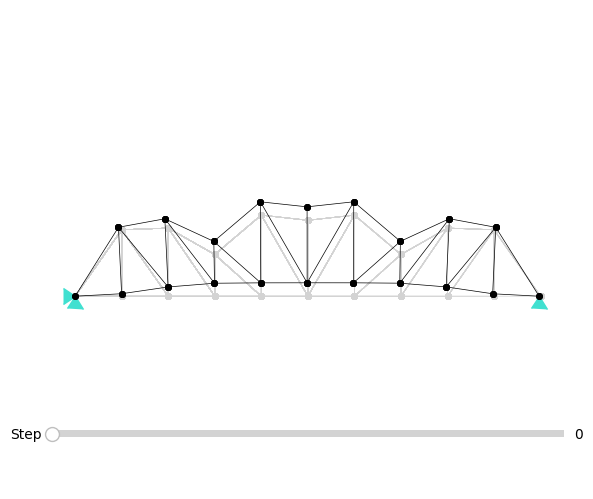

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [13.065885207683118, 40.41584190520303, 54.968438026342035]
Iteration: 196, the best loss = 1071.85






































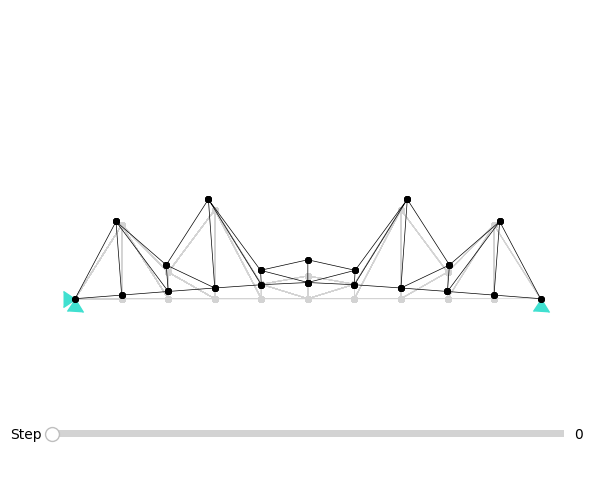

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [2.746896341507689, 17.981225725572504, 35.211600231905514]
Iteration: 197, the best loss = 1071.85






































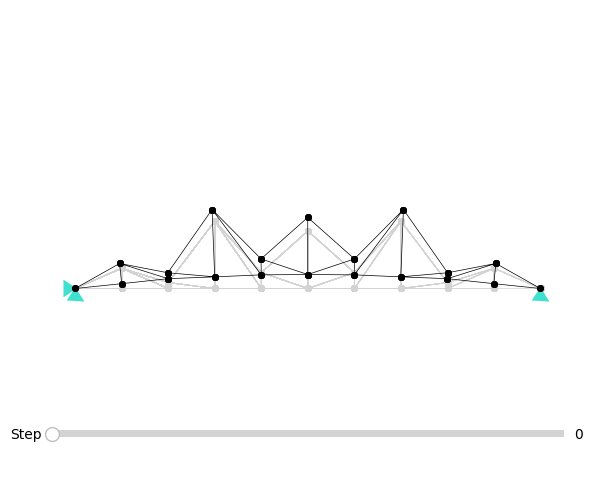

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [4.231058141312148, 14.030673386086448, 30.87931822524998]
Iteration: 198, the best loss = 1071.85






































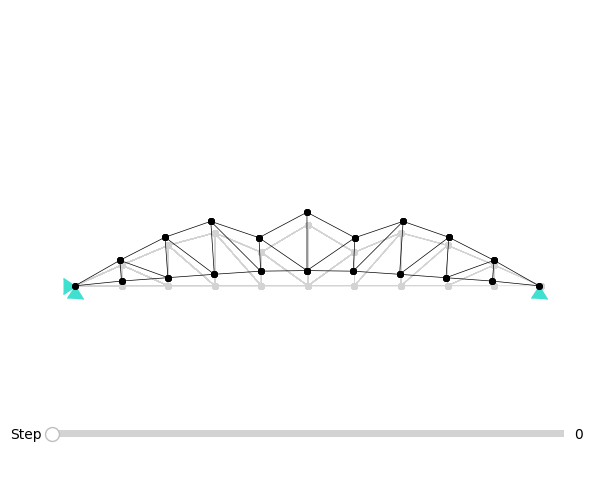

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [10.136755597515311, 36.73202800017852, 48.29157979202544]
Iteration: 199, the best loss = 1071.85






































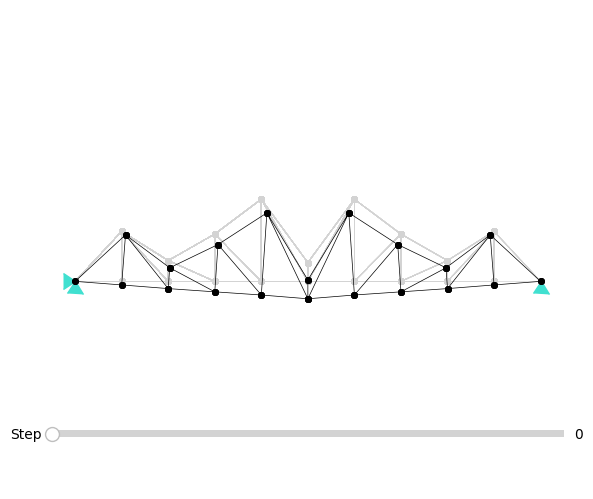

The constraints for the natural frequencies are not met NATURAL FREQUENCIES: [3.416668169064188, 30.139739937156637, 41.69874682851629]


In [21]:
bopt = BayesianOptimizer(target_func=target_function_wrapper, x_init=x_list, y_init=y_list, n_iter=200, batch_size=50)
optimal_x, y_max = bopt.optimize()

In [23]:
optimal_x

array([1.60013269e+00, 1.36824373e+00, 1.86017179e+00, 1.33197509e+00,
       1.44591269e+00, 3.82585086e-03, 4.83249850e-03, 1.50539506e-03,
       6.80824396e-03, 2.98952820e-03, 9.74659609e-03, 6.02716456e-04,
       2.14562285e-03, 7.31259431e-03, 1.51482110e-03, 5.16387196e-03,
       5.76004459e-03, 4.26061320e-03, 1.82164893e-03, 3.62977796e-03])

In [24]:
m, f = TRUSS1.final_results(optimal_x)
print(m)
print(f)
print(optimal_x)
y = optimal_x[:5]
A = optimal_x[5:]
A = np.append([4e-3], A)
eigenfrequencies_1(A, y)

TypeError: 'TRUSS' object is not subscriptable

<AxesSubplot:>

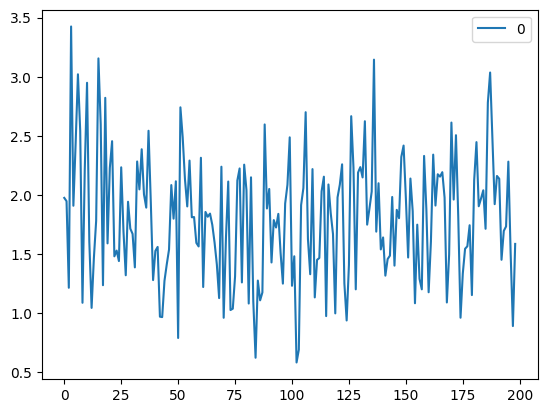

In [25]:
pd.DataFrame(bopt.distances_).plot()

<AxesSubplot:title={'center':'Loss development'}, xlabel='Iterations', ylabel='Loss'>

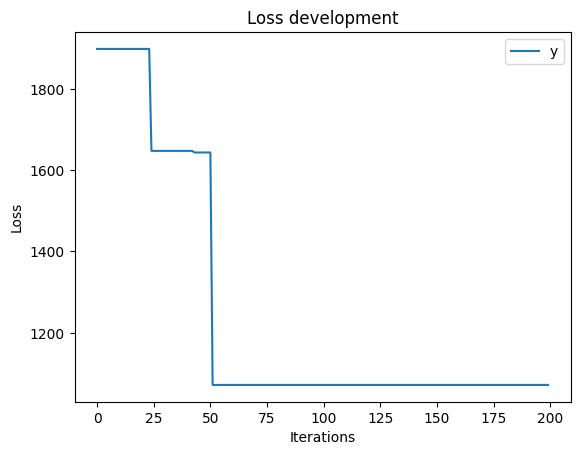

In [26]:
pd.DataFrame(bopt.best_samples_['y']).plot(title='Loss development', xlabel='Iterations', ylabel='Loss')

In [85]:
pd.DataFrame(bopt.best_samples_['ei']).plot()

TypeError: no numeric data to plot